# testing several models for both the SeaFlow and Zinser (updated) datasets
 * modified from 2020-05-16 notebook with a focus on comapring the different fitting techniques and model formulations
 * plots have been added and improved
 * this is to test compare different models and quickly visualize fit to observations and division
 
### general information about the different growth/respiration versions

 * for the functional form of the different size-dependent growth and respiration formulations see [this notebook](sizedep_formulations.ipynb) 

## load data from files and plot

In [1]:
#%matplotlib notebook
import netCDF4 as nc4
import numpy as np

# load data
datafiles = {
    'seaflow':'data/SeaFlow_SizeDist_regrid-25-8.nc',
    'zinser':'data/Zinser_SizeDist_calibrated-26-6.nc',
}

itestfiles = {
    'seaflow':'data/Zinser_SizeDist_calibrated-26-6-itest.csv', # same as zinser
    'zinser':'data/Zinser_SizeDist_calibrated-26-6-itest.csv',         
}

desc = {
    'seaflow':'SeaFlow dataset',
    'zinser':'Zinser dataset',    
}

data_gridded = {}
for dataname in datafiles:
    data_gridded[dataname] = {}
    with nc4.Dataset(datafiles[dataname]) as nc:
        for var in nc.variables:
            data_gridded[dataname][var] = nc.variables[var][:]
    desc[dataname] += ' (m={data[m]}, $\Delta_v^{{-1}}$={data[delta_v_inv]})'.format(data=data_gridded[dataname])

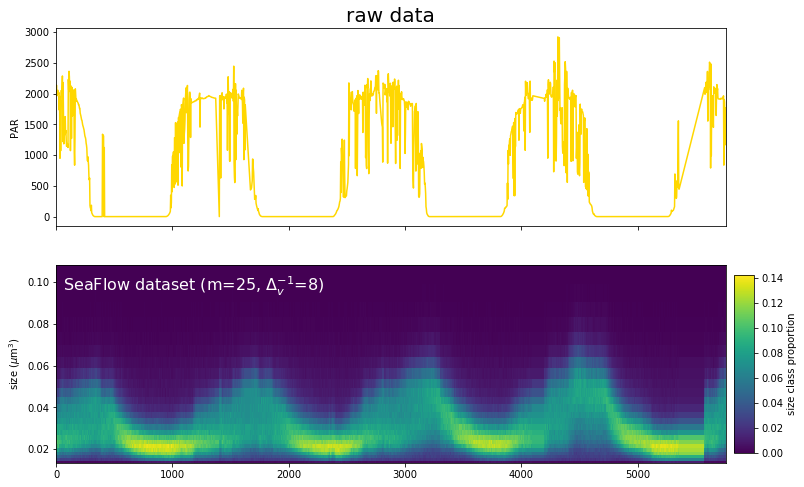

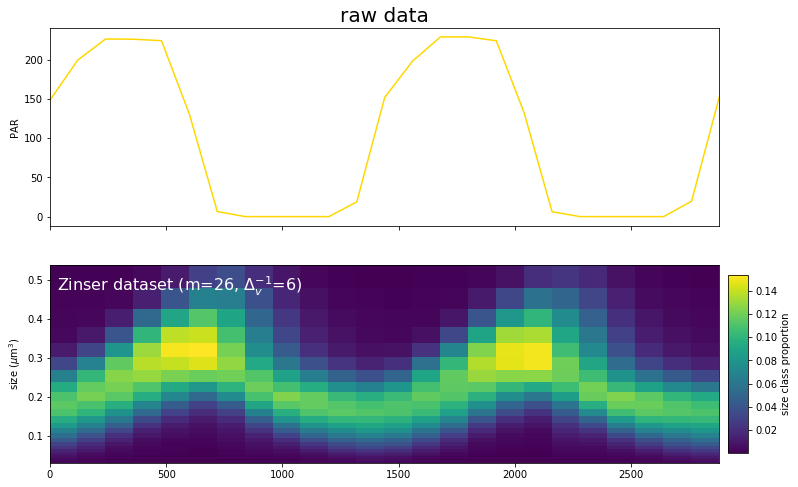

In [2]:
import matplotlib.pyplot as plt
import matplotlib as mpl
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

def add_colorbar(ax, **cbarargs):
    axins_cbar = inset_axes(ax, width='3%', height='90%', loc=5, bbox_to_anchor=(0.05,0.0,1,1), bbox_transform=ax.transAxes)
    mpl.colorbar.ColorbarBase(axins_cbar, orientation='vertical', **cbarargs)

for i,dataname in enumerate(data_gridded):
    nrows = 2
    fig,axs = plt.subplots(nrows=nrows, sharex=True, figsize=(12,4*nrows))
    axs[0].set_title('raw data', size=20)
    
    ax = axs[0]
    ax.plot(data_gridded[dataname]['time'], data_gridded[dataname]['PAR'], color='gold')
    ax.set(ylabel='PAR')

    v_min = data_gridded[dataname]['v_min']
    delta_v = 1.0/data_gridded[dataname]['delta_v_inv']
    v = v_min * 2**(np.arange(data_gridded[dataname]['m'])*delta_v) 
    
    ax = axs[1]
    pc = ax.pcolormesh(data_gridded[dataname]['time'],v,data_gridded[dataname]['w_obs'])
    ax.set(ylabel='size ($\mu$m$^3$)')
    ax.text(0.01, 0.95, desc[dataname], color='white', size=16, transform=ax.transAxes, ha='left', va='top')
    add_colorbar(ax, norm=pc.norm, cmap=pc.cmap, label='size class proportion')
axs[-1].set_xlabel=('time (minutes)')
None

## process data and plot it

In [3]:
# prepare data for Stan model

if 'data' not in globals():
    data = {}
if 'mcmcs' not in globals():
    mcmcs = {}
if 'models' not in globals():
    models = {}

for dataname in data_gridded:
    dt = 20 # in units of minutes
    
    data[dataname] = {'dt':dt}
    for v in ('m','v_min','delta_v_inv'):
        data[dataname][v] = data_gridded[dataname][v]

    if 'seaflow' in dataname:
        limit_days = 1
        
        # new: average SeaFlow data in hourly bins
        binsize = 60 # in minutes
        numbins = int(np.ceil(data_gridded[dataname]['time'][-1]/binsize))
        
        data[dataname]['obs'] = np.full((data[dataname]['m'],numbins), fill_value=np.nan)
        data[dataname]['t_obs'] = np.full(numbins, fill_value=np.nan)
        
        i = 0
        for ibin in range(numbins):
            binind = np.logical_and(data_gridded[dataname]['time'] >= ibin*binsize,
                                    data_gridded[dataname]['time'] < (ibin+1)*binsize)
            if np.any(binind):
                # TODO we may want to make this a sum when dealing with counts
                data[dataname]['obs'][:,i] = np.mean(data_gridded[dataname]['w_obs'][:,binind], axis=1)
                data[dataname]['t_obs'][i] = (ibin+0.5) * binsize
                i += 1
        
        data[dataname]['obs'] = data[dataname]['obs'][:,:i]
        data[dataname]['t_obs'] = data[dataname]['t_obs'][:i]
        
        # median filter PAR
        # see: medianfilter_par.ipynb
        n = len(data_gridded[dataname]['PAR'])
        wsh = 30 # half of median filter window size; window size is 2*wsh+1
        par = np.array([np.median(data_gridded[dataname]['PAR'][max(0,i-wsh):min(n,i+wsh+1)]) for i in range(n)])
    else:
        limit_days = 2
        
        data[dataname]['obs'] = data_gridded[dataname]['w_obs']
        data[dataname]['t_obs'] = data_gridded[dataname]['time']
        par = data_gridded[dataname]['PAR']
        
    if limit_days > 0:
        limit_minutes = limit_days*1440
        
        ind_obs = data[dataname]['t_obs'] < limit_minutes
        data[dataname]['t_obs'] = data[dataname]['t_obs'][ind_obs]
        data[dataname]['obs'] = data[dataname]['obs'][:,ind_obs]
        
        data[dataname]['nt'] = int(limit_minutes//data[dataname]['dt'])

    data[dataname]['nt_obs'] = data[dataname]['t_obs'].size
    
    # load cross-validation testing indices and add them to data
    data[dataname]['i_test'] = np.loadtxt(itestfiles[dataname]).astype(int)
    # remove last index, so that dimensions agree
    data[dataname]['i_test'] = data[dataname]['i_test'][:-1]
    
    # add light data
    t = np.arange(data[dataname]['nt'])*data[dataname]['dt']
    data[dataname]['E'] = np.interp(t, xp=data_gridded[dataname]['time'], fp=par)
    
    # for now, add pseudo-count data
    data[dataname]['obs_count'] = (1000*data[dataname]['obs']).astype(int)
    
    # consistency check
    if len(data[dataname]['i_test']) != data[dataname]['nt_obs']:
        raise ValueError('Invalid number of testing indices for "{}" (expected {}, got {}).'.format(dataname,data[dataname]['nt_obs'],len(data[dataname]['i_test'])))

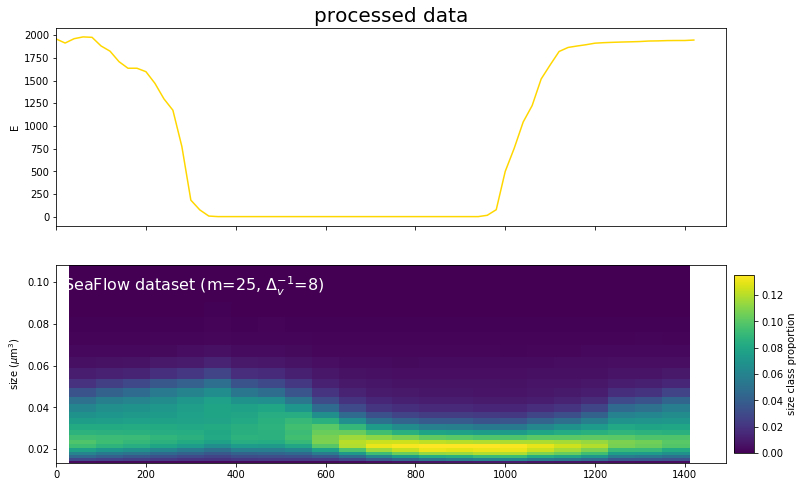

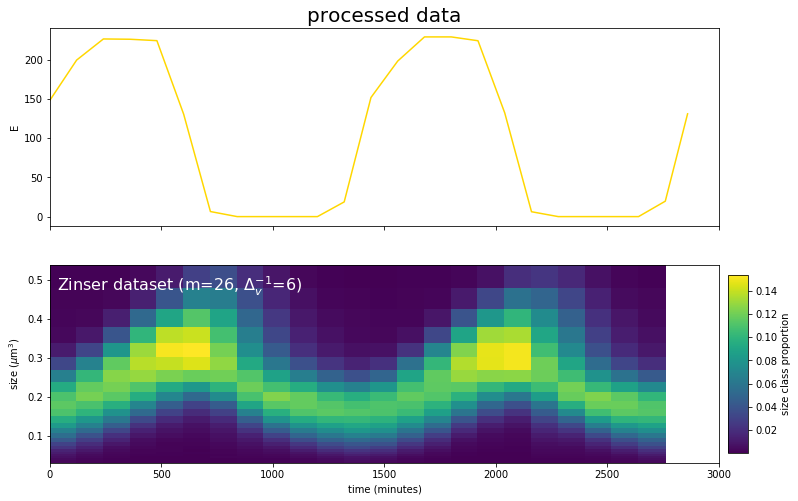

In [4]:
for i,dataname in enumerate(data):
    nrows = 2
    fig,axs = plt.subplots(nrows=nrows, sharex=True, figsize=(12,4*nrows))
    axs[0].set_title('processed data', size=20)
    
    ax = axs[0]
    t = np.arange(data[dataname]['nt'])*data[dataname]['dt']
    ax.plot(t, data[dataname]['E'], color='gold')
    ax.set(ylabel='E')

    v_min = data[dataname]['v_min']
    delta_v = 1.0/data[dataname]['delta_v_inv']
    v = v_min * 2**(np.arange(data[dataname]['m'])*delta_v) 
    
    ax = axs[1]
    pc = ax.pcolormesh(data[dataname]['t_obs'],v,data[dataname]['obs'])
    ax.set(ylabel='size ($\mu$m$^3$)')
    ax.text(0.01, 0.95, desc[dataname], color='white', size=16, transform=ax.transAxes, ha='left', va='top')
    add_colorbar(ax, norm=pc.norm, cmap=pc.cmap, label='size class proportion')
    ax.set_xlim(left=0.0)
axs[-1].set_xlabel('time (minutes)')

None

## run model

In [7]:
import pystan
refit_all = False
refit_required = {}

modelfiles = {
    'monodelta_respv2':'stancode/matrixmodel_estinilnorm_monodelta_respv2_normparam_trackgrowth_xval.stan',
    'monodelta_respv2_mn':'stancode/matrixmodel_multinom_estinilnorm_monodelta_respv2_normparam_trackgrowth_xval.stan',
    'monodelta_respv2_mlmn':'stancode/matrixmodel_mlmultinom_estinilnorm_monodelta_respv2_normparam_trackgrowth_xval.stan',
    #'monodelta_respv2_mn_lightsig':'stancode/matrixmodel_estinilnorm_monodelta-lightsig_respv2_normparam_trackgrowth_xval.stan',
    'monodelta_gammaiv6_mn':'stancode/matrixmodel_multinom_estinilnorm_monodelta_gammaiv6_normparam_trackgrowth_xval.stan',   
    'monodelta_respiv6_mn':'stancode/matrixmodel_multinom_estinilnorm_monodelta_respiv6_normparam_trackgrowth_xval.stan',   
    'monodelta_respiv6_mlmn':'stancode/matrixmodel_mlmultinom_estinilnorm_monodelta_respiv6_normparam_trackgrowth_xval.stan',   
    #'monodelta_respiv6_mn_lightsig':'stancode/matrixmodel_multinom_estinilnorm_monodelta-lightsig_respiv6_normparam_trackgrowth_xval.stan',   
    'monodelta_respiv7_mn':'stancode/matrixmodel_multinom_estinilnorm_monodelta_respiv7_normparam_trackgrowth_xval.stan',   
    'monodelta_respiv7_mlmn':'stancode/matrixmodel_mlmultinom_estinilnorm_monodelta_respiv7_normparam_trackgrowth_xval.stan',   
    #'monodelta_respiv7_mn_lightsig':'stancode/matrixmodel_multinom_estinilnorm_monodelta-lightsig_respiv7_normparam_trackgrowth_xval.stan',   
}
desc_model = {
    'monodelta_respv2':'respiration v2 (no size-dep), old fit (for comparison only)',
    'monodelta_respv2_mn':'respiration v2 (no size-dep), multinomial',
    'monodelta_respv2_mlmn':'respiration v2 (no size-dep), multilevel multinomial',
    'monodelta_respv2_mn_lightsig':'OLD: respiration v2 (no size-dep), light-dep div',
    'monodelta_gammaiv6_mn':'size-dep growth v6, no respiration, multinomial',
    'monodelta_respiv6_mn':'size-dep growth/resp v6, multinomial',
    'monodelta_respiv6_mlmn':'size-dep growth/resp v6, multilevel multinomial',
    'monodelta_respiv6_mn_lightsig':'size-dep growth/resp v6, multinomial, light-dep div',
    'monodelta_respiv7_mn':'size-dep growth/resp v7, multinomial',
    'monodelta_respiv7_mlmn':'size-dep growth/resp v7, multilevel multinomial',
    'monodelta_respiv7_mn_lightsig':'size-dep growth/resp v7, multinomial, light-dep div',
}

for name in modelfiles:
    with open(modelfiles[name]) as f: 
        stan_code = f.read()
    refit_required[name] = True
    if name in models and models[name].model_code == stan_code:
        print('{}: unchanged code, not recompiling'.format(name))
        refit_required[name] = False
    else:
        if name in models:
            print('{}: code change detected, recompiling'.format(name))
        else:
            print('{}: compiling'.format(name))
        models[name] = pystan.StanModel(file=modelfiles[name], model_name=name, obfuscate_model_name=False)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL monodelta_gammaiv6_mn NOW.


monodelta_respv2: unchanged code, not recompiling
monodelta_respv2_mn: unchanged code, not recompiling
monodelta_respv2_mlmn: unchanged code, not recompiling
monodelta_gammaiv6_mn: code change detected, recompiling
monodelta_respiv6_mn: unchanged code, not recompiling
monodelta_respiv6_mlmn: unchanged code, not recompiling
monodelta_respiv7_mn: unchanged code, not recompiling
monodelta_respiv7_mlmn: unchanged code, not recompiling


In [9]:
def get_max_rhat(fit):
    s = fit.summary()
    irhat = s['summary_colnames'].index("Rhat")
    return np.nanmax(s['summary'][:,irhat])

if 'maxrhats' not in globals():
    maxrhats = {}

try_again = False

# run a bunch of experiments -- this may take a while
for name in models:
    if name not in maxrhats:
        maxrhats[name] = {}
    for dataname in data:
        if dataname not in maxrhats[name]:
            maxrhats[name][dataname] = []
        if name in mcmcs:
            if dataname in mcmcs[name] and not refit_all and not refit_required[name]:
                print('{} ({})'.format(name, desc_model[name])) 
                print('\n'.join(x for x in mcmcs[name][dataname].__str__().split('\n') if 'mod_obspos' not in x and 'theta' not in x and 'w_ini' not in x and 'incr' not in x))
                rhat_max = get_max_rhat(mcmcs[name][dataname])
                if try_again and rhat_max >= 1.1:
                    print('{}: found Rhat={:.3f}, trying again'.format(name,rhat_max))
                else:
                    continue
        else:
            mcmcs[name] = {}
        for itry in range(3):
            mcmcs[name][dataname] = models[name].sampling(data=data[dataname], iter=2000)
            # get max Rhat
            rhat_max = get_max_rhat(mcmcs[name][dataname])
            maxrhats[name][dataname].append(rhat_max)
            if rhat_max < 1.1:
                break
            print('{}: in try {}/3 found Rhat={:.3f}, trying again'.format(name,itry+1,rhat_max))
        print('{} ({})'.format(name, desc_model[name])) 
        print('\n'.join(x for x in mcmcs[name][dataname].__str__().split('\n') if 'mod_obspos' not in x and 'theta' not in x and 'w_ini' not in x and 'incr' not in x))

monodelta_respv2 (respiration v2 (no size-dep), old fit (for comparison only))
Inference for Stan model: monodelta_respv2.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

                     mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
delta_lambda         1.14  8.5e-3   0.41   0.51   0.84   1.08   1.38   2.11   2311    1.0
gamma_max            2.13    0.02   0.65   1.36   1.68   1.92   2.46    3.8   1762    1.0
respiration          0.28  3.1e-3   0.13   0.03   0.18   0.28   0.37   0.53   1724    1.0
E_star             978.42   19.74 814.53   18.1 301.35 785.05 1473.0 2883.8   1702    1.0
sigma                0.08  9.1e-5 5.4e-3   0.07   0.07   0.08   0.08   0.09   3521    1.0
divrate              0.64  2.3e-3    0.1   0.45   0.56   0.63   0.71   0.85   1980    1.0
delta_max[1]         0.16  2.8e-3   0.13 4.6e-3   0.05   0.13   0.23   0.51   2327    1.0
delta_max[2]         0.57  6.4e-3   0.2

monodelta_respv2_mn (respiration v2 (no size-dep), multinomial)
Inference for Stan model: monodelta_respv2_mn.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

                     mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
delta_lambda         1.53  6.1e-3   0.36   0.91   1.26   1.49   1.75   2.32   3483    1.0
gamma_max            4.25  1.8e-3   0.09   4.09   4.19   4.25   4.31   4.43   2392    1.0
respiration          1.56  8.5e-4   0.05   1.47   1.53   1.56   1.59   1.65   2940    1.0
E_star              55.13    0.17   7.81  42.43  49.48  54.15  59.86  72.73   2097    1.0
divrate              0.74  5.2e-4   0.04   0.67   0.71   0.74   0.76   0.81   5341    1.0
delta_max[1]         0.07  5.2e-4   0.02   0.02   0.06   0.07   0.09   0.12   2155    1.0
delta_max[2]          0.1  2.6e-4   0.02   0.06   0.09    0.1   0.11   0.13   4443    1.0
delta_max[3]         0.12  2.0e-4   0.01   0.09   0

monodelta_gammaiv6_mn (size-dep growth v6, no respiration, multinomial)
Inference for Stan model: monodelta_gammaiv6_mn.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

                     mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
delta_lambda         0.32  3.3e-3    0.1   0.17   0.25    0.3   0.37   0.54    809    1.0
gamma_max            1.26  1.8e-3   0.06   1.15   1.22   1.25   1.29   1.37    918    1.0
xi                   0.03  3.0e-3    0.1  -0.17  -0.04   0.03    0.1   0.22   1071    1.0
E_star              15.07    2.98  43.18   0.09   0.83   1.74   6.64  97.56    210   1.02
divrate              0.76  1.1e-3   0.03    0.7   0.74   0.76   0.77   0.81    591   1.01
delta_max[1]         0.19  8.1e-4   0.02   0.15   0.17   0.19   0.21   0.24    855    1.0
delta_max[2]         1.21  3.4e-3   0.08   1.05   1.16   1.21   1.27   1.39    580   1.01
delta_max[3]         1.52  3.7e-3    0.1 

monodelta_gammaiv6_mn: in try 1/3 found Rhat=1834.703, trying again


monodelta_gammaiv6_mn (size-dep growth v6, no respiration, multinomial)
Inference for Stan model: monodelta_gammaiv6_mn.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

                     mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
delta_lambda         0.84  3.3e-3   0.19   0.51    0.7   0.83   0.96   1.25   3118    1.0
gamma_max           22.97    0.61   15.4   7.57  11.28  17.16  30.56  63.98    630    1.0
xi                   -0.9  2.0e-3    0.1  -1.09  -0.97   -0.9  -0.83   -0.7   2481    1.0
E_star             886.39   27.19 675.29 208.08 372.51 632.28 1221.6 2679.8    617    1.0
divrate              1.68  8.0e-4   0.04   1.61   1.66   1.68   1.71   1.77   2484    1.0
delta_max[1]         0.26  9.2e-4   0.04   0.17   0.23   0.26   0.29   0.34   2298    1.0
delta_max[2]         0.31  7.0e-4   0.04   0.24   0.29   0.31   0.33   0.38   2539    1.0
delta_max[3]         0.34  5.3e-4   0.03 

monodelta_respiv6_mn: in try 1/3 found Rhat=1.411, trying again


monodelta_respiv6_mn: in try 2/3 found Rhat=640.256, trying again


monodelta_respiv6_mn (size-dep growth/resp v6, multinomial)
Inference for Stan model: monodelta_respiv6_mn.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

                     mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
delta_lambda         3.08    0.01    0.7   1.86   2.59   3.04   3.51   4.59   4238    1.0
gamma_max            5.63  4.1e-3   0.21   5.27   5.48   5.61   5.75    6.1   2687    1.0
xi                  -1.26  1.2e-3   0.07  -1.41  -1.31  -1.26  -1.21  -1.11   3890    1.0
xir                  0.35  1.3e-3   0.08   0.19    0.3   0.35   0.41   0.51   4119    1.0
respiration          1.81  1.1e-3   0.07   1.68   1.76   1.81   1.86   1.94   3567    1.0
E_star              81.63     0.2  11.74  62.14   73.0  80.53  89.12 106.93   3438    1.0
divrate              0.54  4.2e-4   0.03   0.49   0.52   0.54   0.56    0.6   4533    1.0
delta_max[1]          0.1  5.9e-4   0.03   0.04   0.08

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


monodelta_respiv6_mlmn: in try 1/3 found Rhat=1.760, trying again


To run all diagnostics call pystan.check_hmc_diagnostics(fit)


monodelta_respiv6_mlmn: in try 2/3 found Rhat=1.441, trying again


To run all diagnostics call pystan.check_hmc_diagnostics(fit)


monodelta_respiv6_mlmn: in try 3/3 found Rhat=1.239, trying again
monodelta_respiv6_mlmn (size-dep growth/resp v6, multilevel multinomial)
Inference for Stan model: monodelta_respiv6_mlmn.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

                     mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
delta_lambda         1.65    0.06   0.45   0.88   1.34   1.59    1.9   2.75     60   1.08
gamma_max            1.37    0.05   0.25   1.14   1.25   1.31    1.4   2.34     28   1.15
xi                 4.5e-3    0.01    0.1  -0.19  -0.06 9.0e-3   0.07   0.19     88   1.07
xir               -6.0e-3    0.01    0.1  -0.21  -0.07-5.9e-3   0.06   0.19     93   1.02
respiration          0.02  2.9e-3   0.01 6.8e-4 6.4e-3   0.01   0.03   0.05     20   1.13
E_star             302.96  101.51 507.66   1.45  24.86  78.21 351.11 2035.3     25   1.22
sigma              527.88   13.59  84.86 387.35 463.09 521.56 5

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


monodelta_respiv6_mlmn (size-dep growth/resp v6, multilevel multinomial)
Inference for Stan model: monodelta_respiv6_mlmn.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

                     mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
delta_lambda         2.65    0.02   0.61   1.62   2.22    2.6   3.02   4.01   1307    1.0
gamma_max            4.98    0.02   0.35   4.48   4.75   4.92   5.13   5.85    362   1.01
xi                  -0.72  3.1e-3    0.1   -0.9  -0.78  -0.72  -0.65  -0.52    952    1.0
xir                  0.19  3.3e-3    0.1 3.1e-3   0.12   0.19   0.26    0.4    946    1.0
respiration           1.6  4.0e-3    0.1   1.42   1.54    1.6   1.67    1.8    596   1.01
E_star              85.41    1.23  23.16  52.85  70.07   81.5  95.64 144.91    357   1.01
sigma              581.95    4.24   85.7 429.84 522.56 575.13  634.9 772.17    408   1.01
divrate              0.58  1.4e-3   0.0

monodelta_respiv7_mn (size-dep growth/resp v7, multinomial)
Inference for Stan model: monodelta_respiv7_mn.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

                     mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
delta_lambda         0.31  3.9e-3   0.09   0.17   0.24    0.3   0.36   0.53    562   1.01
gamma_max            1.31  2.1e-3   0.05    1.2   1.27    1.3   1.34   1.42    670    1.0
xi                   0.03  3.2e-3    0.1  -0.16  -0.03   0.03    0.1   0.22    953    1.0
xir                1.4e-3  2.9e-3    0.1  -0.19  -0.07-5.7e-4   0.07    0.2   1158    1.0
respiration          0.11  7.7e-4   0.02   0.07    0.1   0.11   0.12   0.15    700    1.0
E_star               9.28    0.85  19.81   0.08   0.84   1.79   4.45  69.52    543    1.0
divrate              0.68  9.5e-4   0.03   0.62   0.66   0.68   0.69   0.73    782    1.0
delta_max[1]         0.02  7.4e-4   0.02 8.7e-4 8.5e-3

monodelta_respiv7_mn: in try 1/3 found Rhat=1441.191, trying again


monodelta_respiv7_mn: in try 2/3 found Rhat=3299.997, trying again


monodelta_respiv7_mn: in try 3/3 found Rhat=2940.844, trying again
monodelta_respiv7_mn (size-dep growth/resp v7, multinomial)
Inference for Stan model: monodelta_respiv7_mn.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

                     mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
delta_lambda         2.49    0.31   0.63   1.37   1.98   2.45   3.21   3.37      4   1.36
gamma_max            23.7   19.72  27.89   6.83   7.32   7.71  44.89   72.0      2  61.65
xi                  -1.61    0.35    0.5  -2.48   -2.1  -1.36  -1.28  -1.14      2   6.44
xir                 -1.59     2.5   3.53   -7.7  -4.19   0.41    0.5   0.63      2  44.43
respiration          1.29    0.49   0.69    0.1   0.69   1.65   1.73   1.85      2   9.88
E_star             1074.9  1172.1 1658.1  85.96 106.52 122.95 2295.2 3946.7      2  91.14
divrate              0.87    0.28    0.4   0.57   0.63   0.66   1.21   1.56  

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


monodelta_respiv7_mlmn: in try 1/3 found Rhat=1.511, trying again


To run all diagnostics call pystan.check_hmc_diagnostics(fit)


monodelta_respiv7_mlmn: in try 2/3 found Rhat=1.754, trying again


To run all diagnostics call pystan.check_hmc_diagnostics(fit)


monodelta_respiv7_mlmn: in try 3/3 found Rhat=1.620, trying again
monodelta_respiv7_mlmn (size-dep growth/resp v7, multilevel multinomial)
Inference for Stan model: monodelta_respiv7_mlmn.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

                     mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
delta_lambda         1.65    0.04   0.36   1.08   1.41   1.61   1.86   2.47     85   1.05
gamma_max            1.45    0.11    0.3   1.13   1.26   1.35   1.53   2.27      7   1.55
xi                   0.03    0.01    0.1  -0.14  -0.05   0.02   0.09   0.24     58   1.07
xir               -4.9e-3  9.6e-3   0.09  -0.18  -0.07-6.3e-3   0.06   0.18     93   1.06
respiration          0.04  9.7e-3   0.03 5.3e-3   0.02   0.04   0.06   0.11      8    1.3
E_star             421.62  217.96 563.38   1.16  34.36 115.76 717.73 1842.4      7   1.62
sigma              532.45   17.92  73.55 408.05 475.64  532.9 5

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


monodelta_respiv7_mlmn (size-dep growth/resp v7, multilevel multinomial)
Inference for Stan model: monodelta_respiv7_mlmn.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

                     mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
delta_lambda         2.02  9.2e-3    0.5   1.19   1.67   1.97   2.32   3.11   2943    1.0
gamma_max           21.79    0.68  17.13   5.46   7.29  14.68   33.4   62.2    629   1.01
xi                  -0.42  1.9e-3   0.11  -0.63  -0.49  -0.42  -0.35  -0.21   3071    1.0
xir                   0.1  1.9e-3    0.1   -0.1   0.04    0.1   0.17    0.3   2769    1.0
respiration          1.08  3.5e-3   0.11   0.85   1.01   1.08   1.16    1.3   1061    1.0
E_star             853.09   31.31 780.16  93.29 193.39 541.62 1391.1 2702.0    621   1.01
sigma              273.38    1.04   33.9 213.72 249.98 270.86 295.22 347.43   1065    1.0
divrate              0.83  1.8e-3   0.0

## plot the results

In [10]:
mpl.rcParams['axes.labelsize'] = 20
mpl.rcParams['legend.fontsize'] = 16
mpl.rcParams['axes.titlesize'] = 26
mpl.rcParams['figure.figsize'] = (24,12)
mpl.rcParams['xtick.labelsize'] = 16
mpl.rcParams['ytick.labelsize'] = 16

maxrhats_final = {name:{dataname:get_max_rhat(mcmcs[name][dataname]) for dataname in data} for name in mcmcs}        

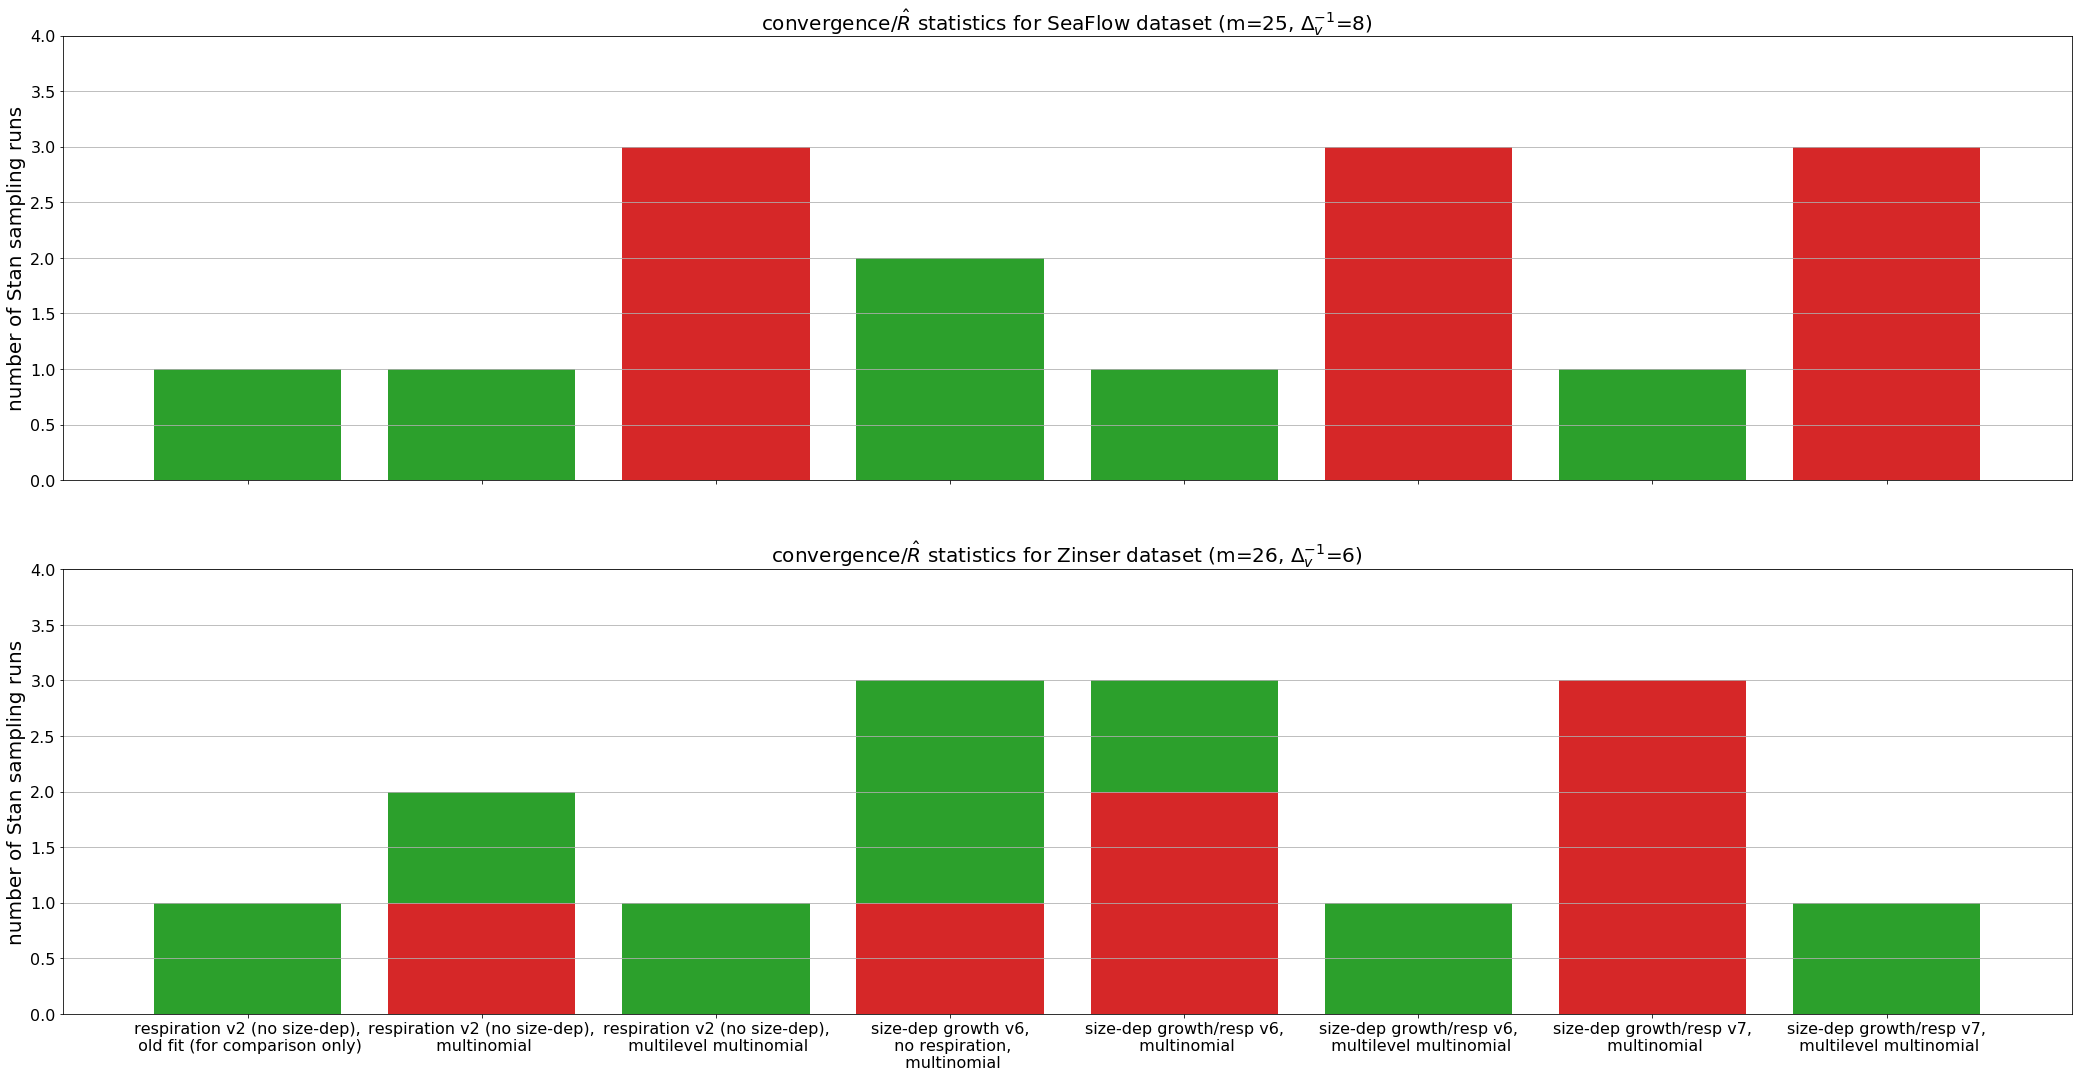

In [11]:
ylim_top = 0
for dataname in data:
    for name in mcmcs:
        ylim_top = max(ylim_top, len(maxrhats[name][dataname]))
ylim_top += 1

fig, axs = plt.subplots(nrows=len(data), figsize=(max(24,len(mcmcs)*4.5),len(data)*9), sharex=True, sharey=True)
for ax,dataname in zip(axs.flat,data):
    xticks = []
    xticklabels = []
    for i,name in enumerate(mcmcs):
        
        height_bad = sum(rh > 1.1 for rh in maxrhats[name][dataname])
        height_good = len(maxrhats[name][dataname]) - height_bad
        
        x = i
        ax.bar(x=x, height=height_bad, color='tab:red', label='max $\\\\hat{R}$ > 1.1')
        ax.bar(x=x, height=height_good, bottom=height_bad, color='tab:green', label='max $\\hat{R} \le$ 1.1')
        xticks.append(x)
        xticklabels.append(desc_model[name].replace(',',',\n'))
    
    ax.set(ylabel='number of Stan sampling runs', xticks=xticks, ylim=(0, ylim_top))
    ax.set_title('convergence/$\hat{R}$ statistics for '+desc[dataname], size=20)
    ax.set_xticklabels(xticklabels)#, rotation=8)
    ax.grid(axis='y')

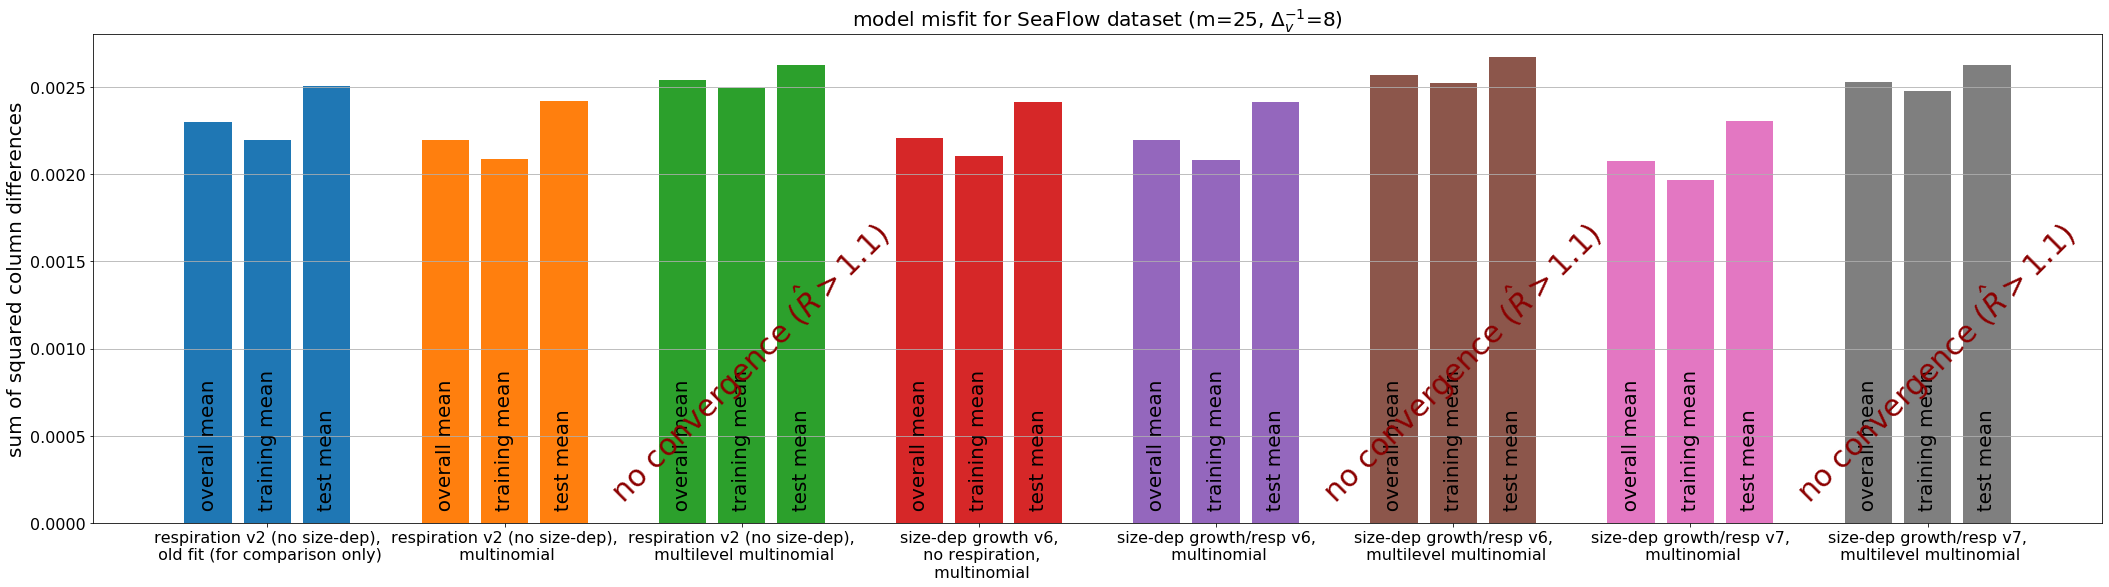

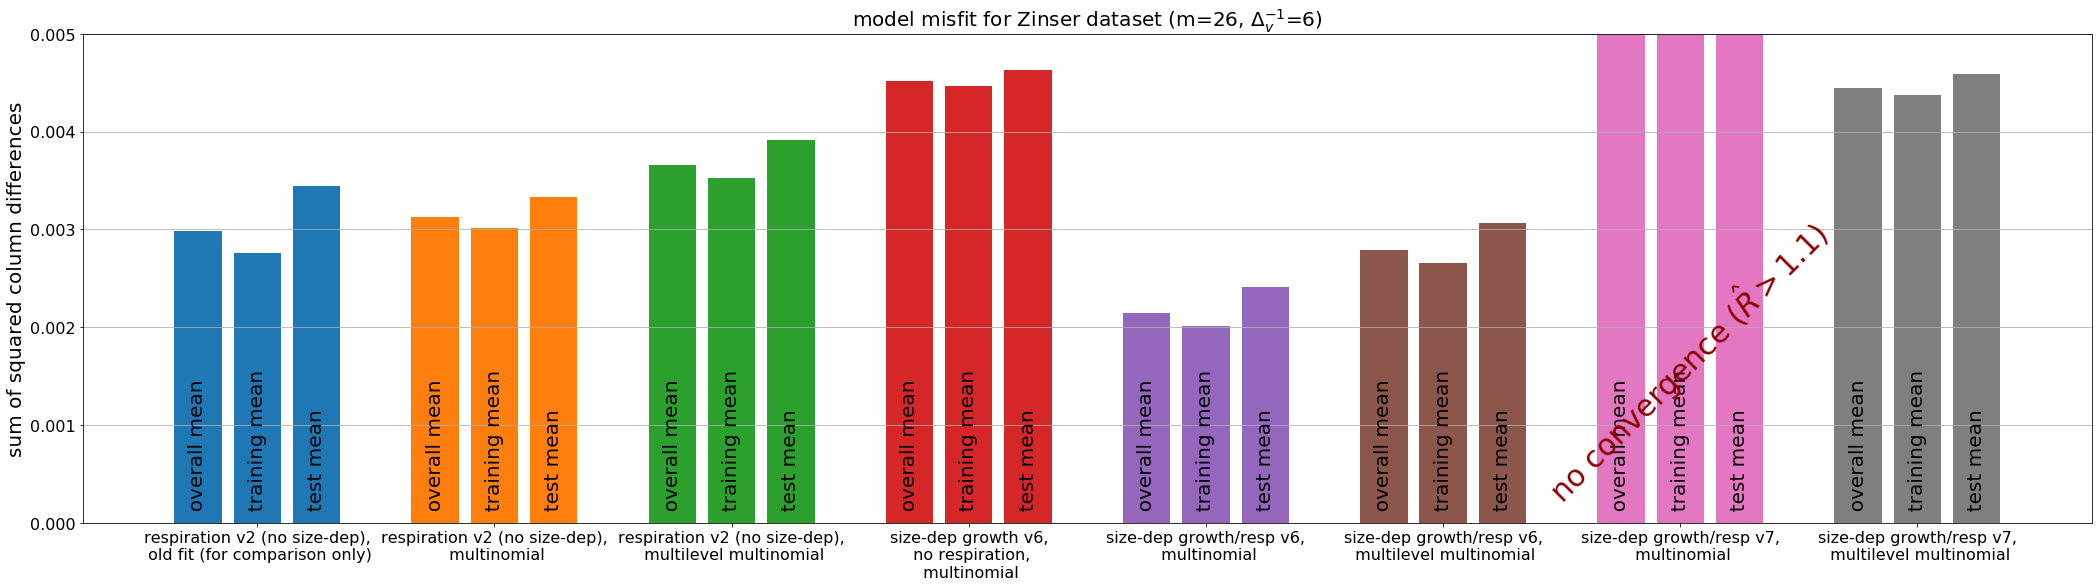

In [12]:
height = np.zeros(3)
for dataname in data:
    obs = data[dataname]['obs']
    
    fig, ax = plt.subplots(figsize=(max(24,len(mcmcs)*4.5),9))
    xticks = []
    xticklabels = []
    for i,name in enumerate(mcmcs):
        mod_mean = np.mean(mcmcs[name][dataname]['mod_obspos'], axis=0)
        mod_mean /= np.sum(mod_mean, axis=0)
        
        e = np.sum((mod_mean-obs)**2,axis=0)
        #print(desc_model[name],e)
        
        height[0] = np.mean(e)
        height[1] = np.mean(e[data[dataname]['i_test'] == 0])
        height[2] = np.mean(e[data[dataname]['i_test'] == 1])
        
        x = 4*i+np.arange(3)
        ax.bar(x=x, height=height)
        for xx,text in zip(x,['overall mean','training mean','test mean']):
            ax.text(xx, 0, '  '+text, rotation=90, ha='center', va='bottom', size=20)
        if maxrhats_final[name][dataname] > 1.1:
            ax.text(x[1], 0, '  no convergence ($\\hat{R}>1.1$)', rotation=45, ha='center', va='bottom', size=30, color='darkred')
        xticks.append(x[1])
        xticklabels.append(desc_model[name].replace(',',',\n'))
    
    if ax.get_ylim()[1] > 0.005:
        ax.set_ylim(top=0.005)
    ax.set(ylabel='sum of squared column differences', xticks=xticks)
    ax.set_title('model misfit for '+desc[dataname], size=20)
    ax.set_xticklabels(xticklabels)#, rotation=8)
    ax.grid(axis='y')

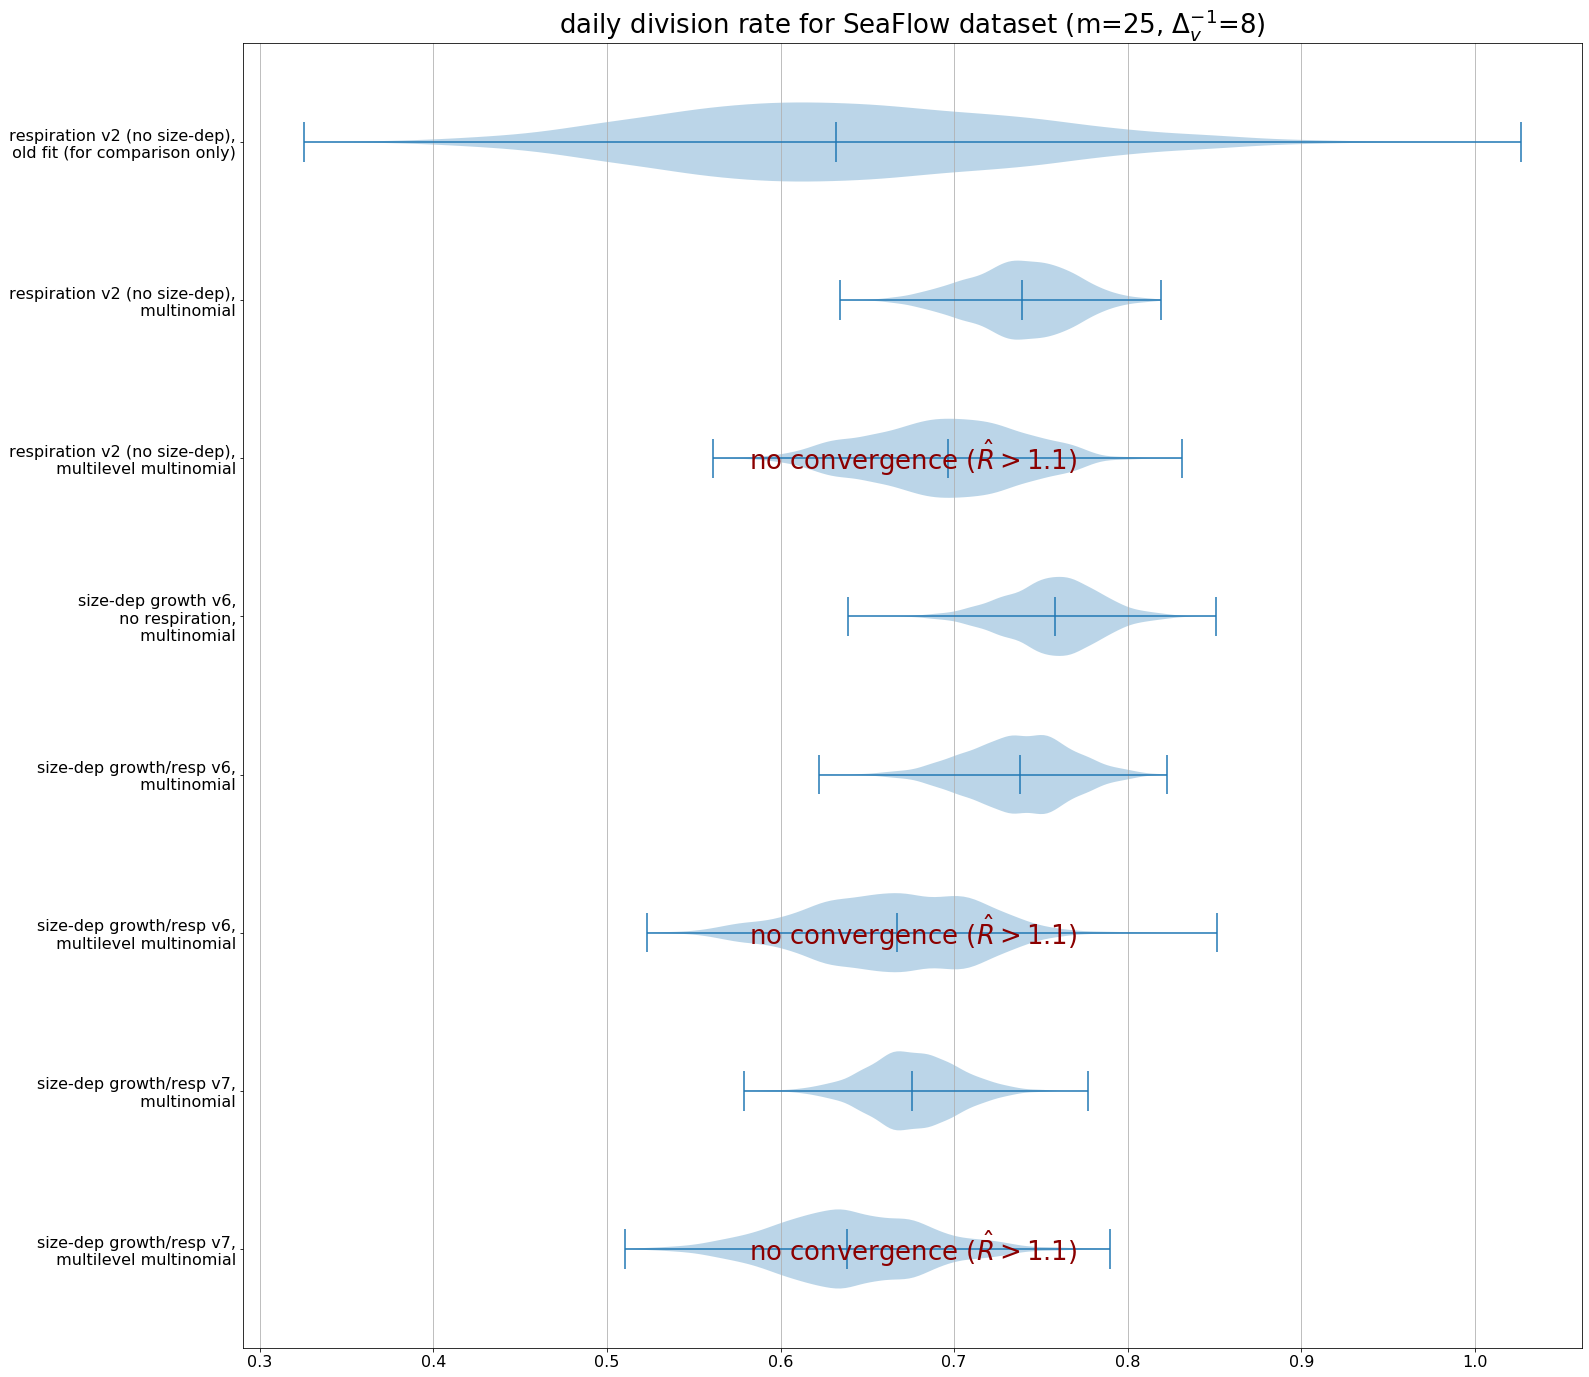

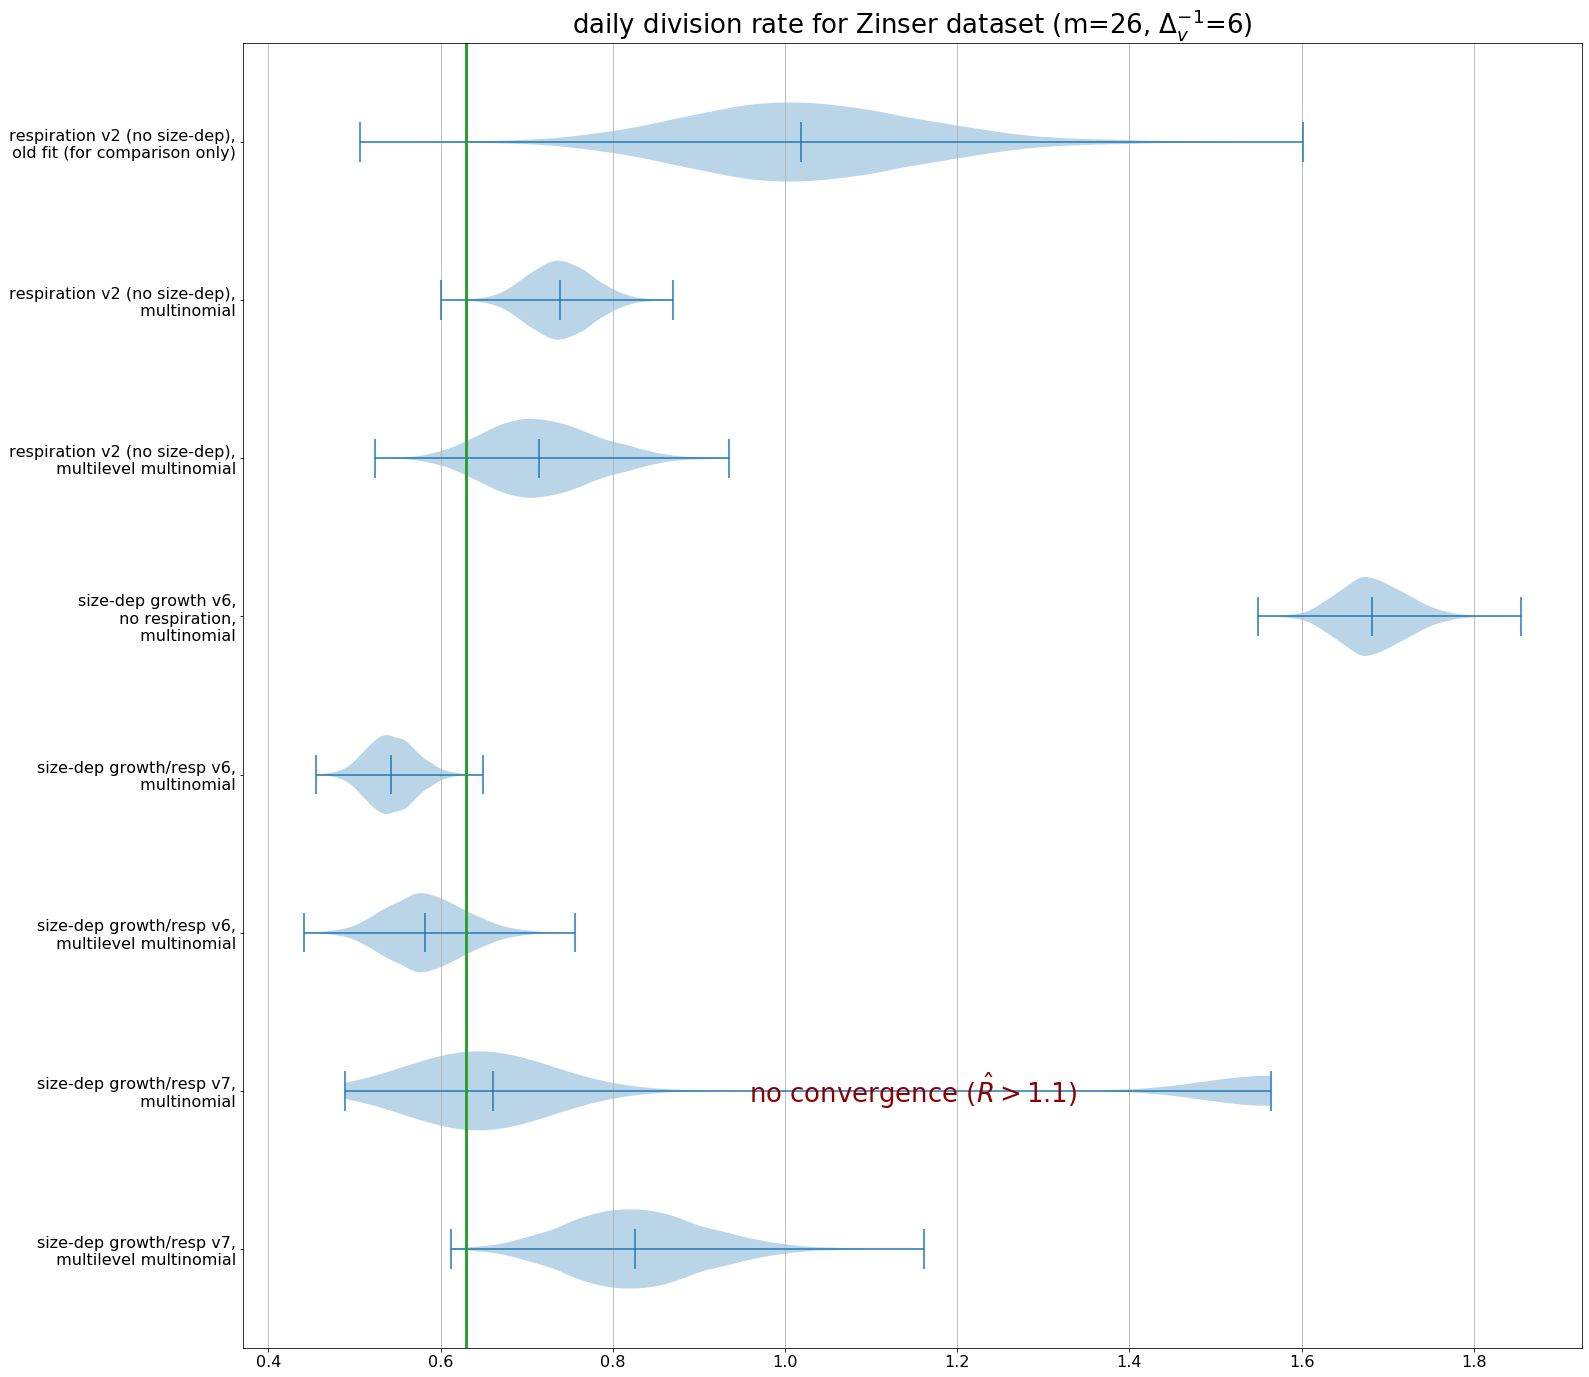

In [13]:
for dataname in data:
    num_mcmcs = len(mcmcs)
    fig, ax = plt.subplots(figsize=(24,3*num_mcmcs))
    ax.set_title('daily division rate for '+desc[dataname])
    ax.violinplot([mcmcs[name][dataname]['divrate'] for name in mcmcs], showmedians=True, vert=False)
    ax.invert_yaxis()
    ax.grid(axis='x')
    ax.set(yticks=np.arange(1,num_mcmcs+1), yticklabels=[desc_model[name].replace(',',',\n') for name in mcmcs])
    if 'zinser' in dataname:
        ax.axvline(0.63, color='tab:green', lw=3)
    for i,name in enumerate(mcmcs):
        if maxrhats_final[name][dataname] > 1.1:
            ax.text(0.5, i+1, 'no convergence ($\\hat{R}>1.1$)', color='darkred', size=26, transform=ax.get_yaxis_transform(), ha='center', va='center')

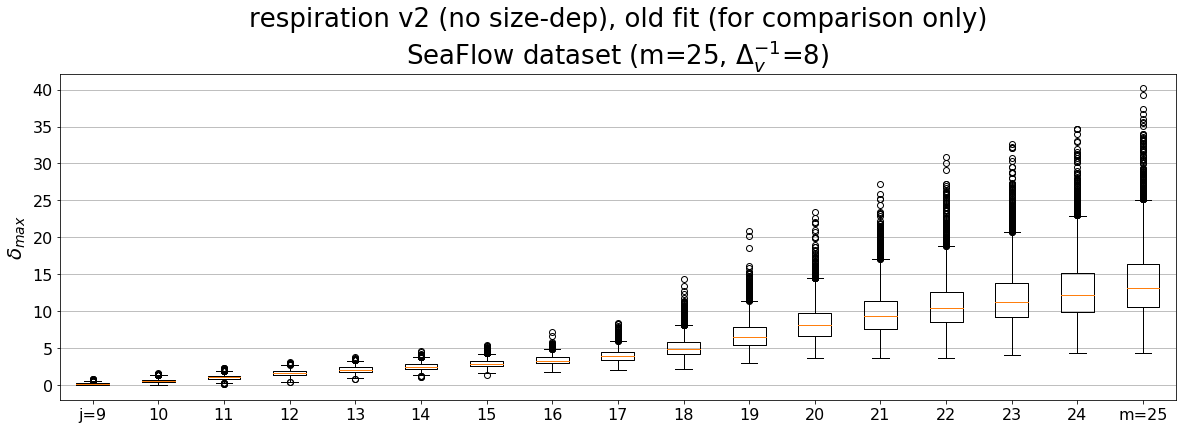

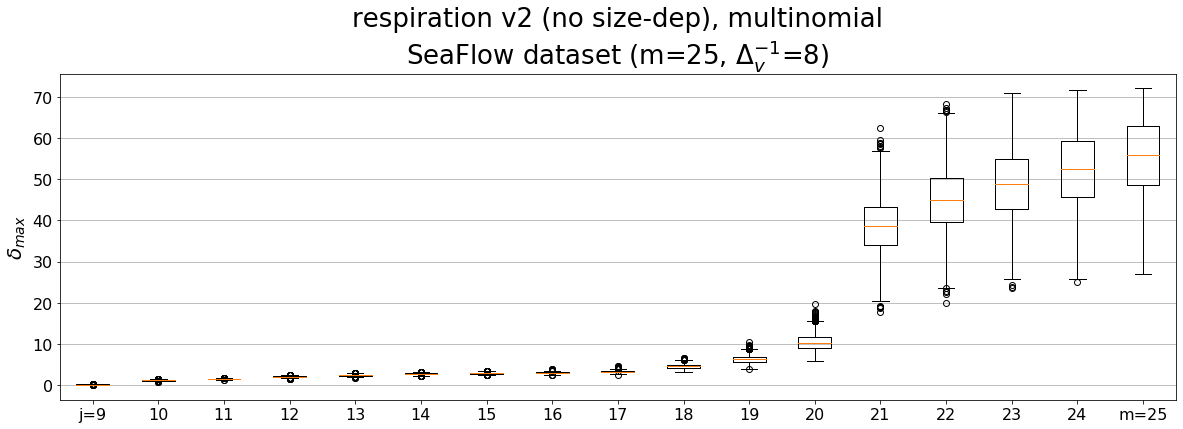

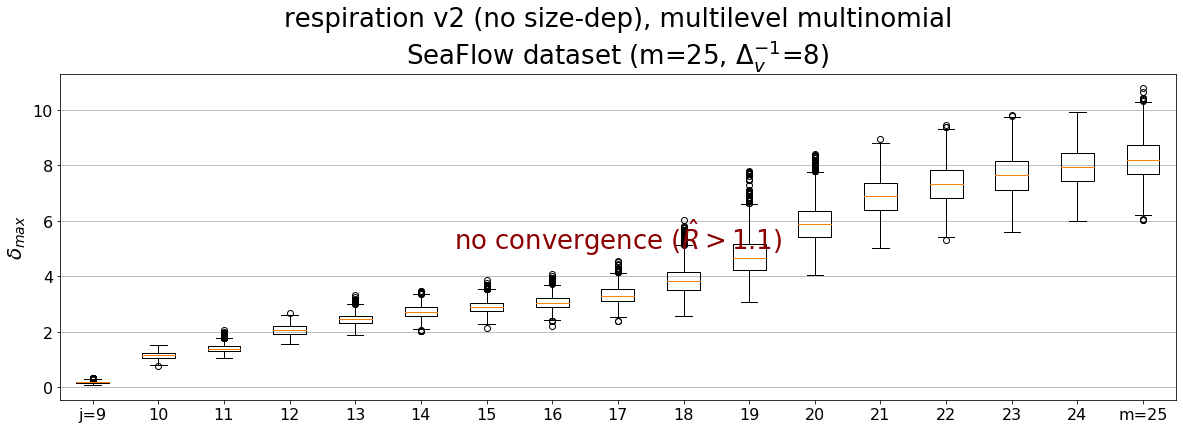

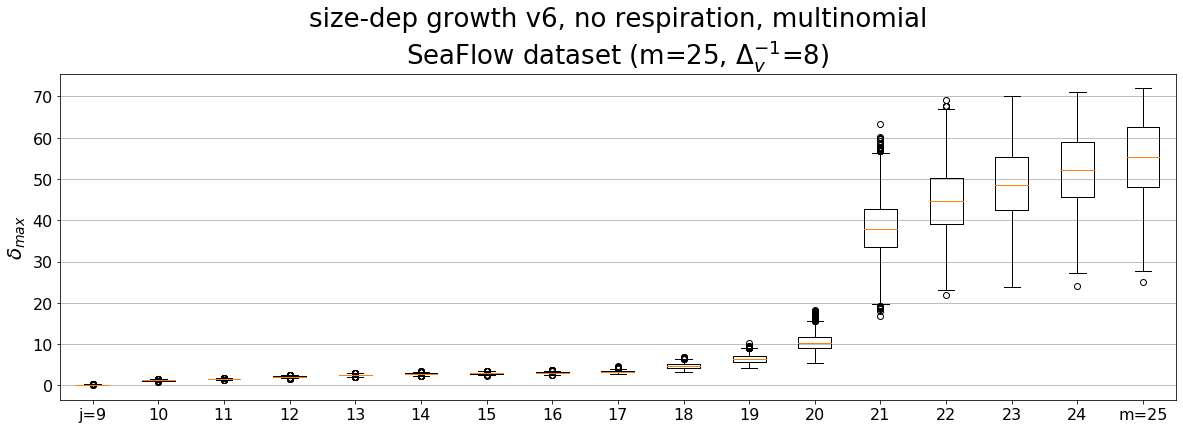

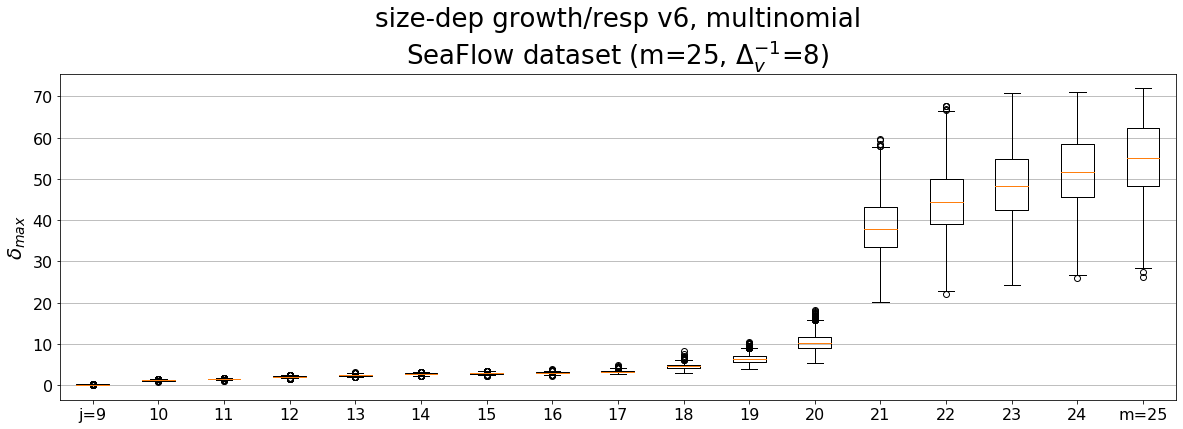

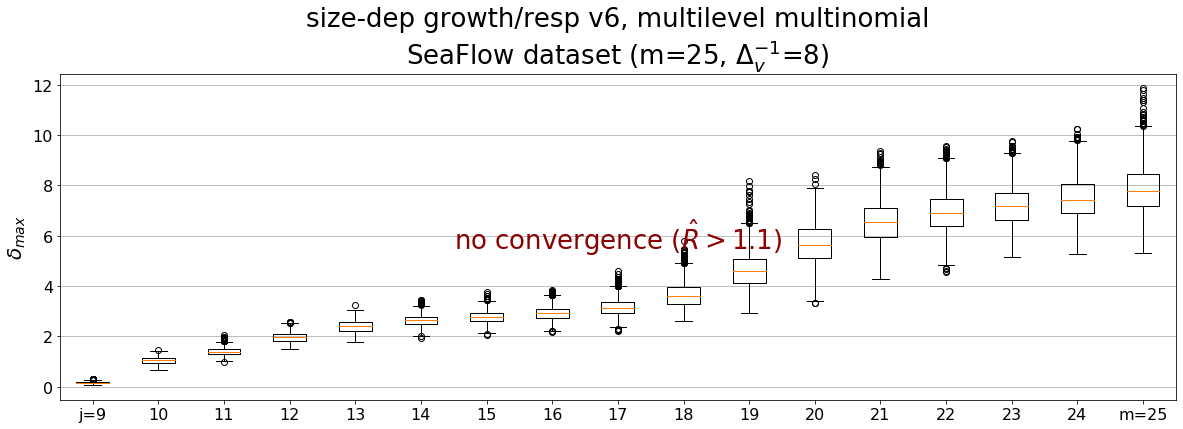

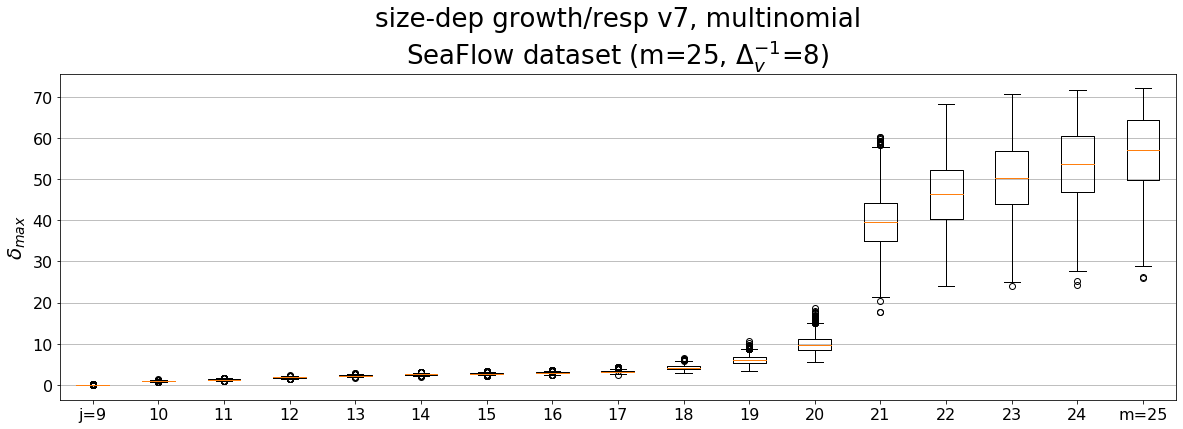

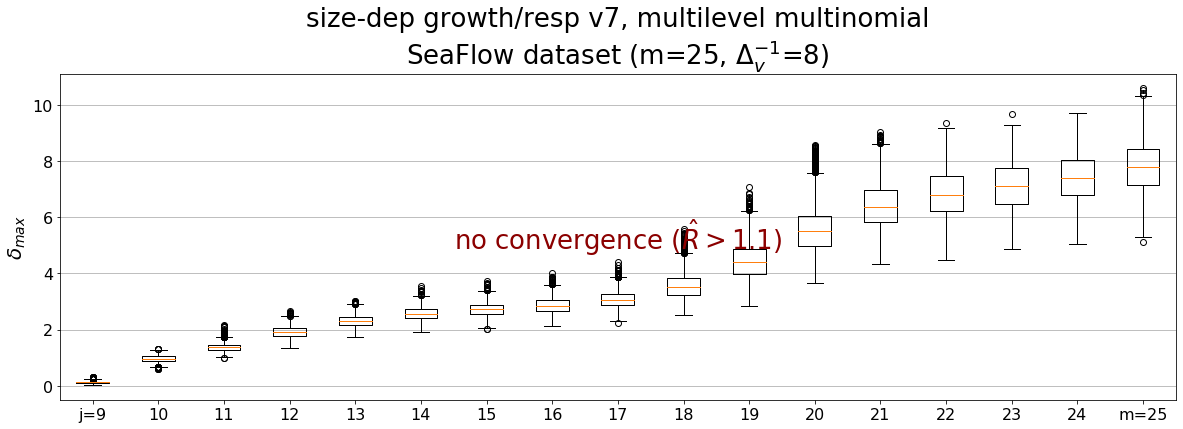

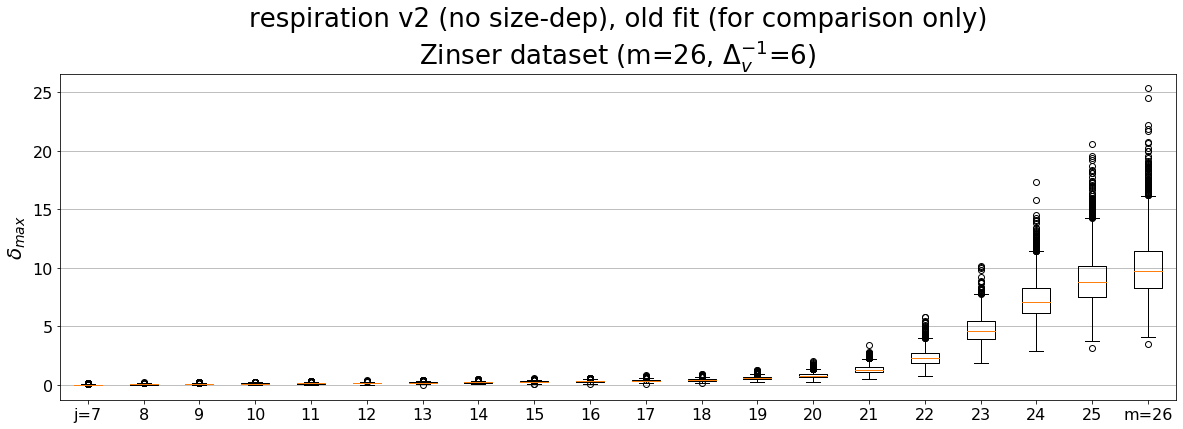

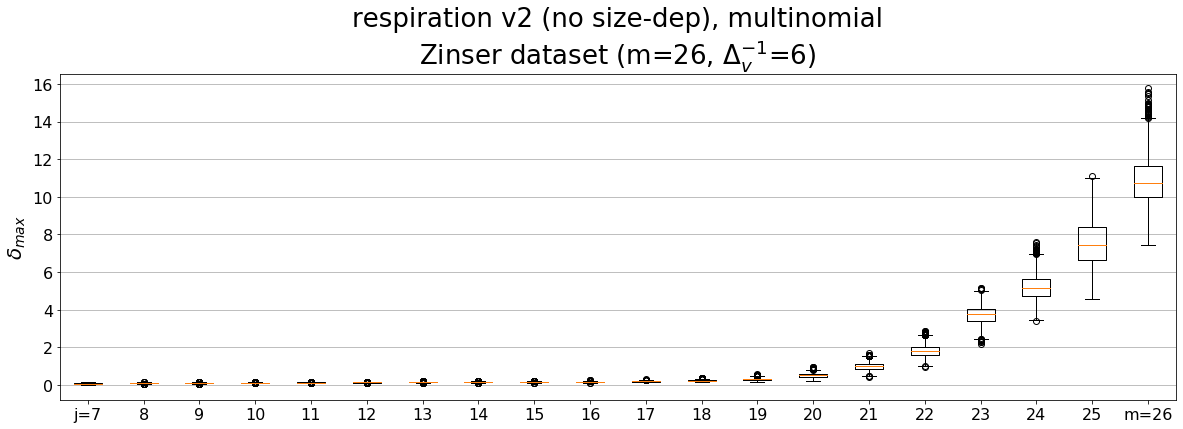

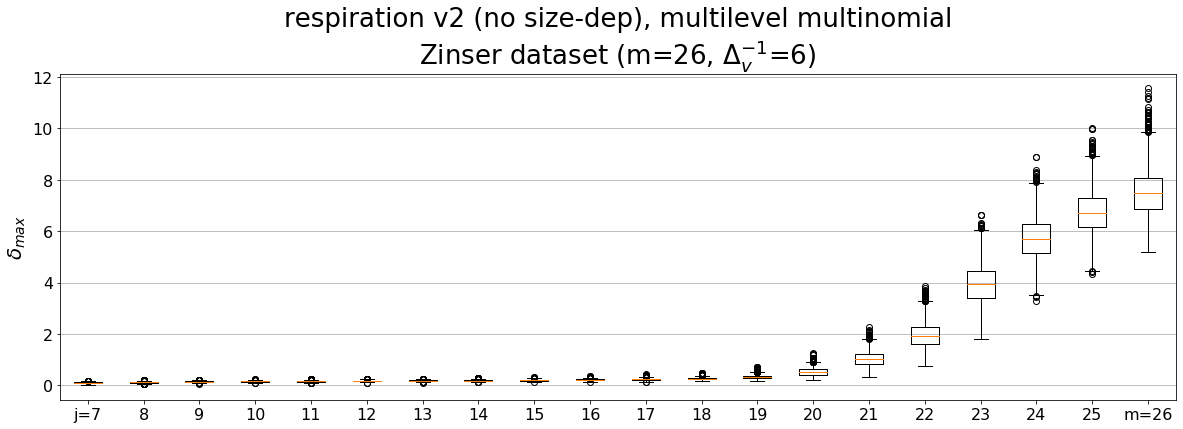

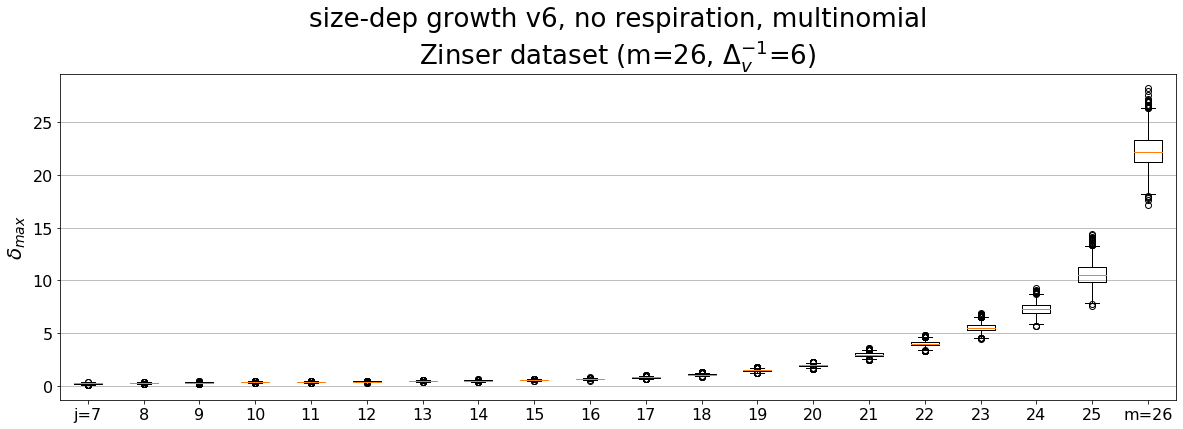

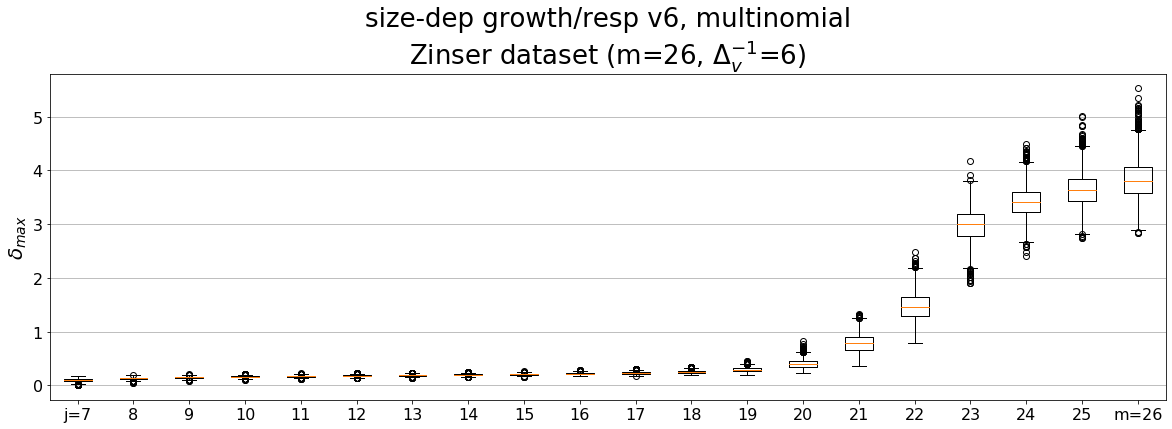

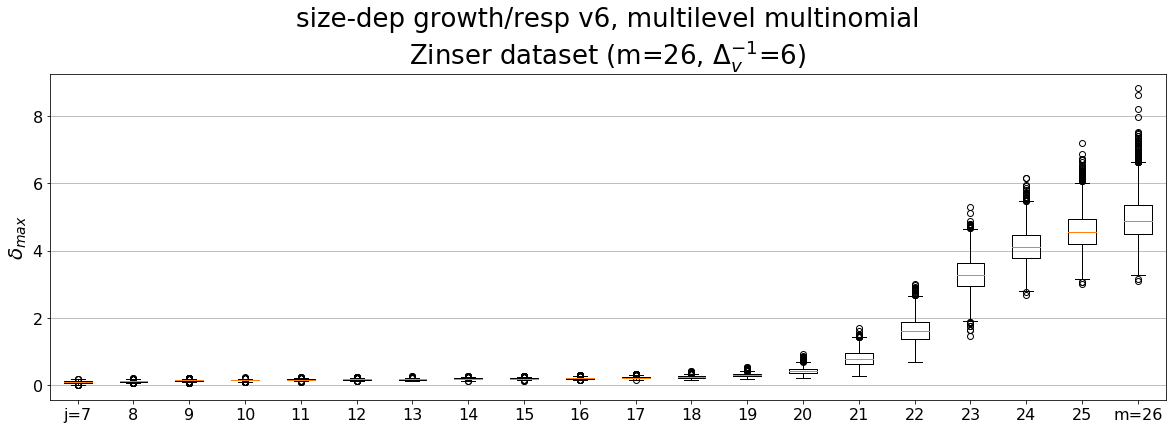

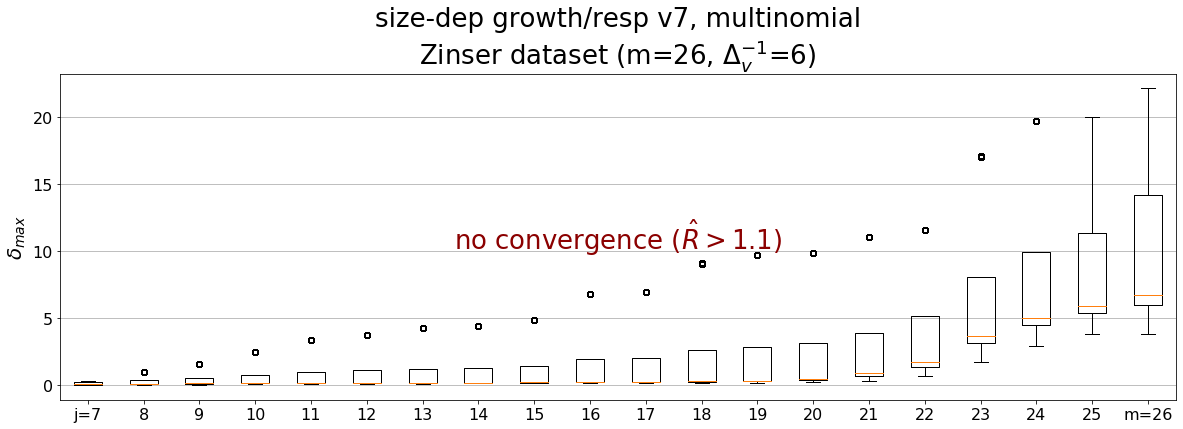

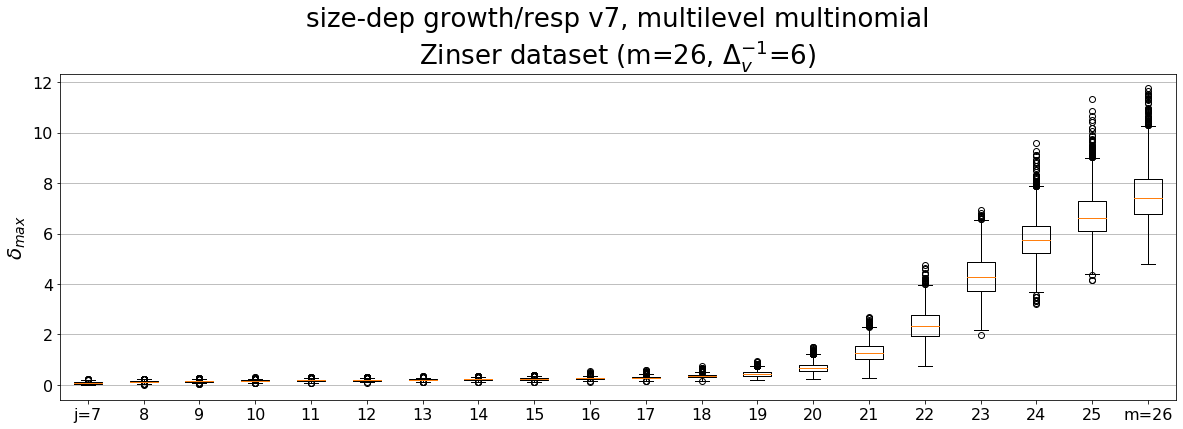

In [14]:
for dataname in data:
    for name,mcmc in mcmcs.items():
        j = data_gridded[dataname]['delta_v_inv'] + 1
        m = data_gridded[dataname]['m']

        fig, ax = plt.subplots(figsize=(20,6))
        ax.set_title(desc_model[name] + '\n' + desc[dataname])
        ax.boxplot(mcmc[dataname]['delta_max'])
        xlabels = [str(x) for x in range(j,m+1)]
        xlabels[0] = 'j='+xlabels[0]
        xlabels[-1] = 'm='+xlabels[-1]
        ax.set_xticklabels(xlabels)
        ax.grid(axis='y')
        ax.set_ylabel('$\\delta_{max}$')
        
        if maxrhats_final[name][dataname] > 1.1:
            ax.text(0.5, 0.5, 'no convergence ($\\hat{R}>1.1$)', color='darkred', size=26, transform=ax.transAxes, ha='center', va='center')
        None

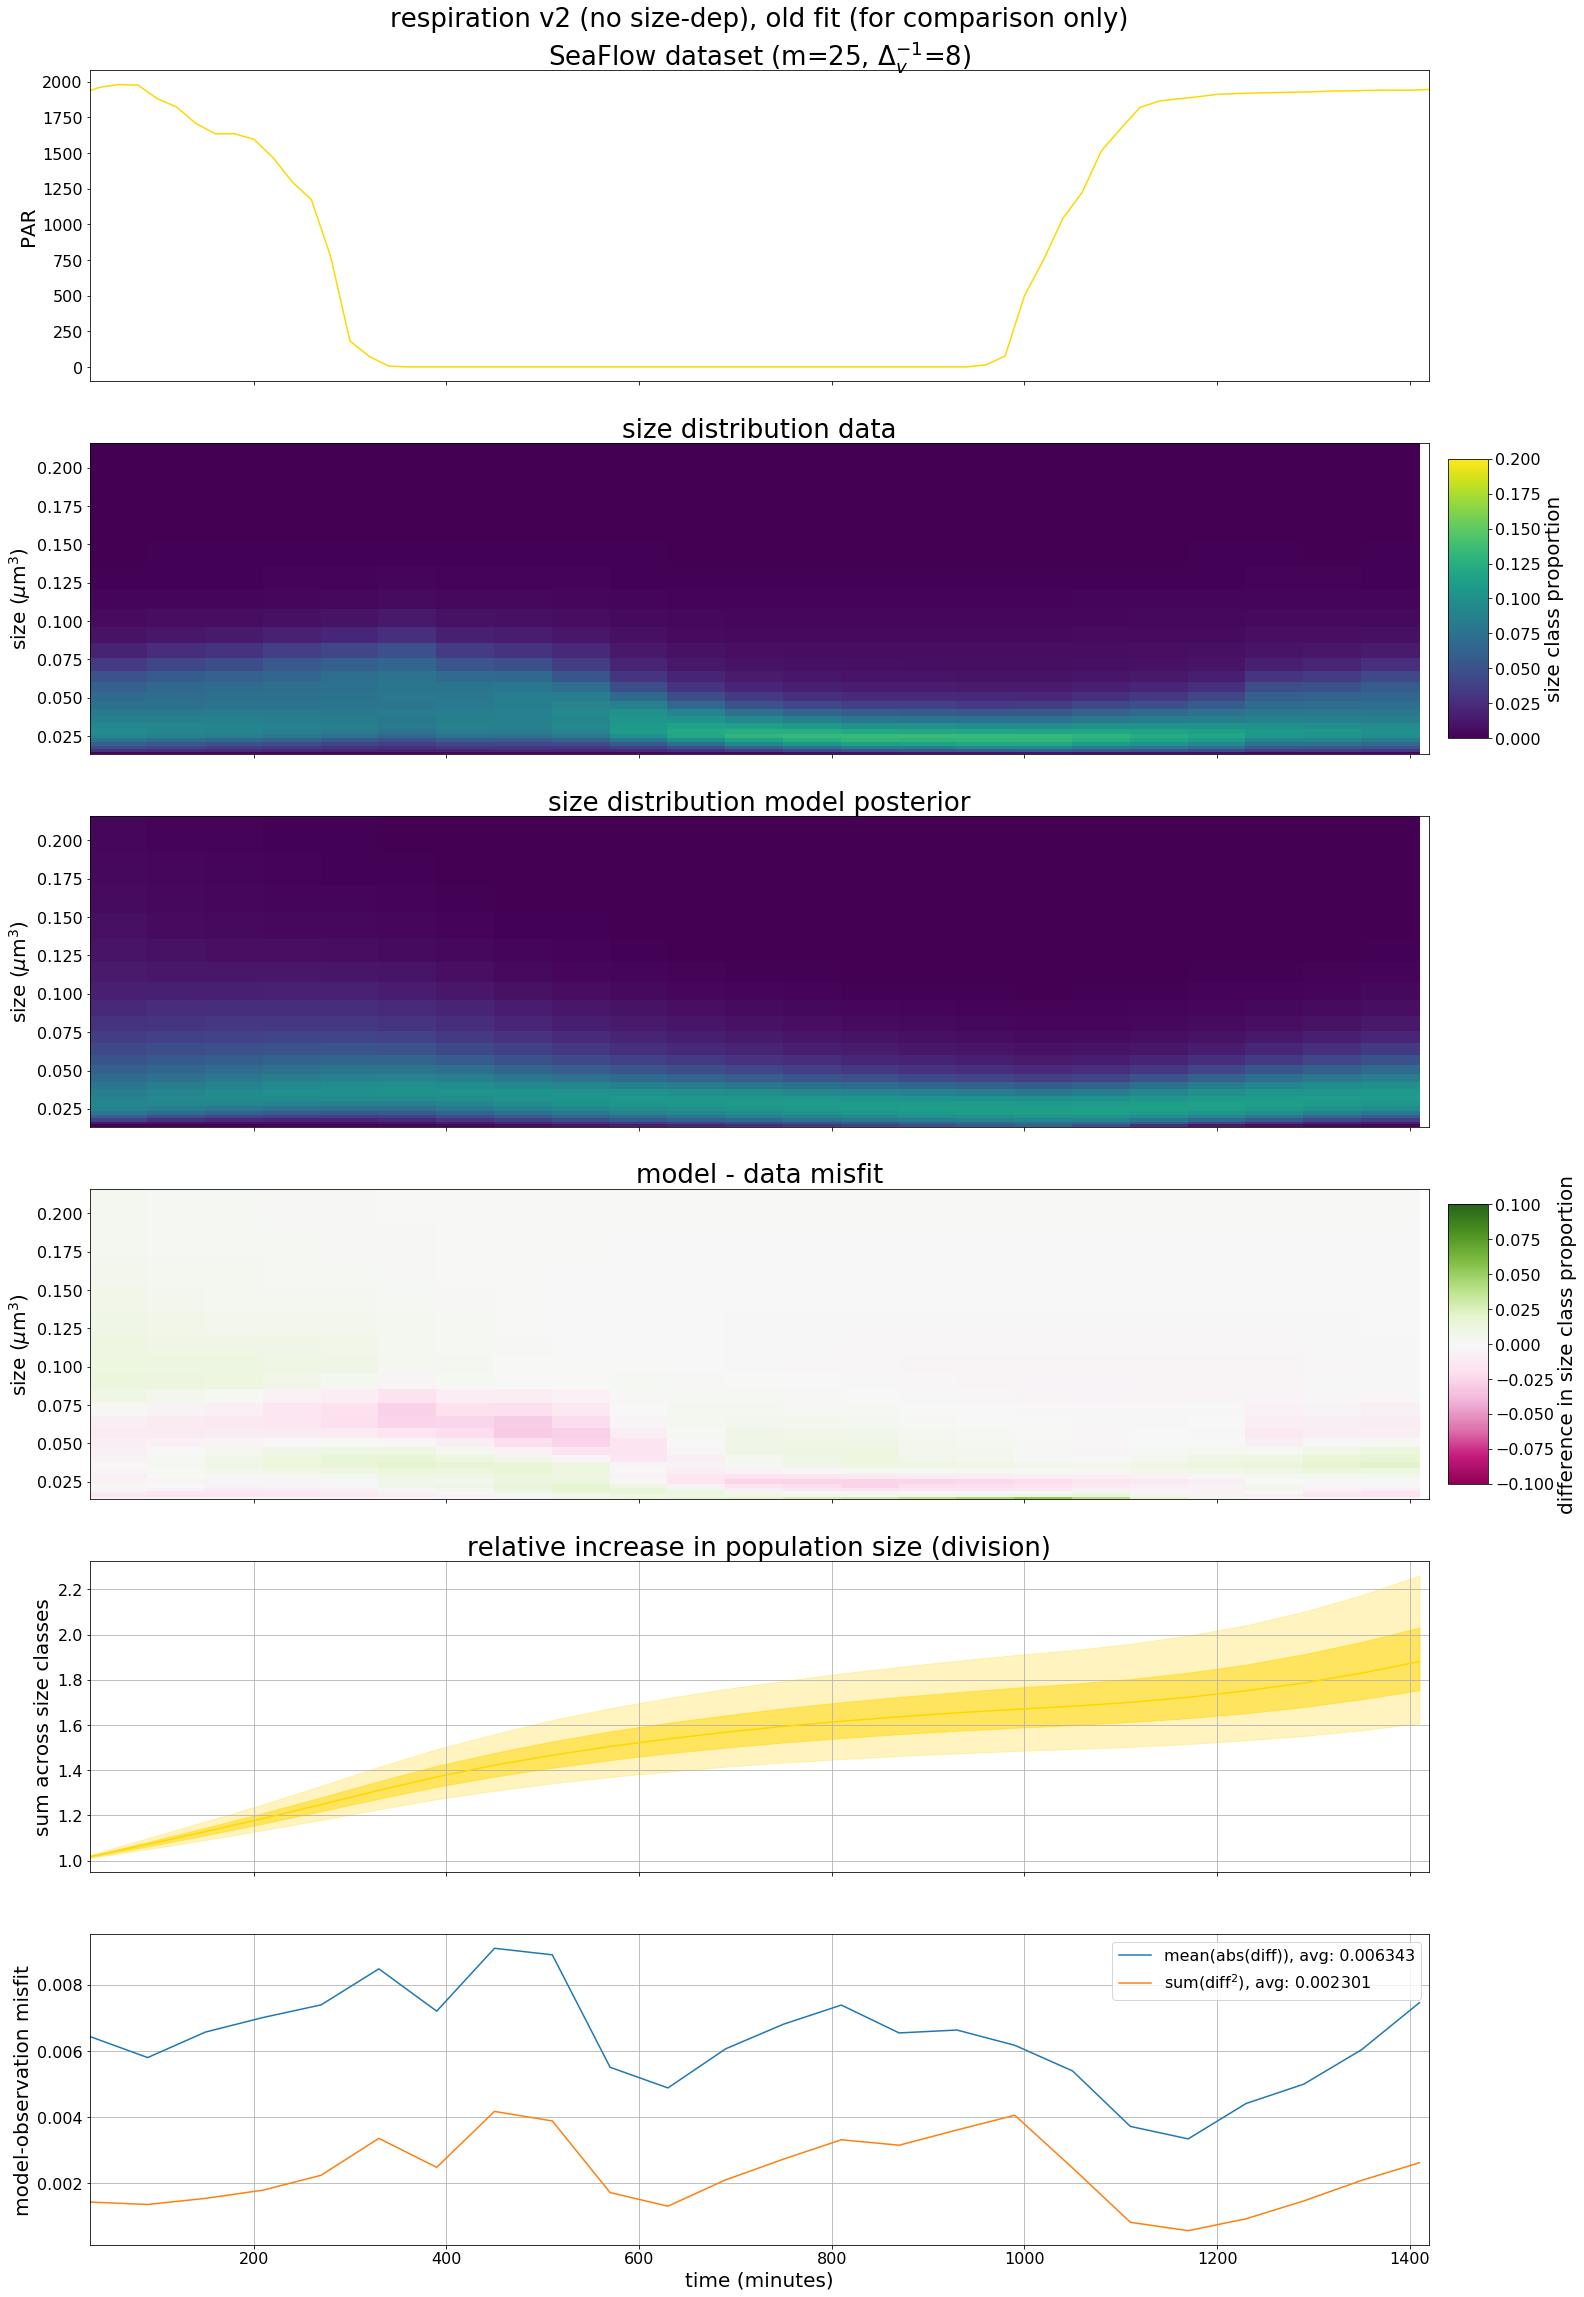

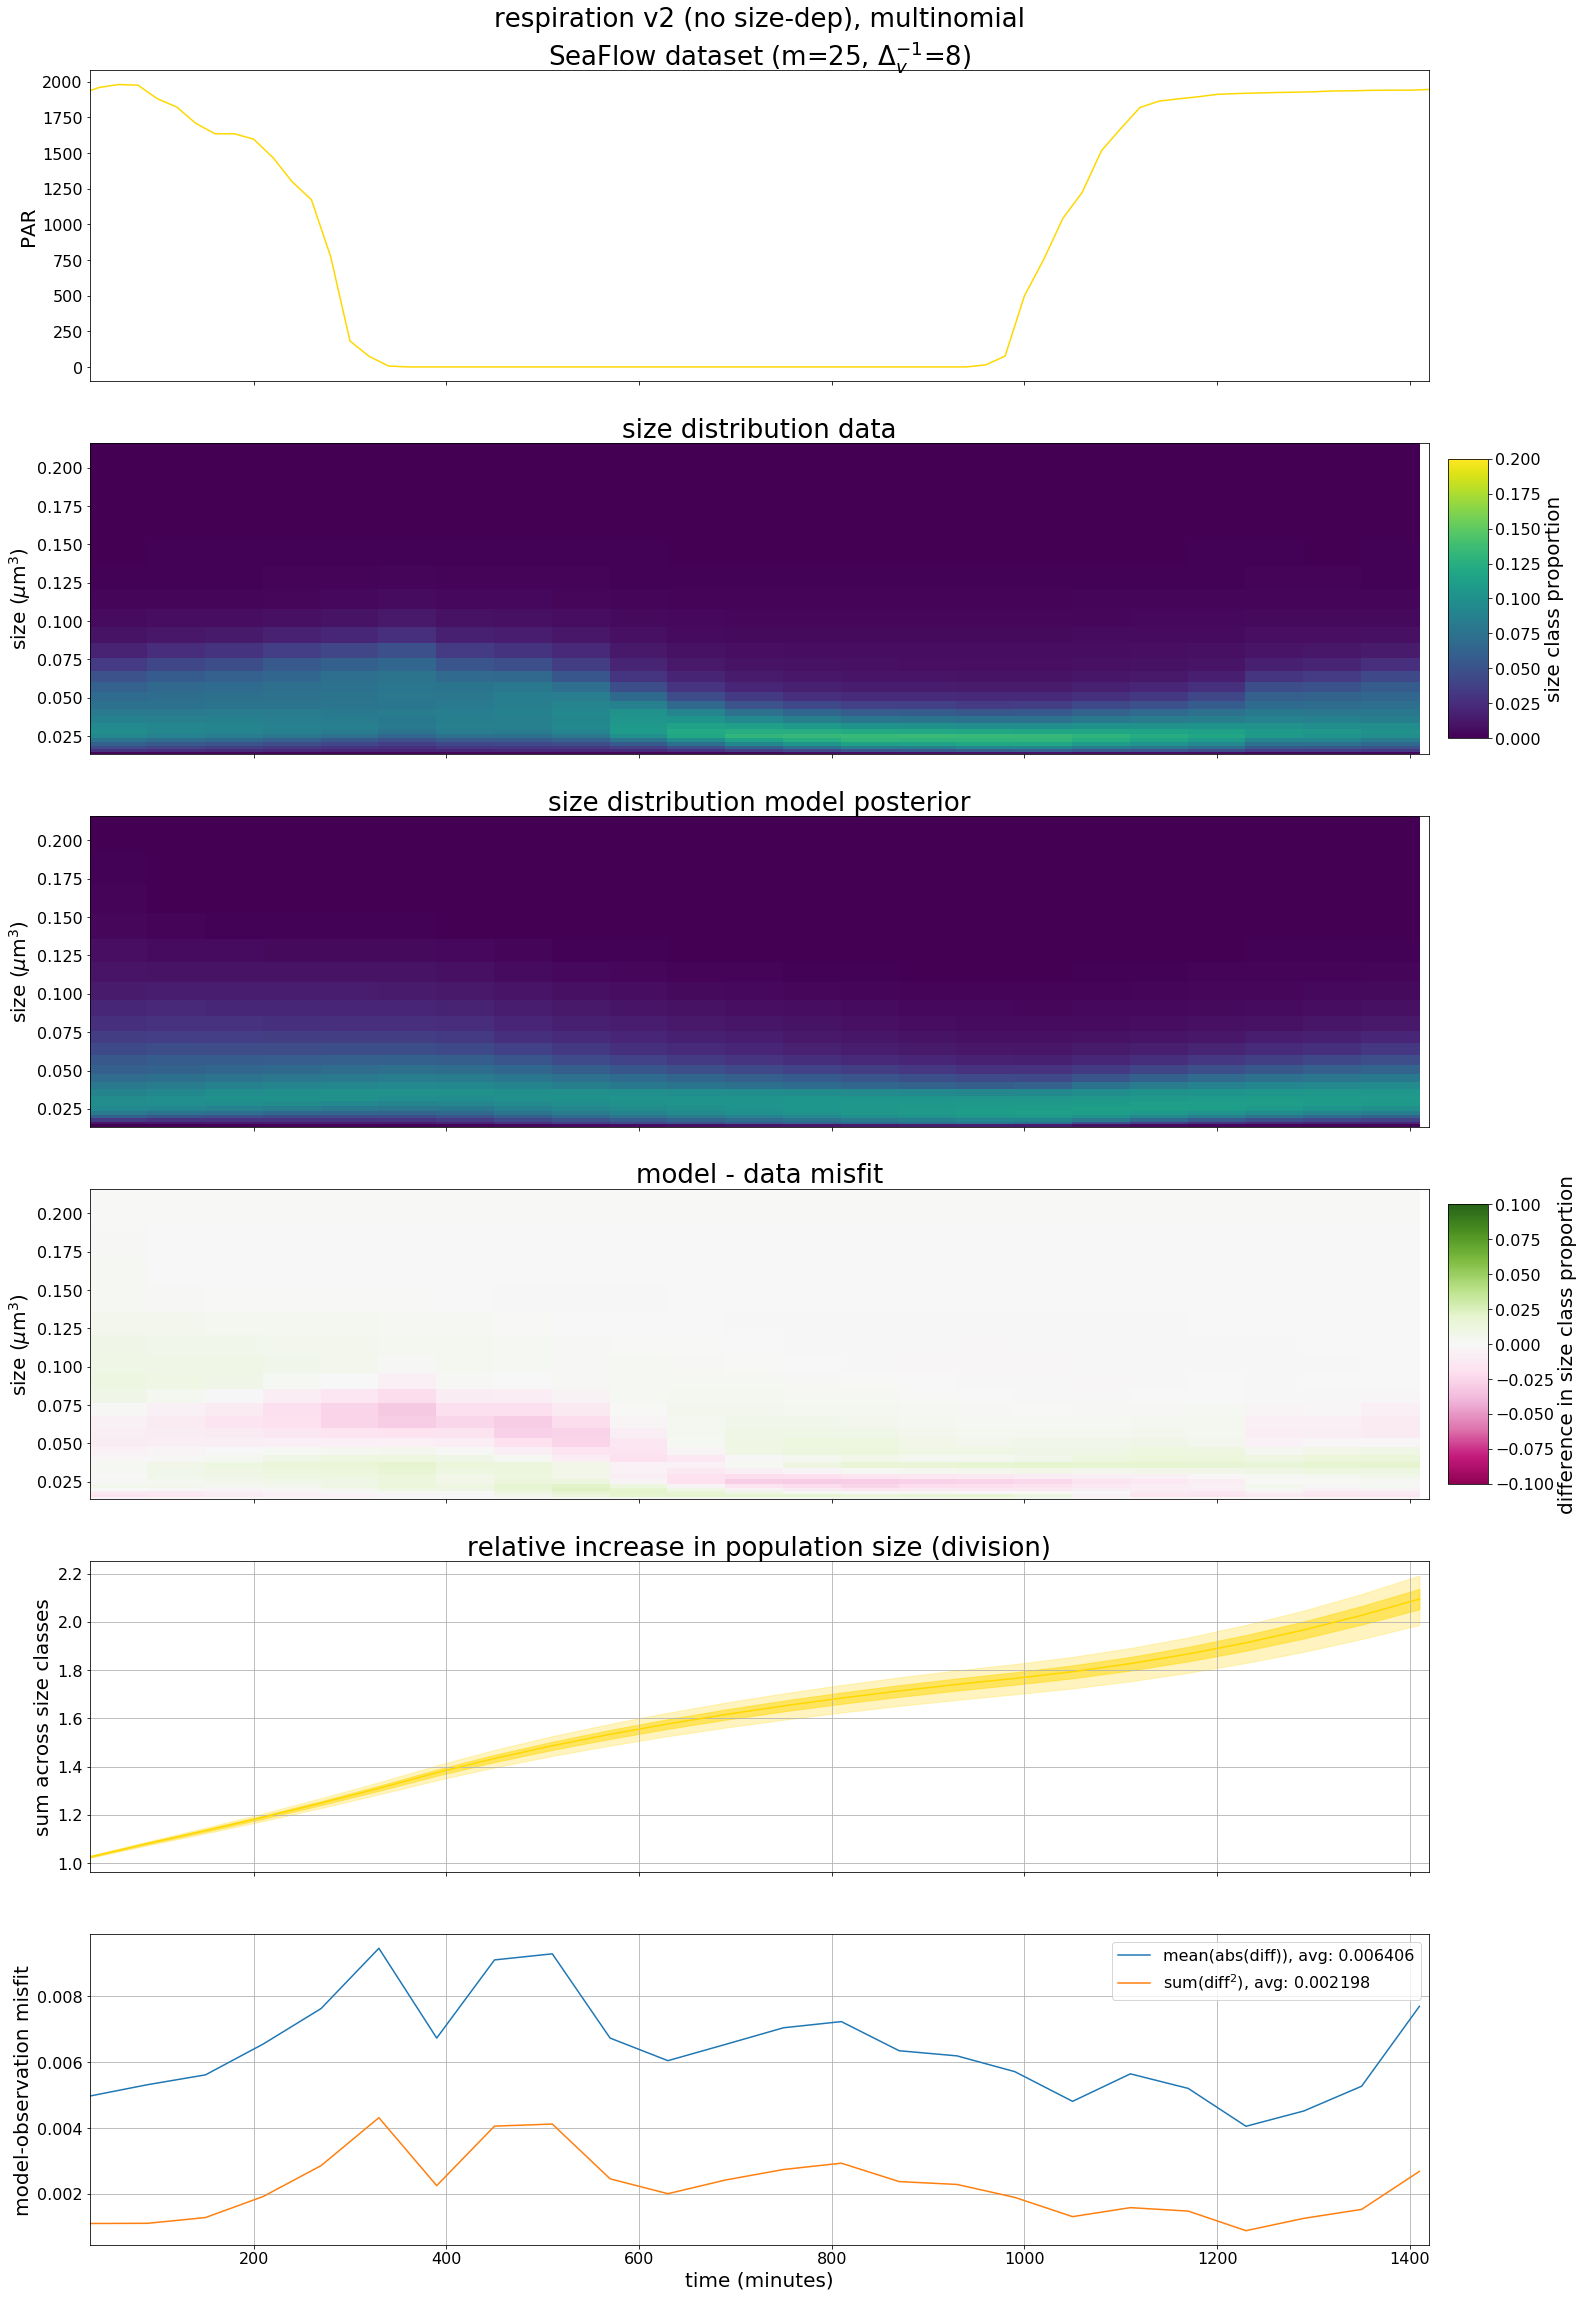

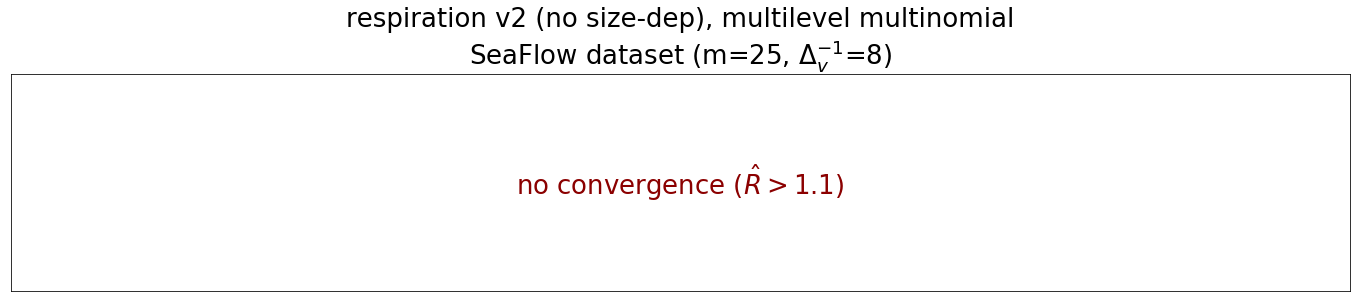

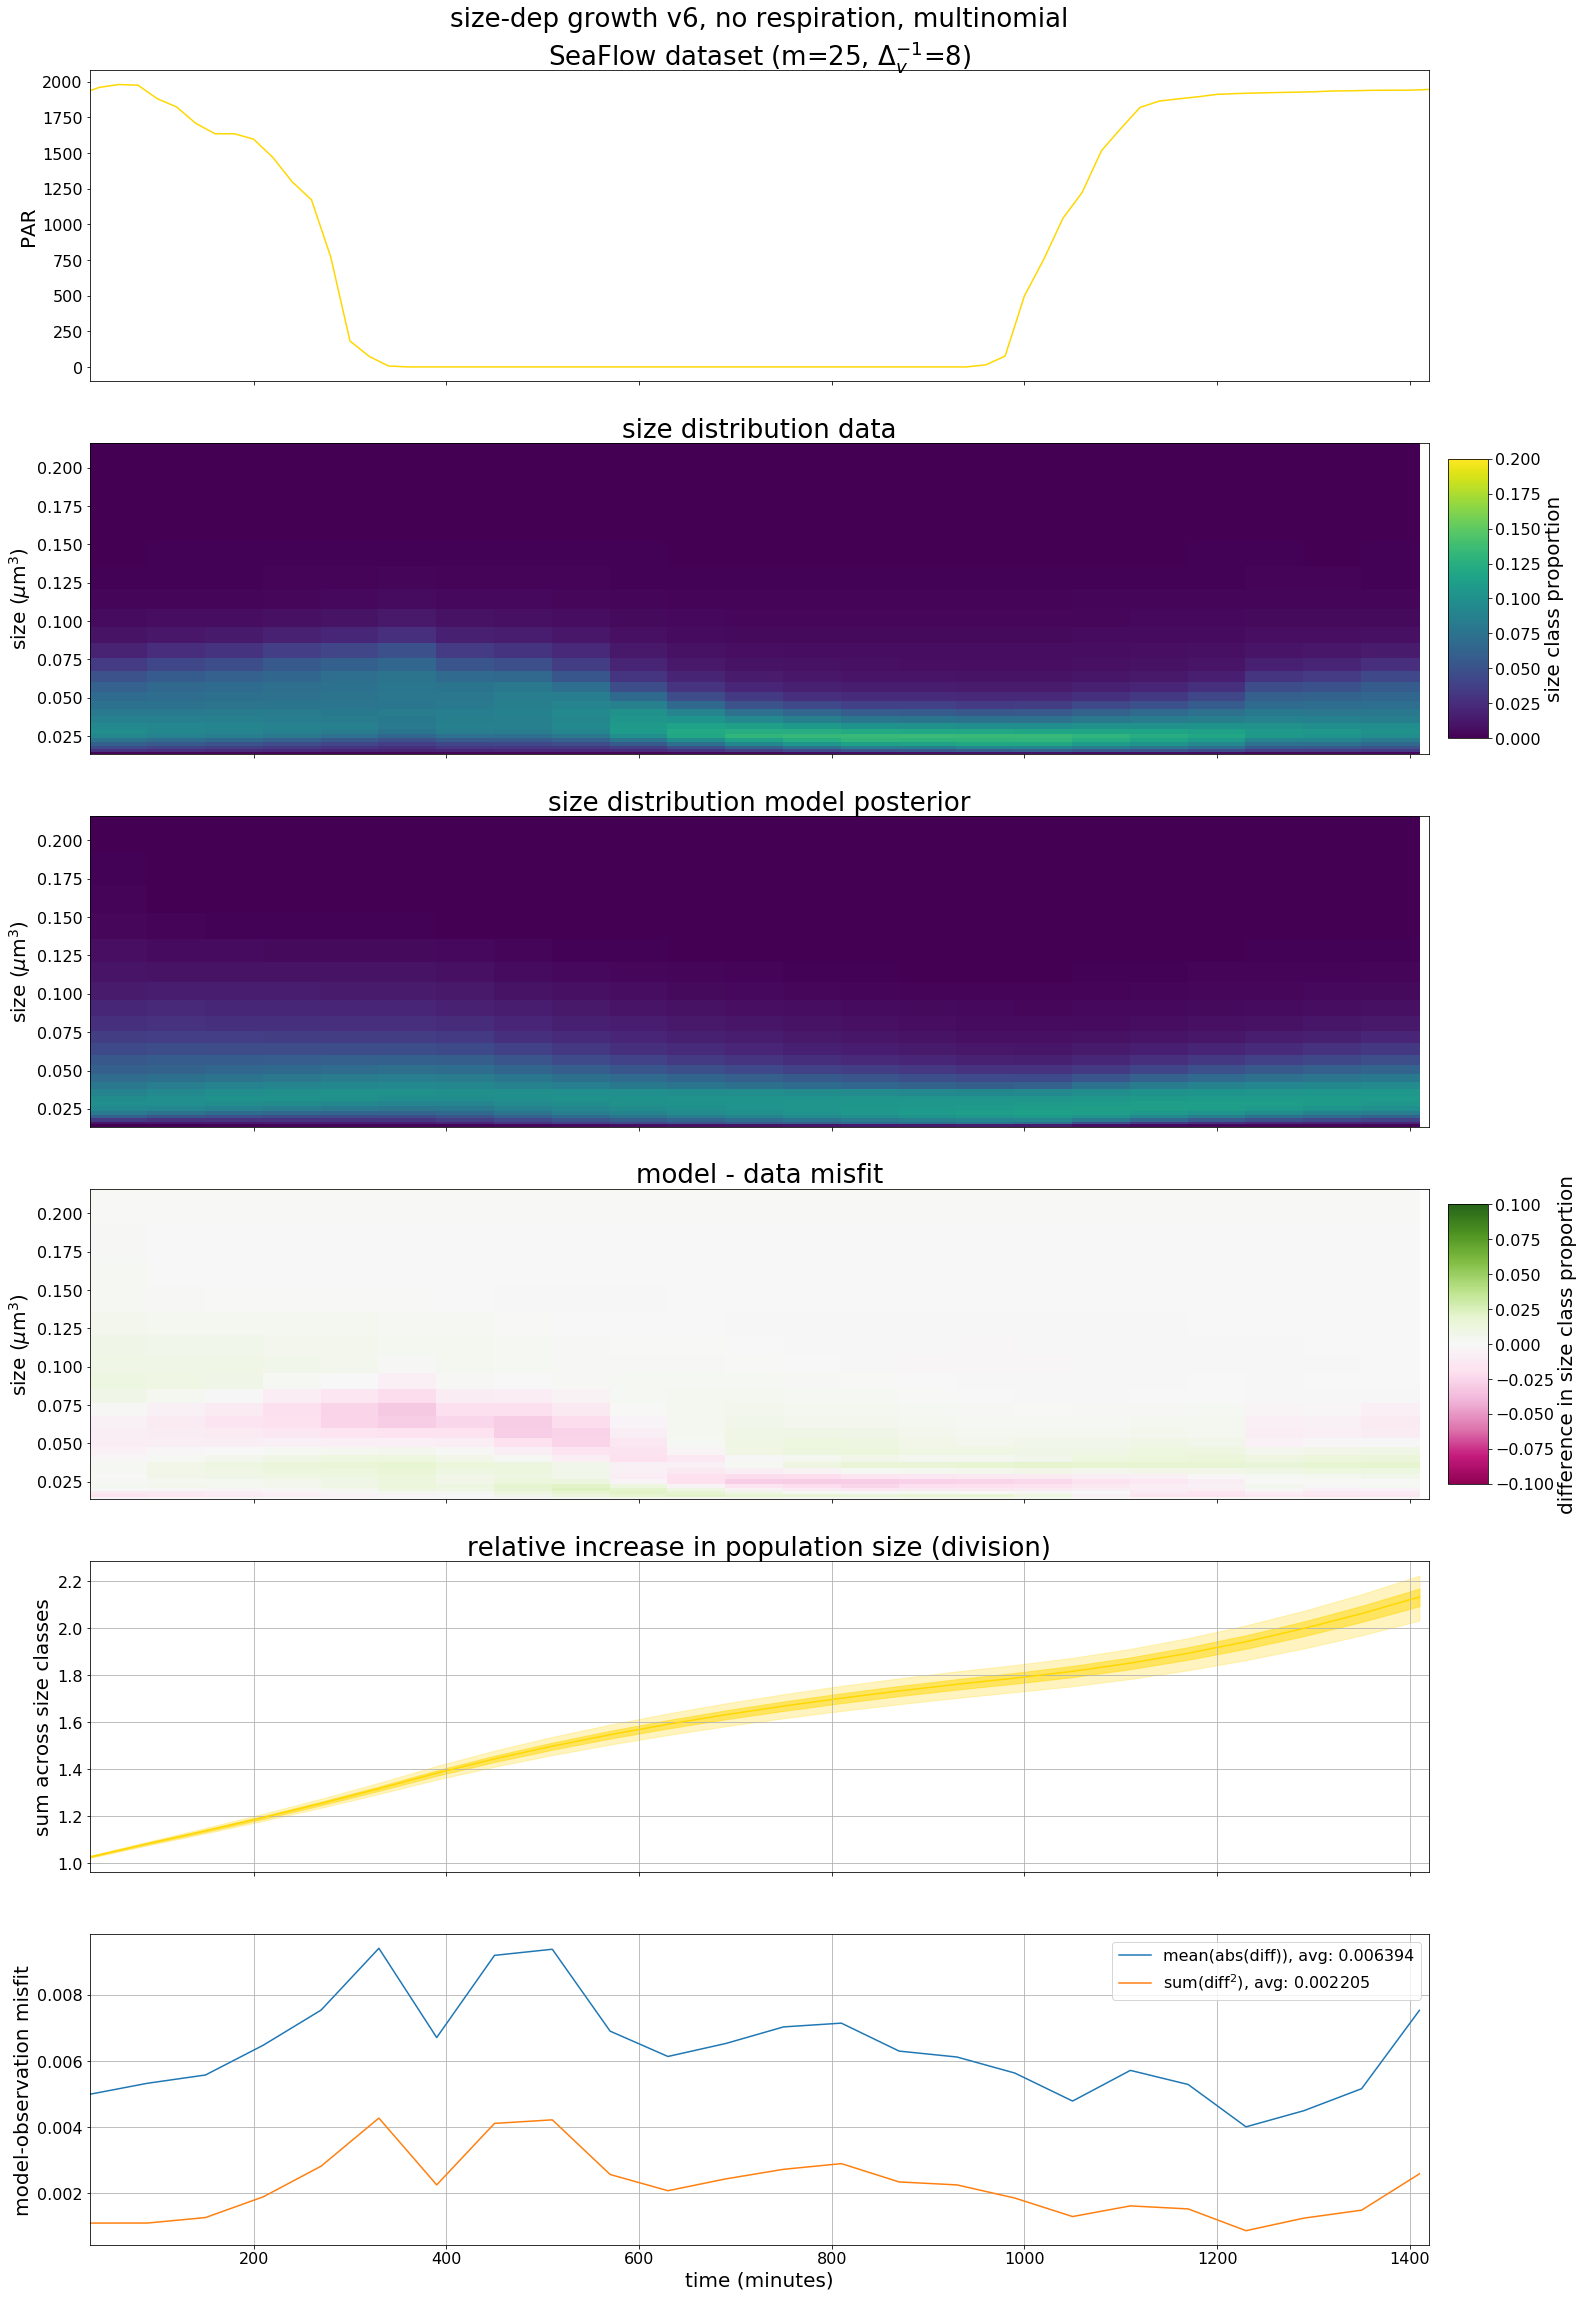

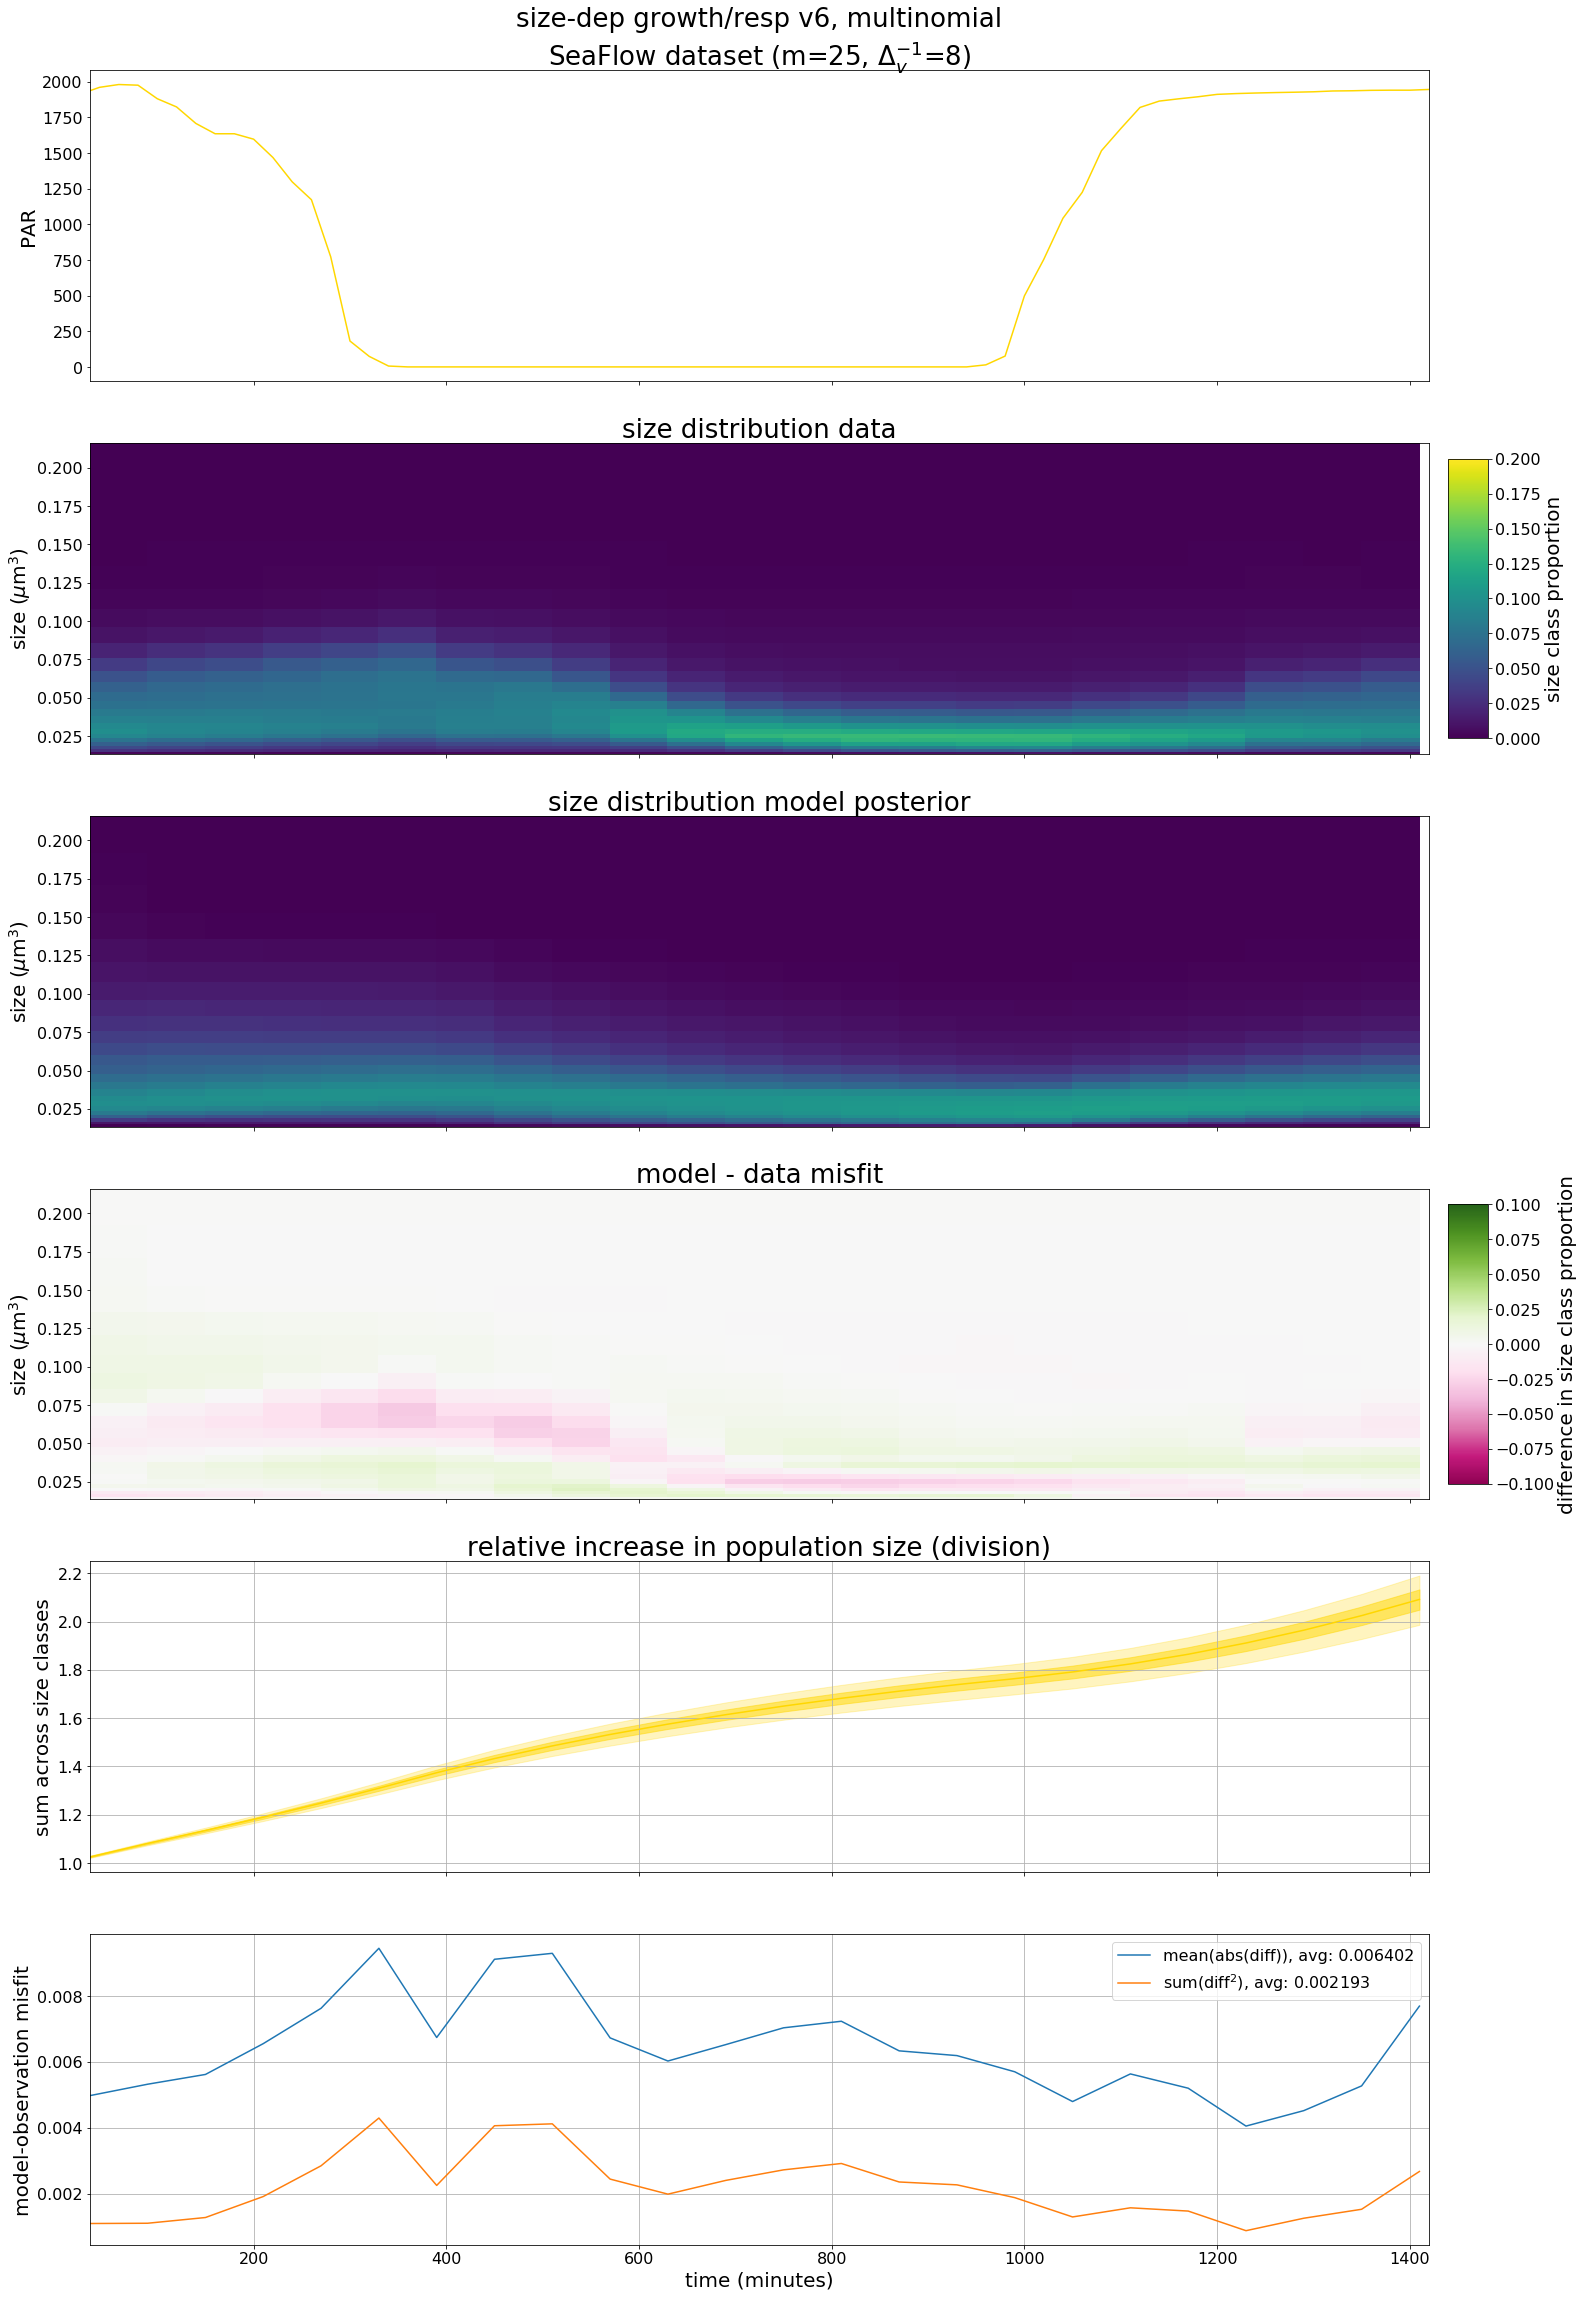

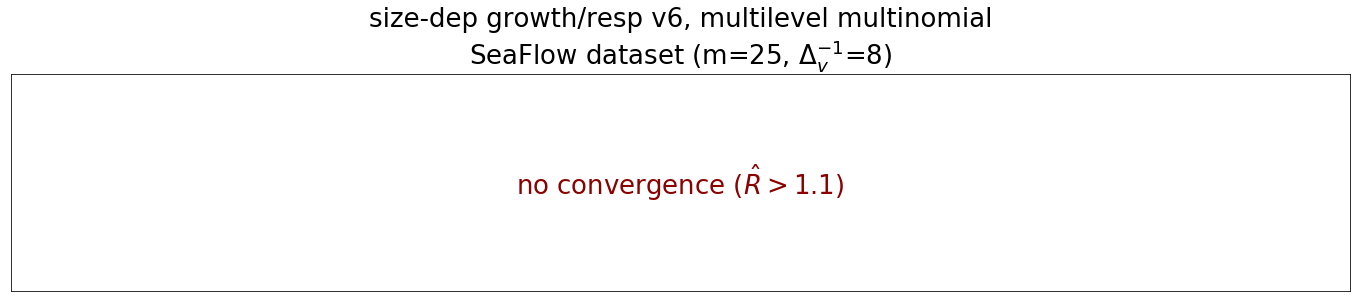

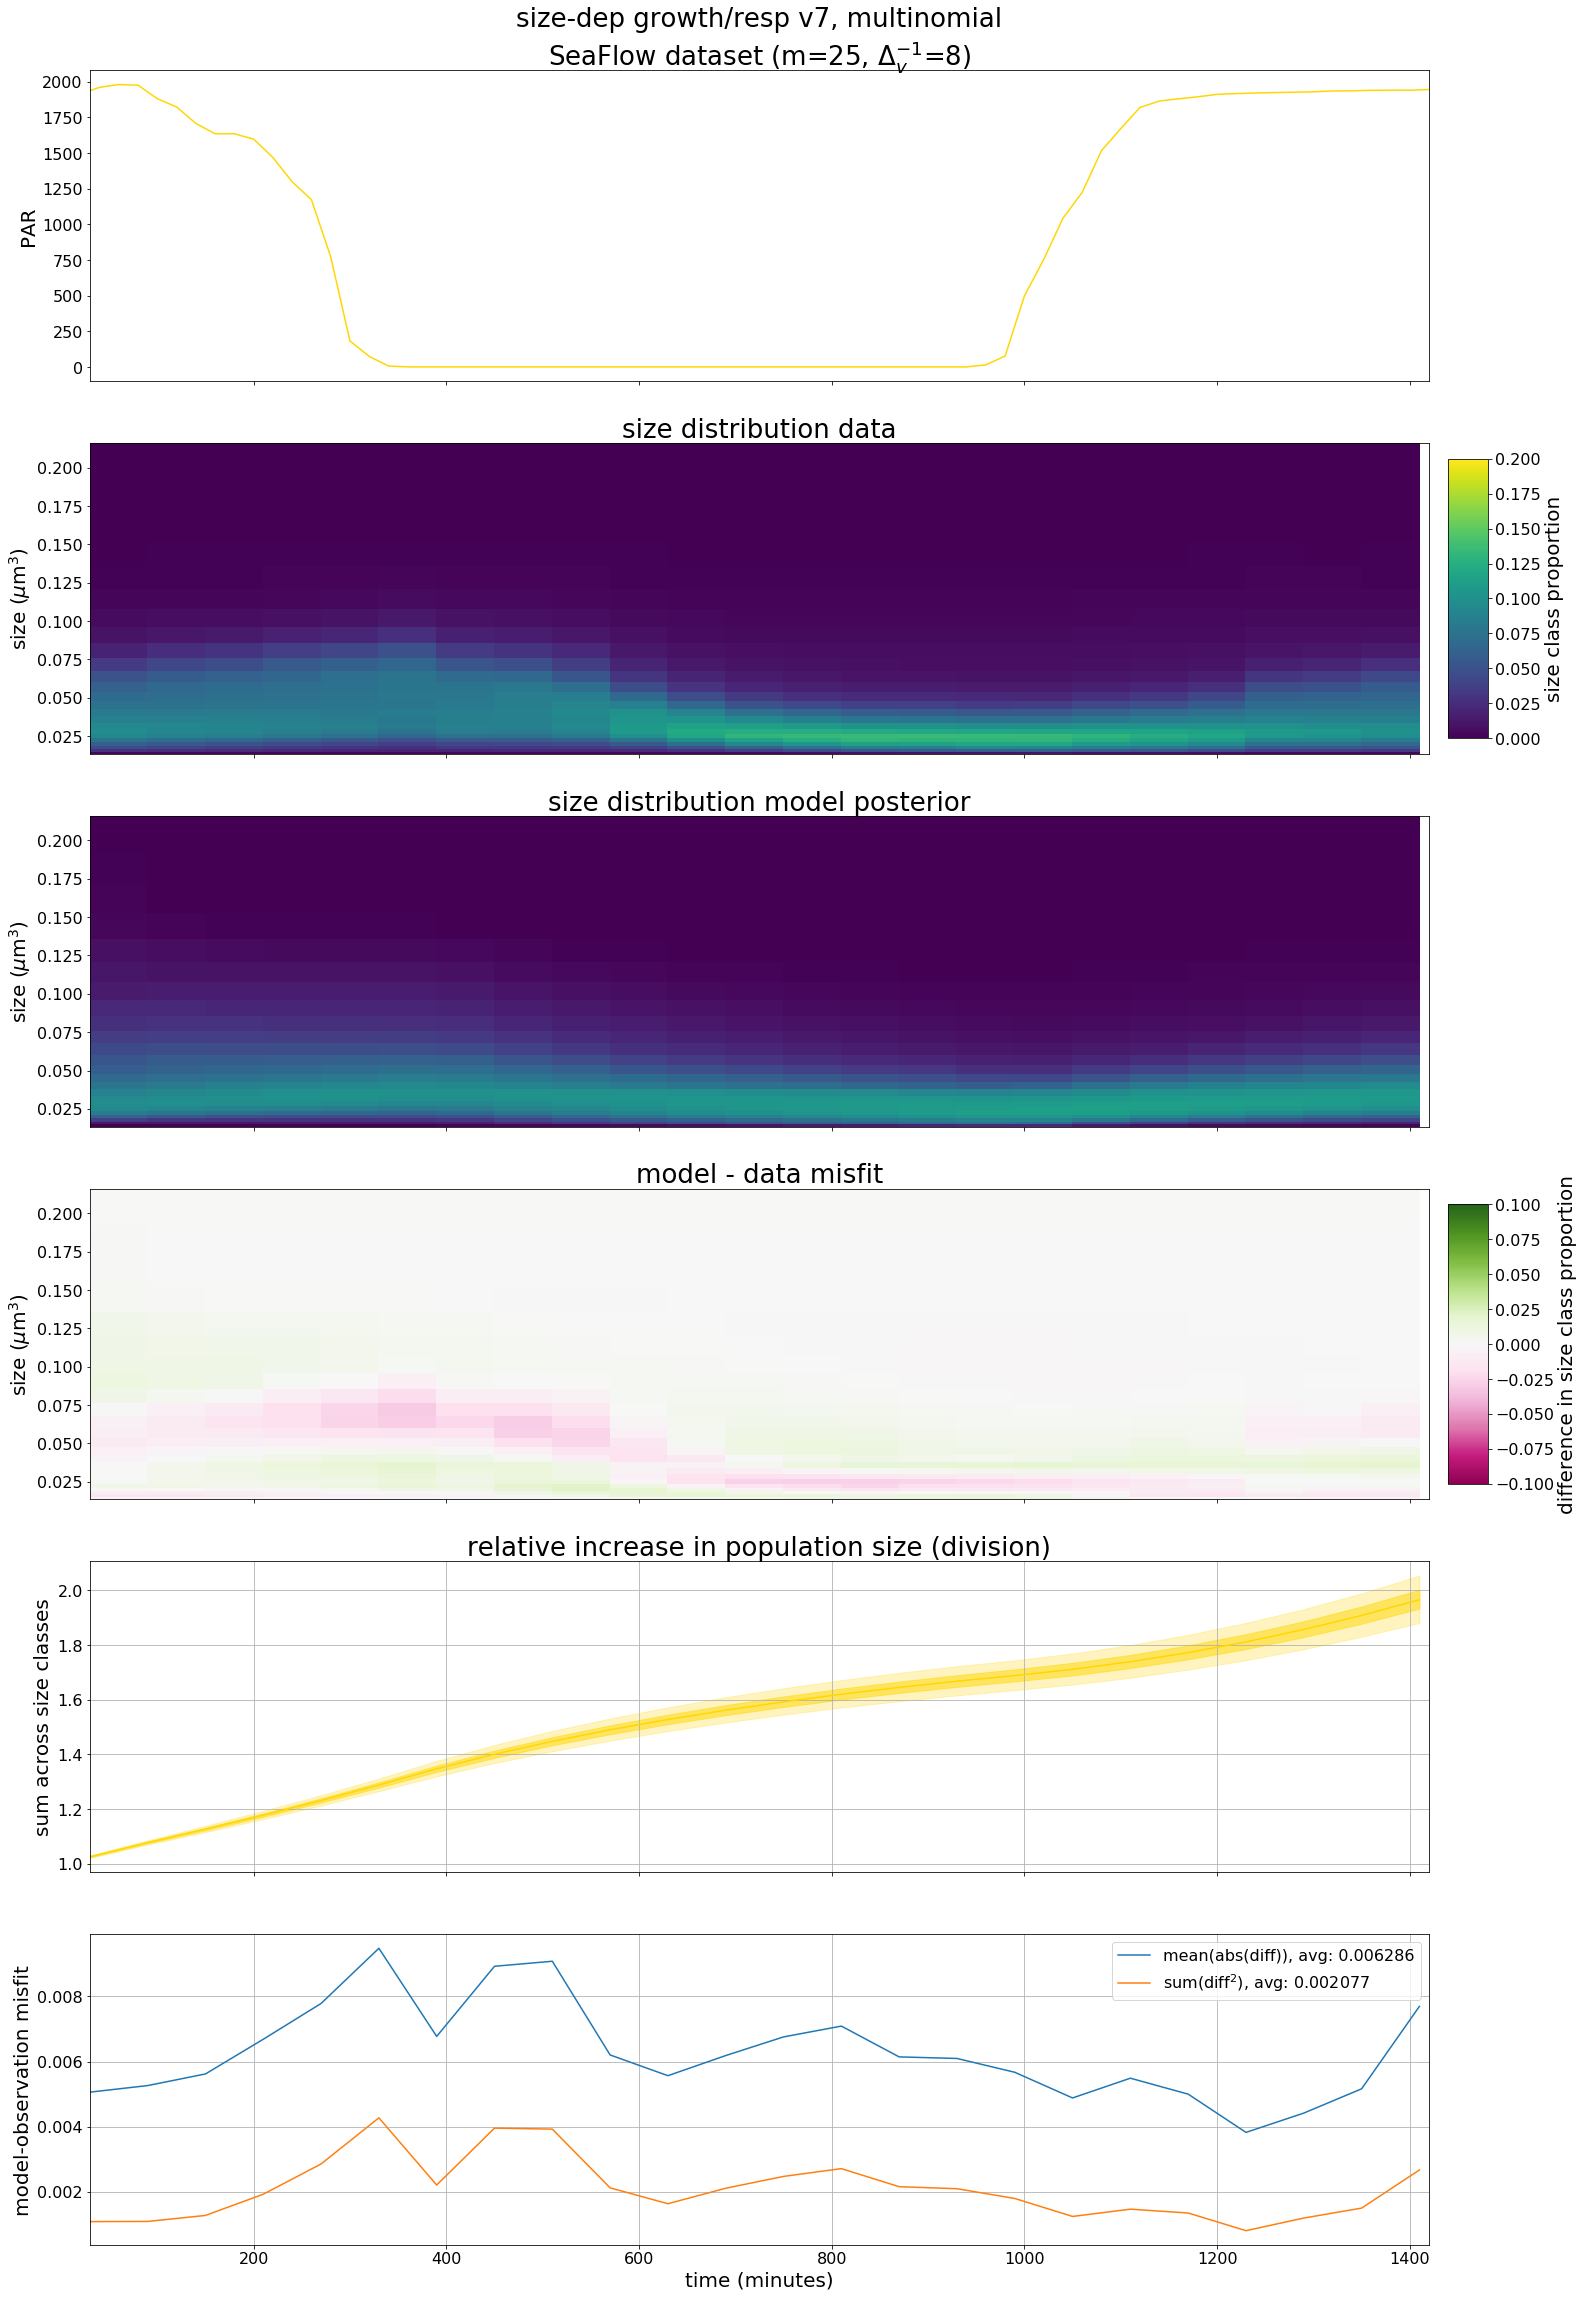

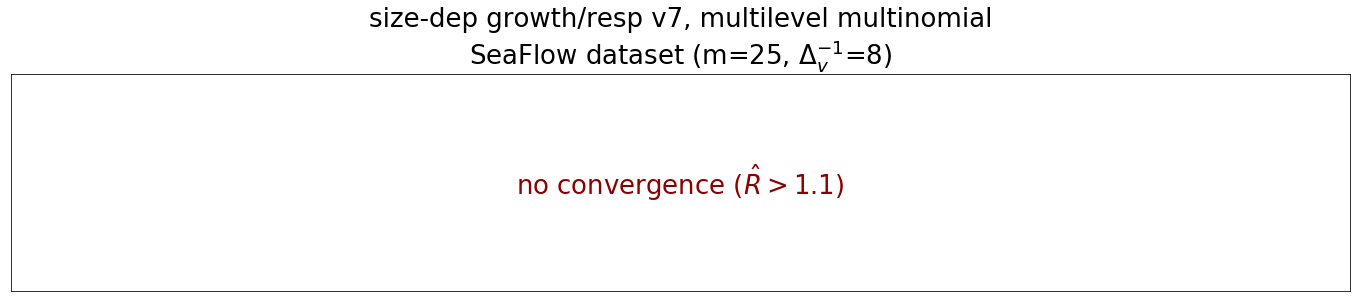

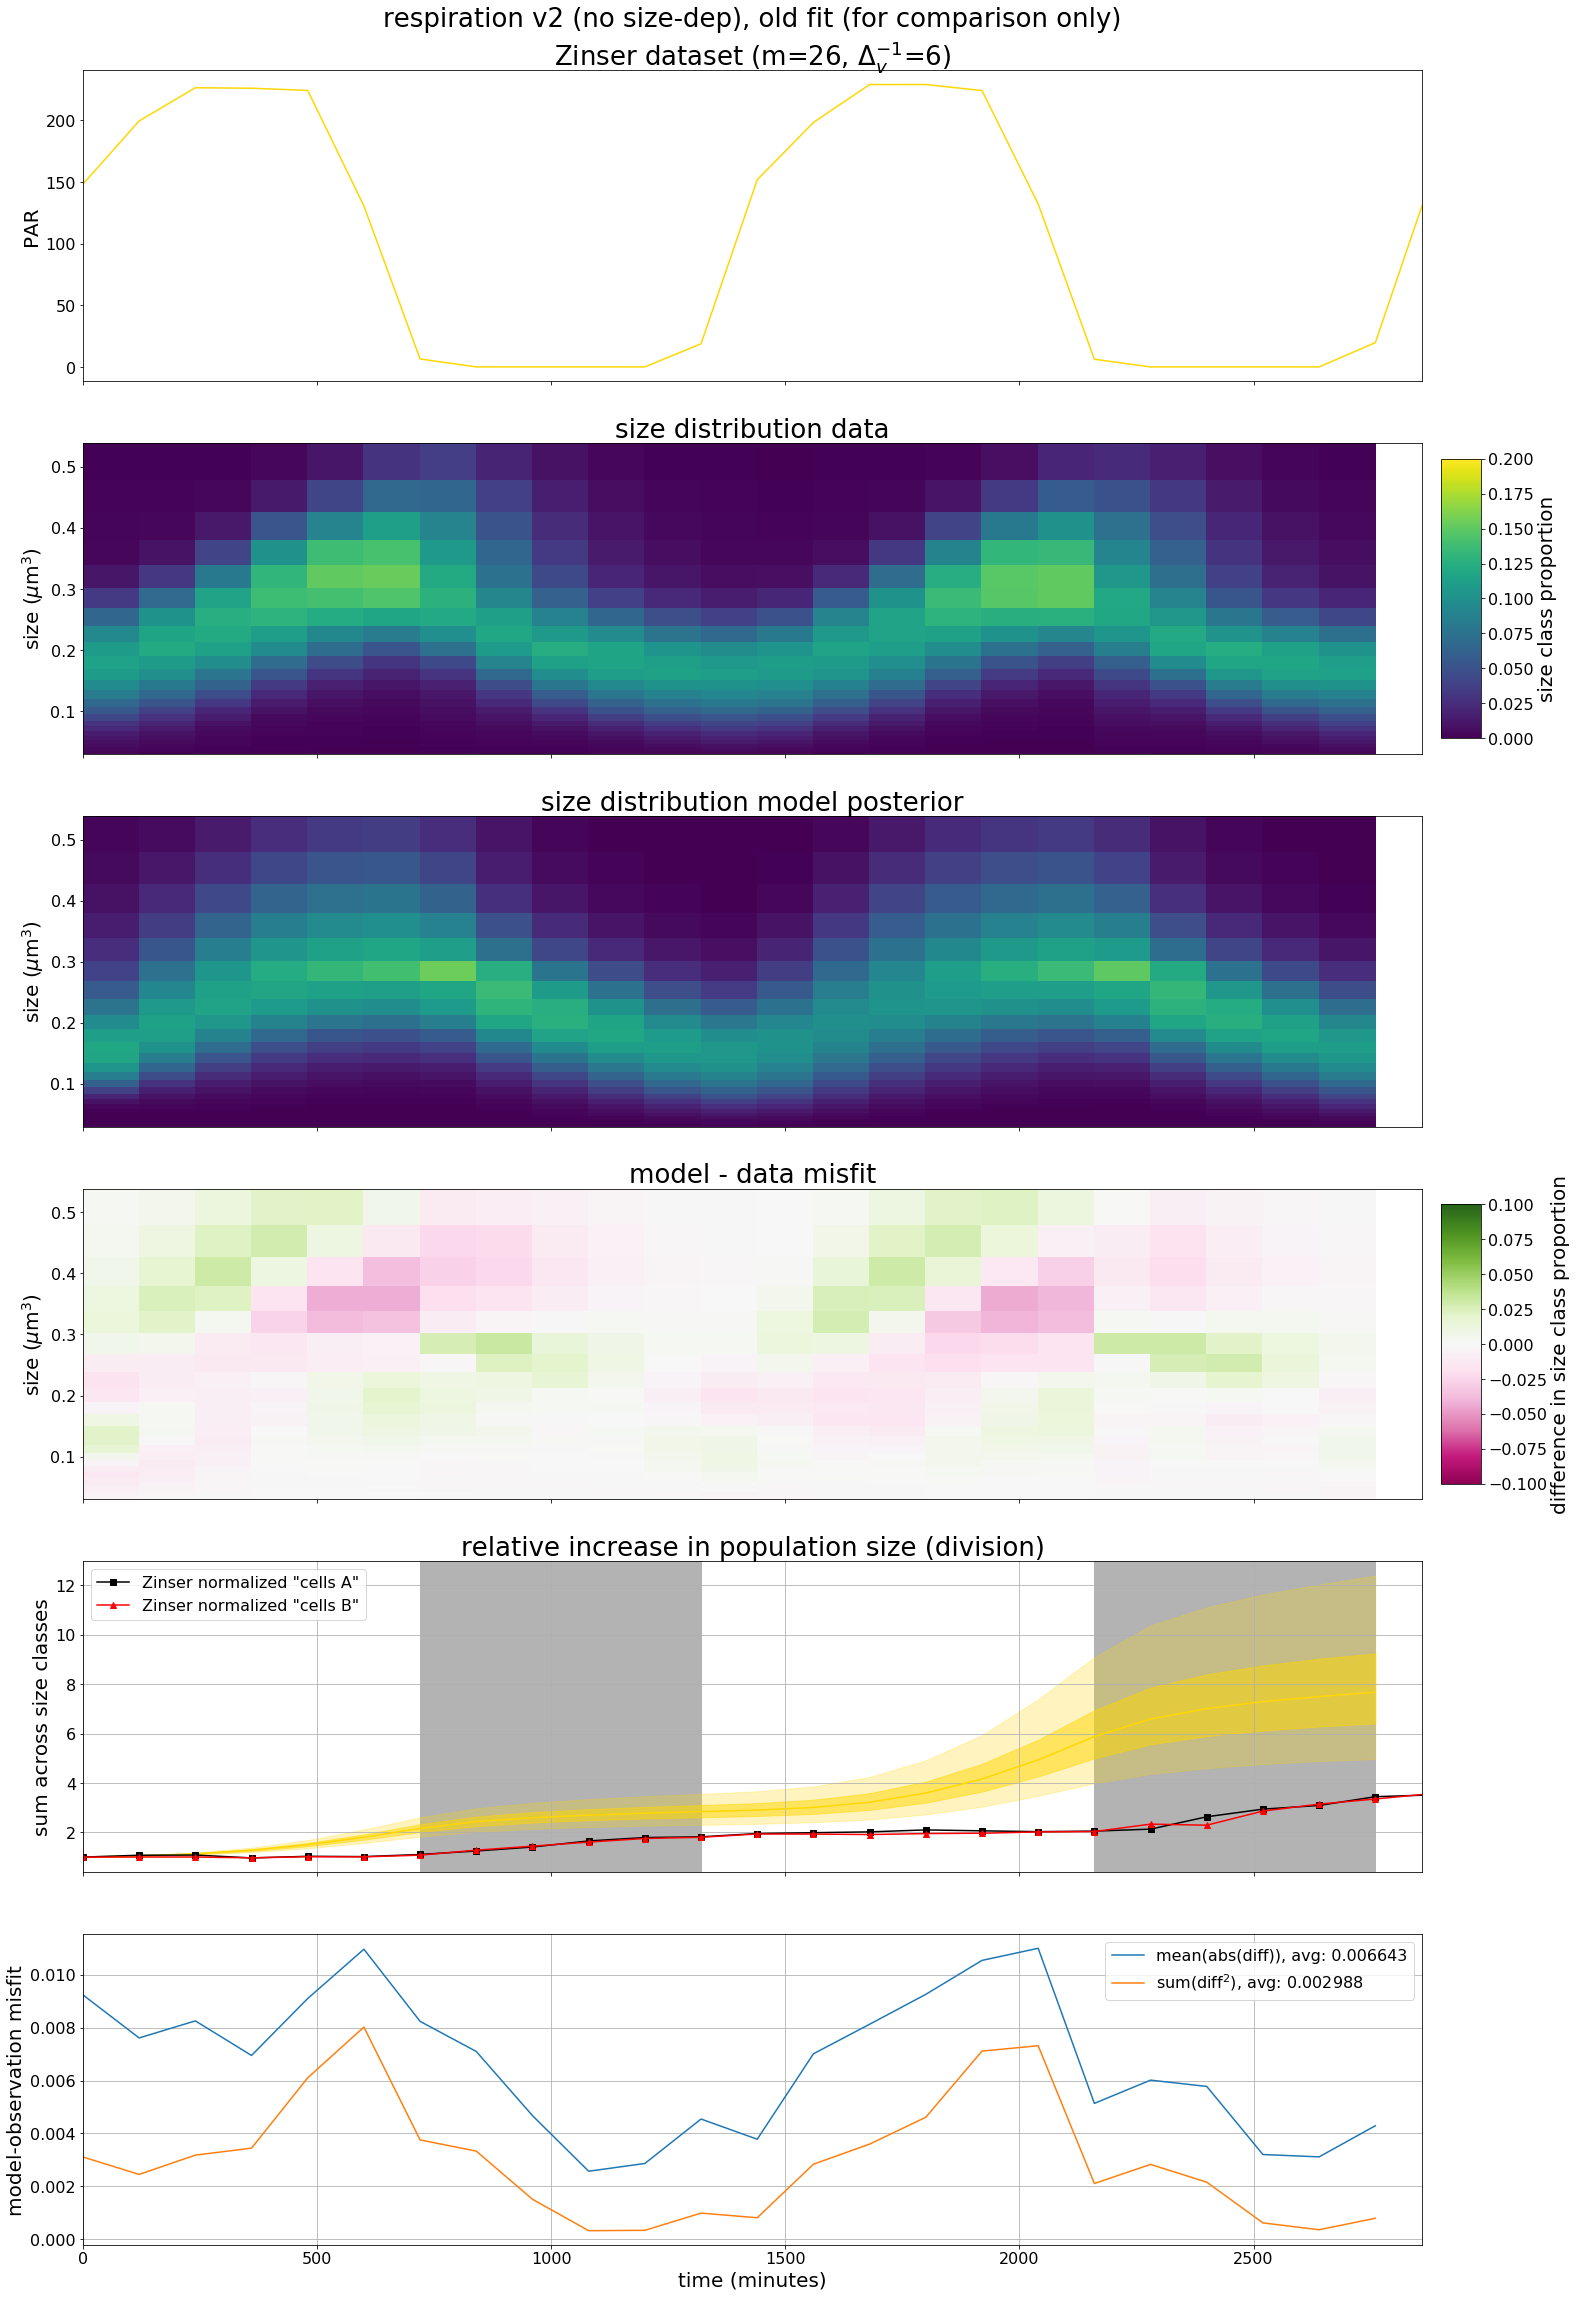

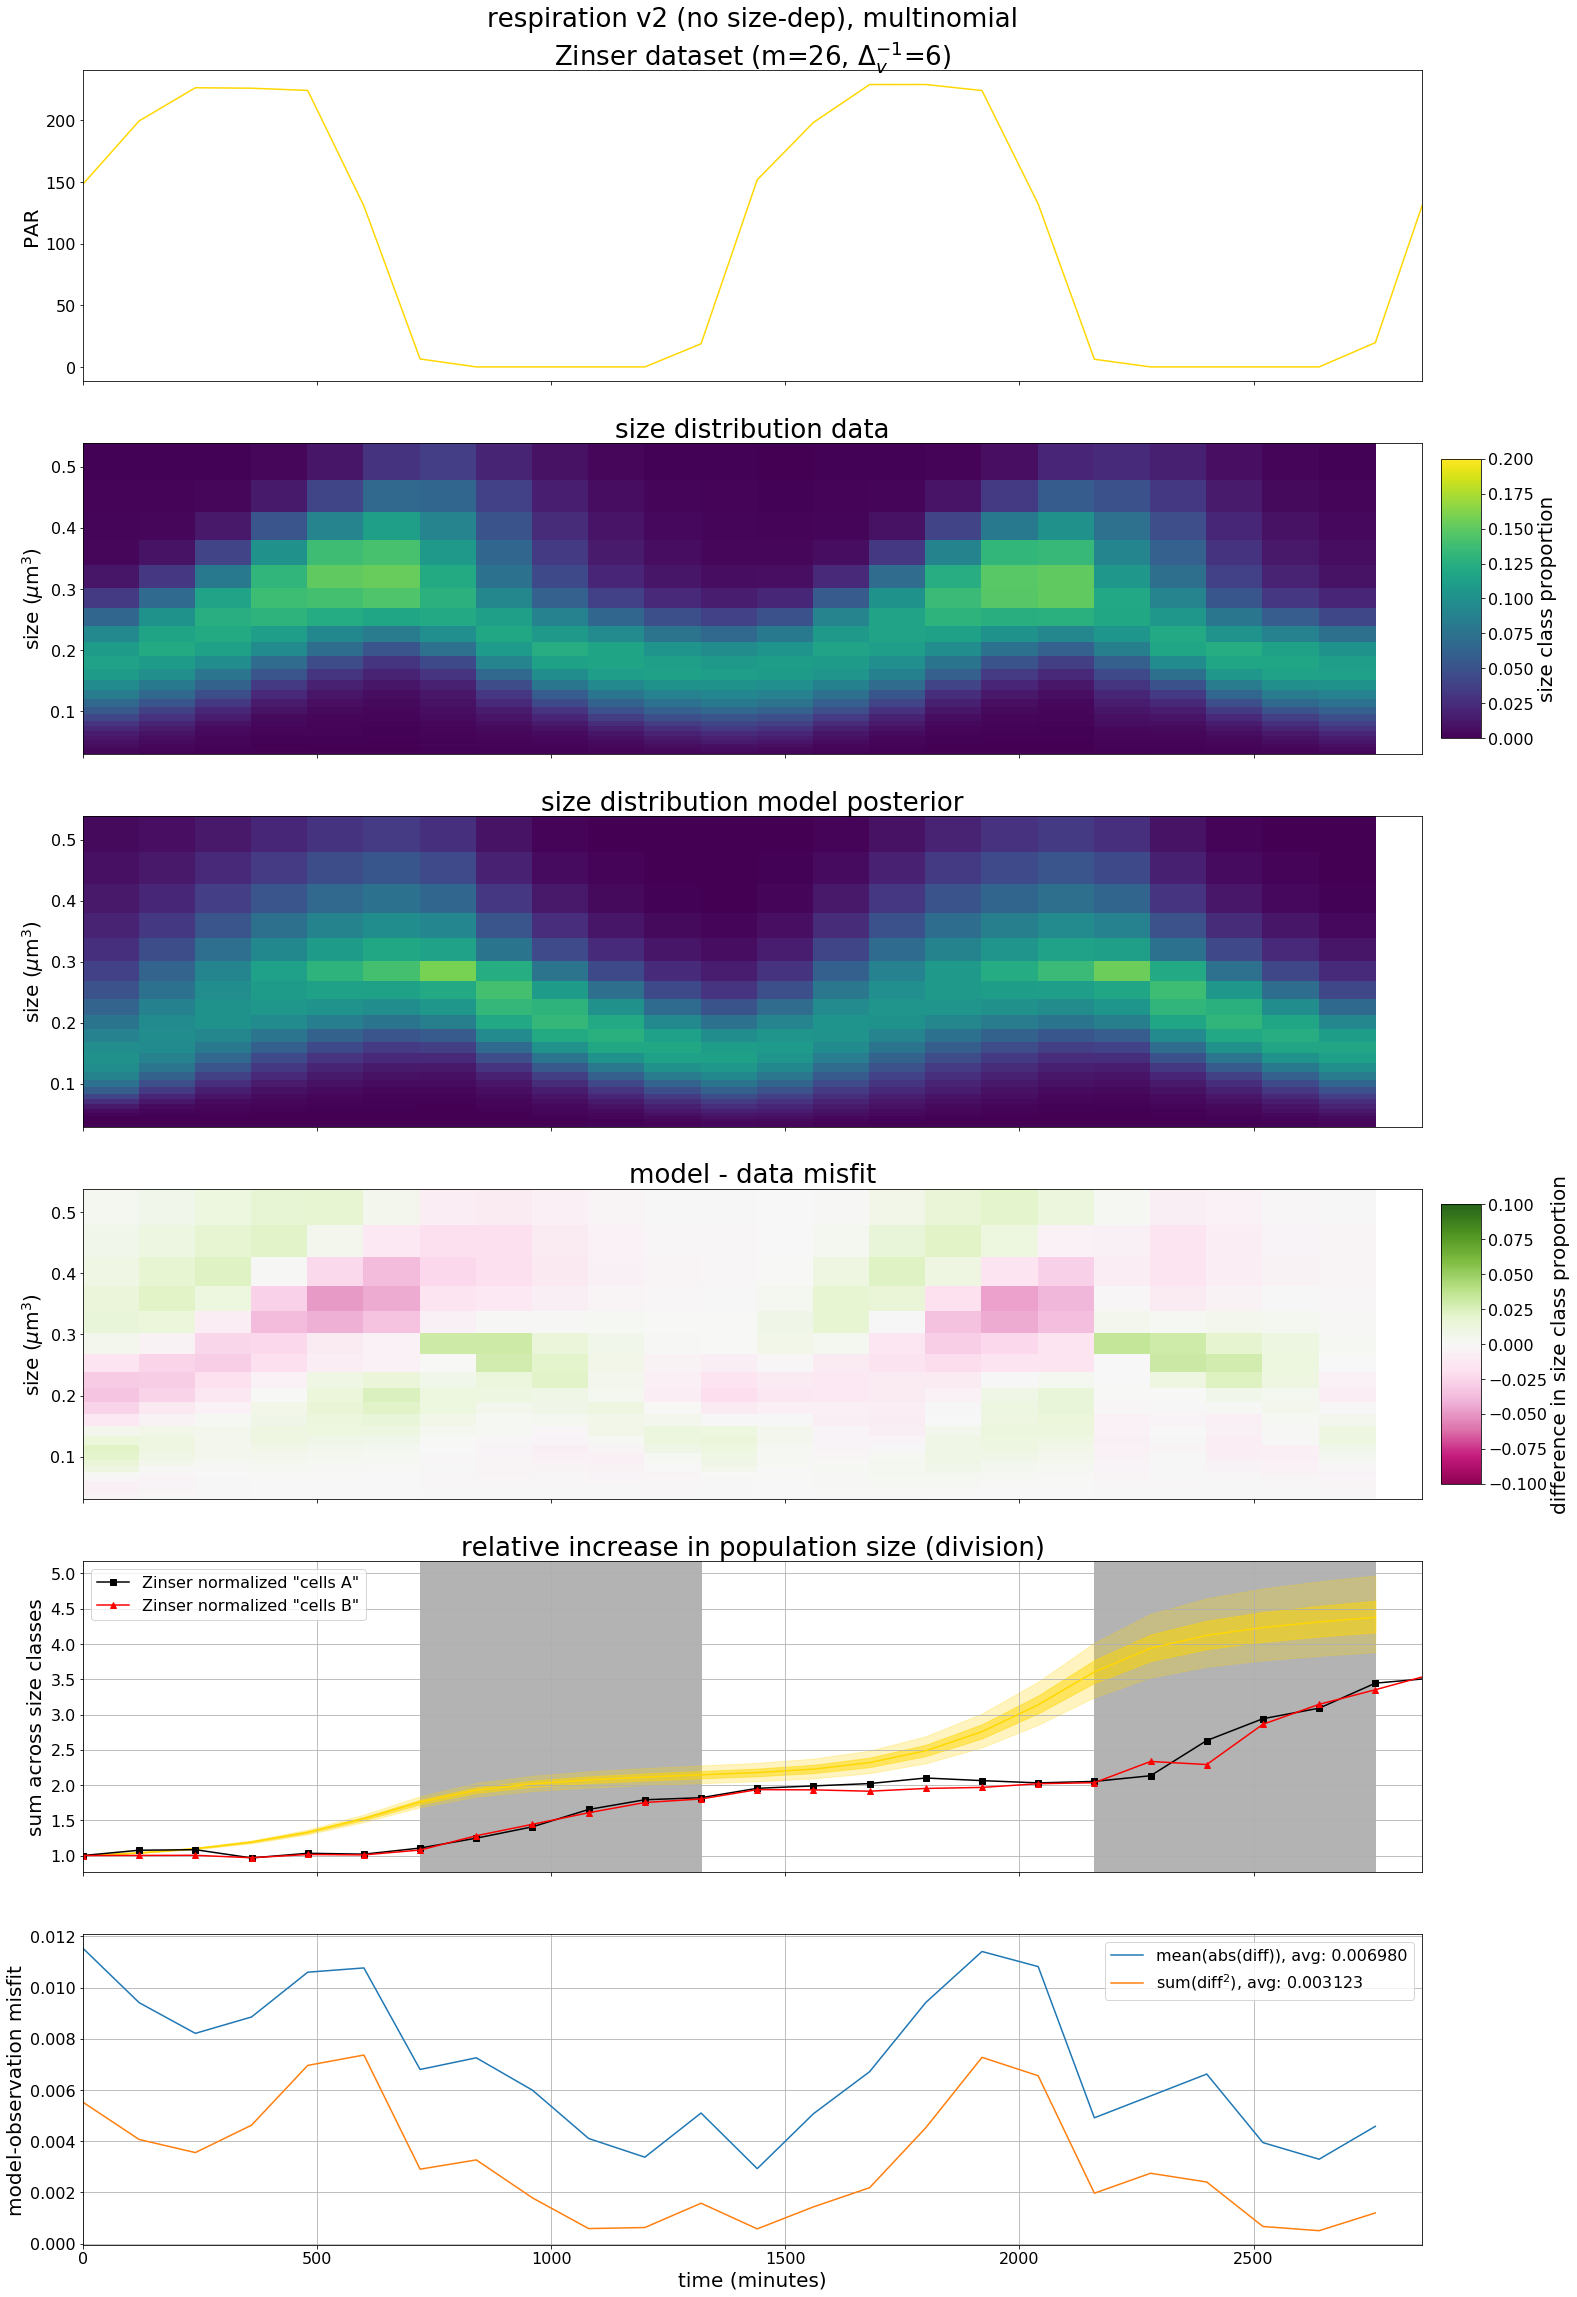

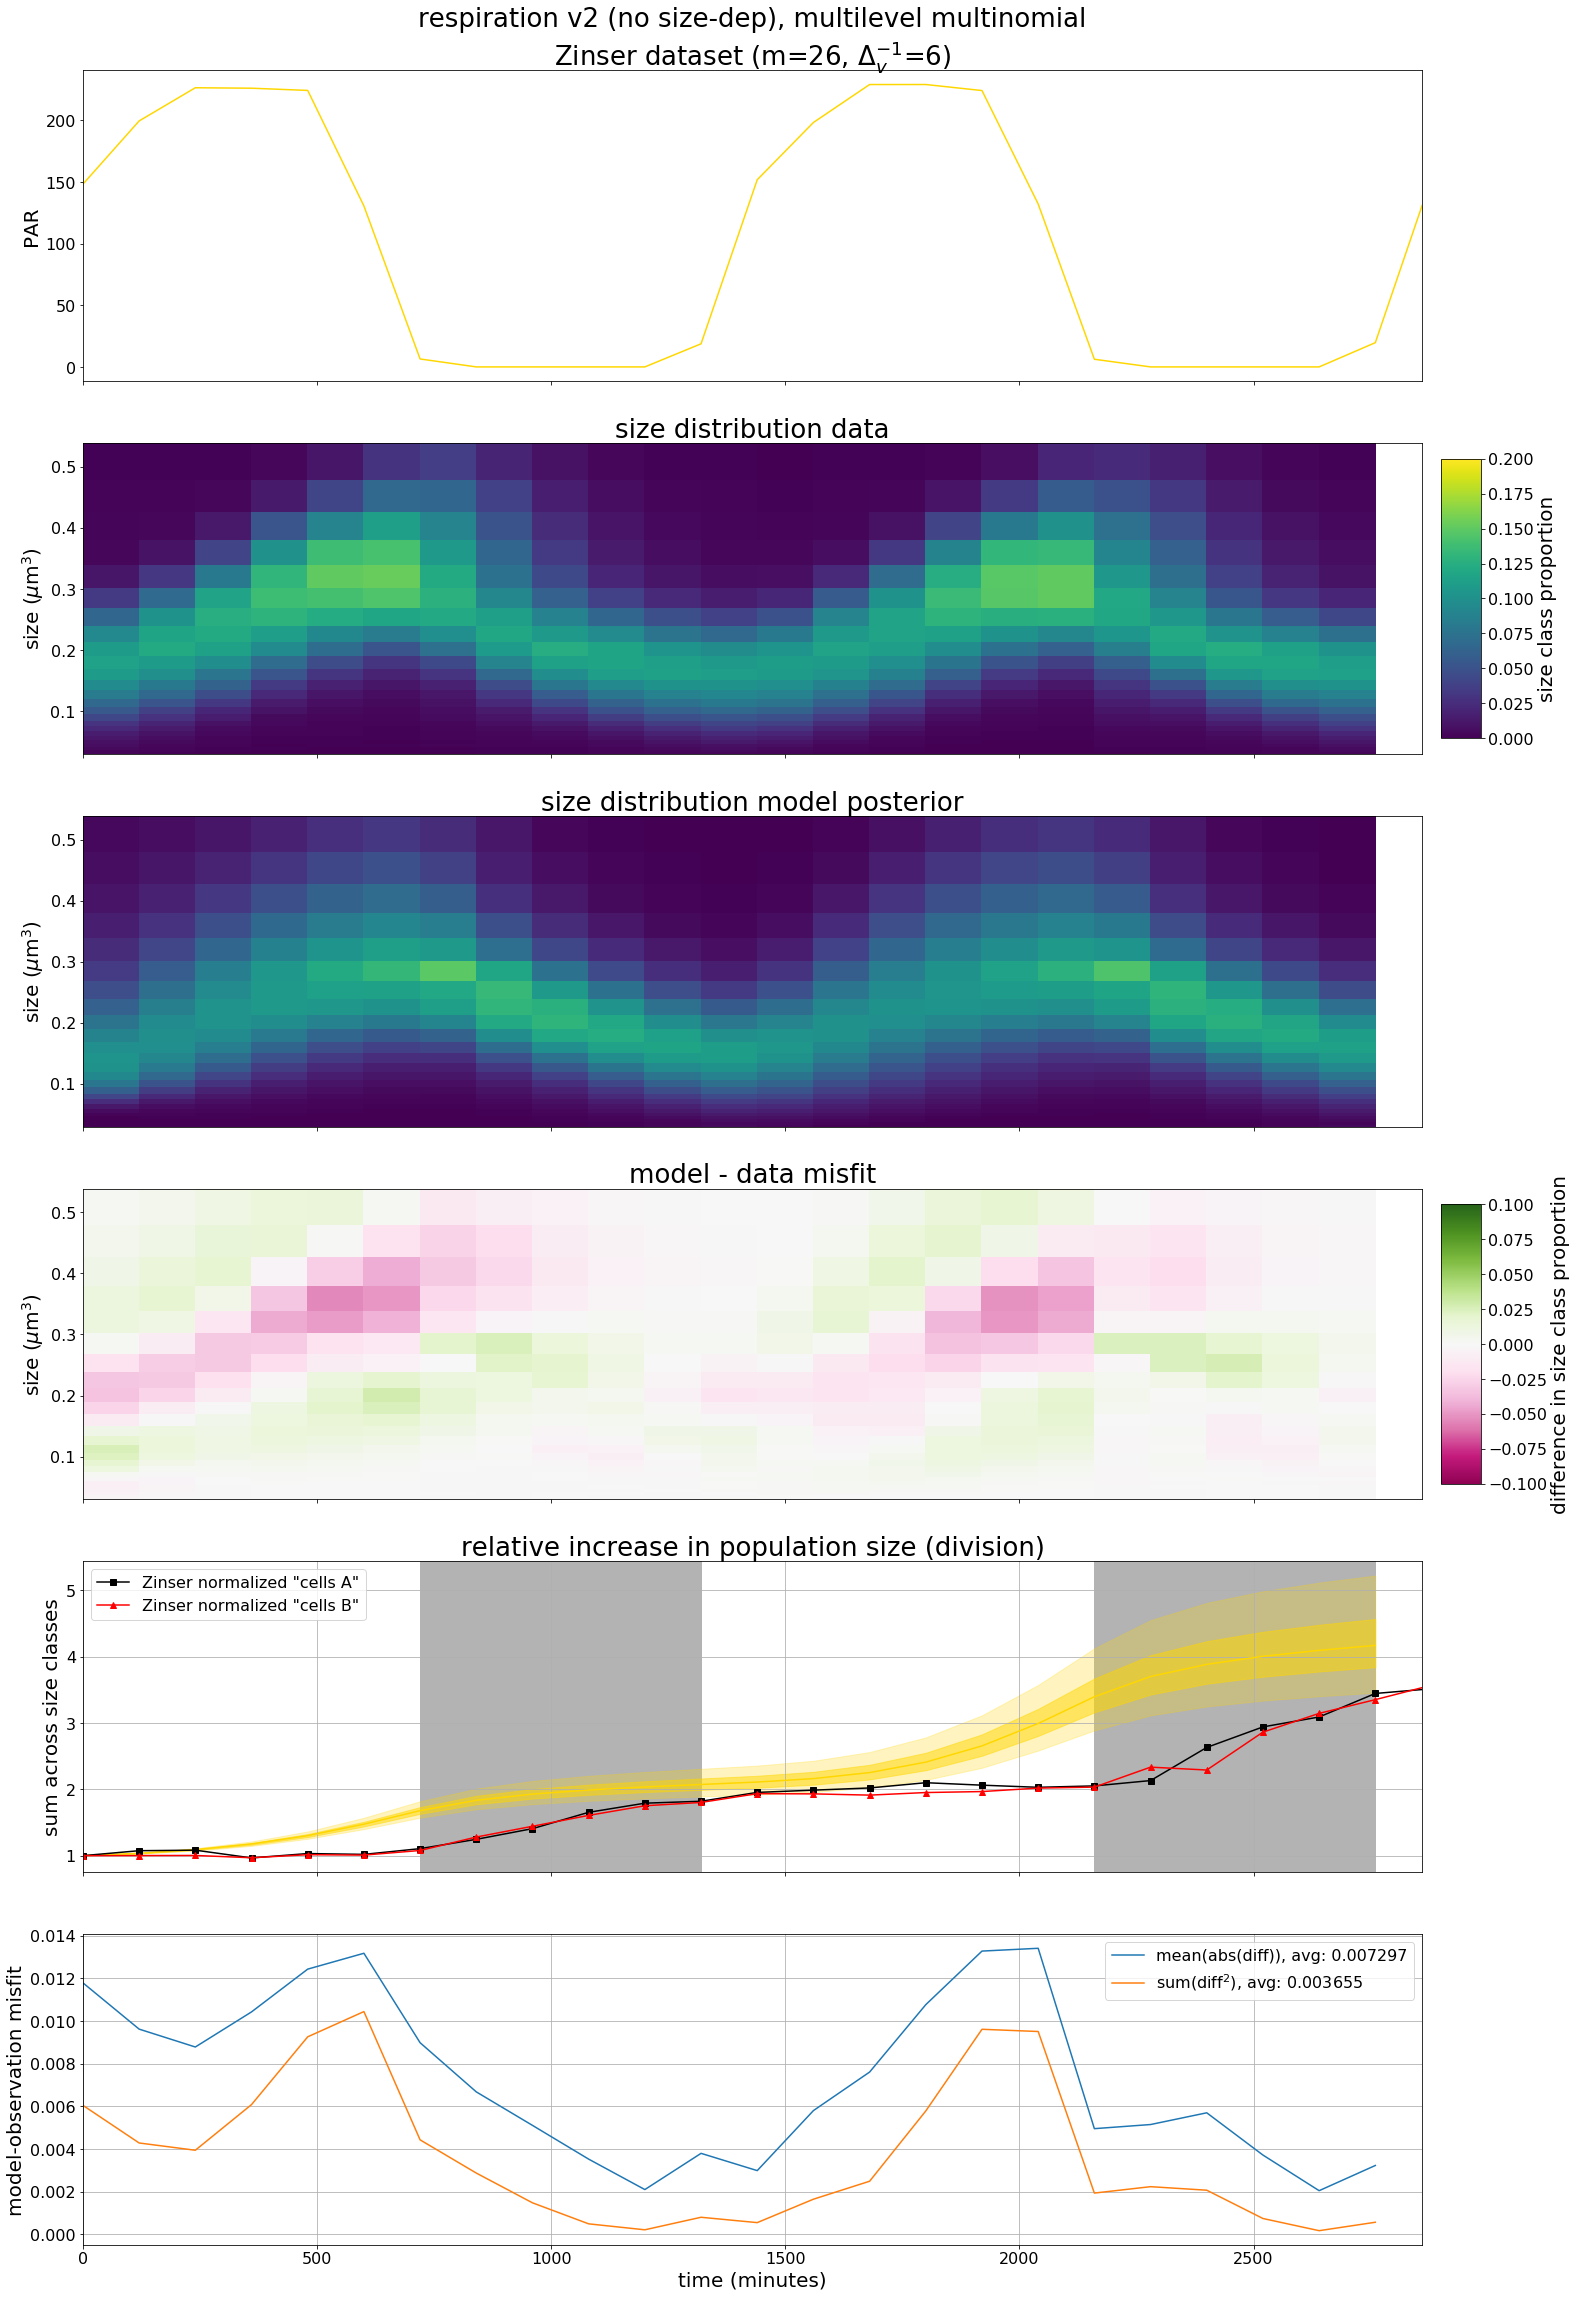

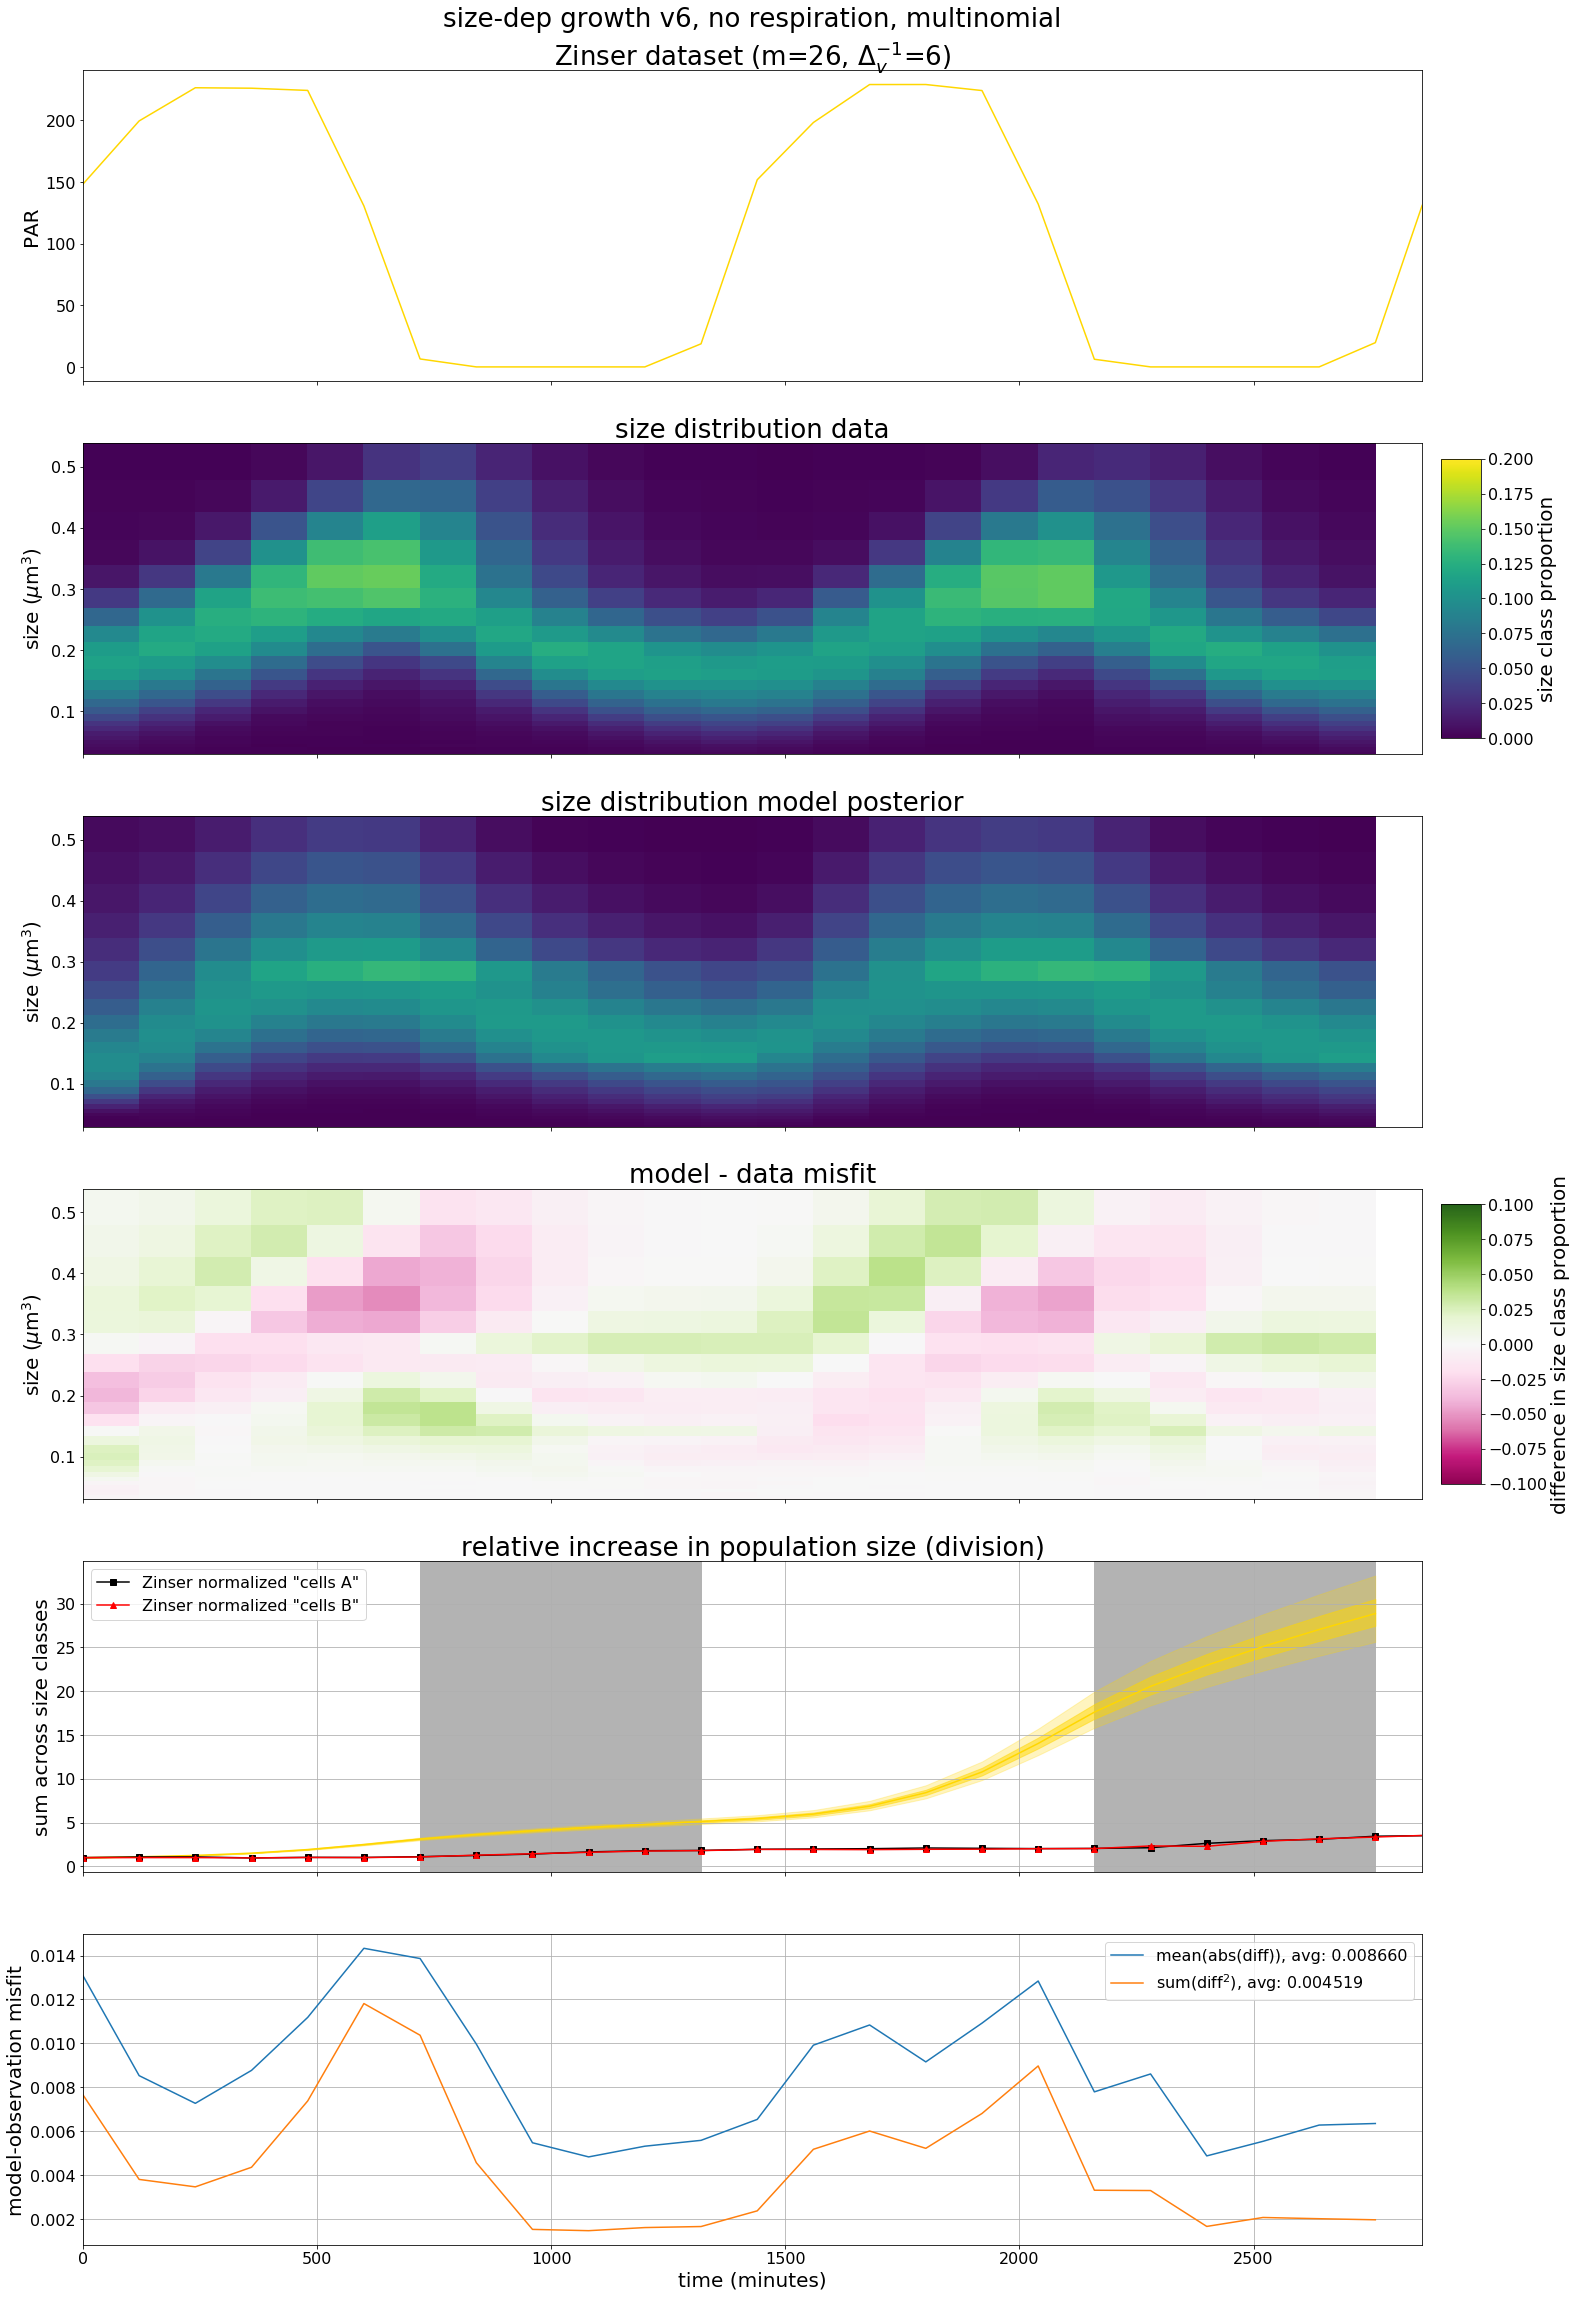

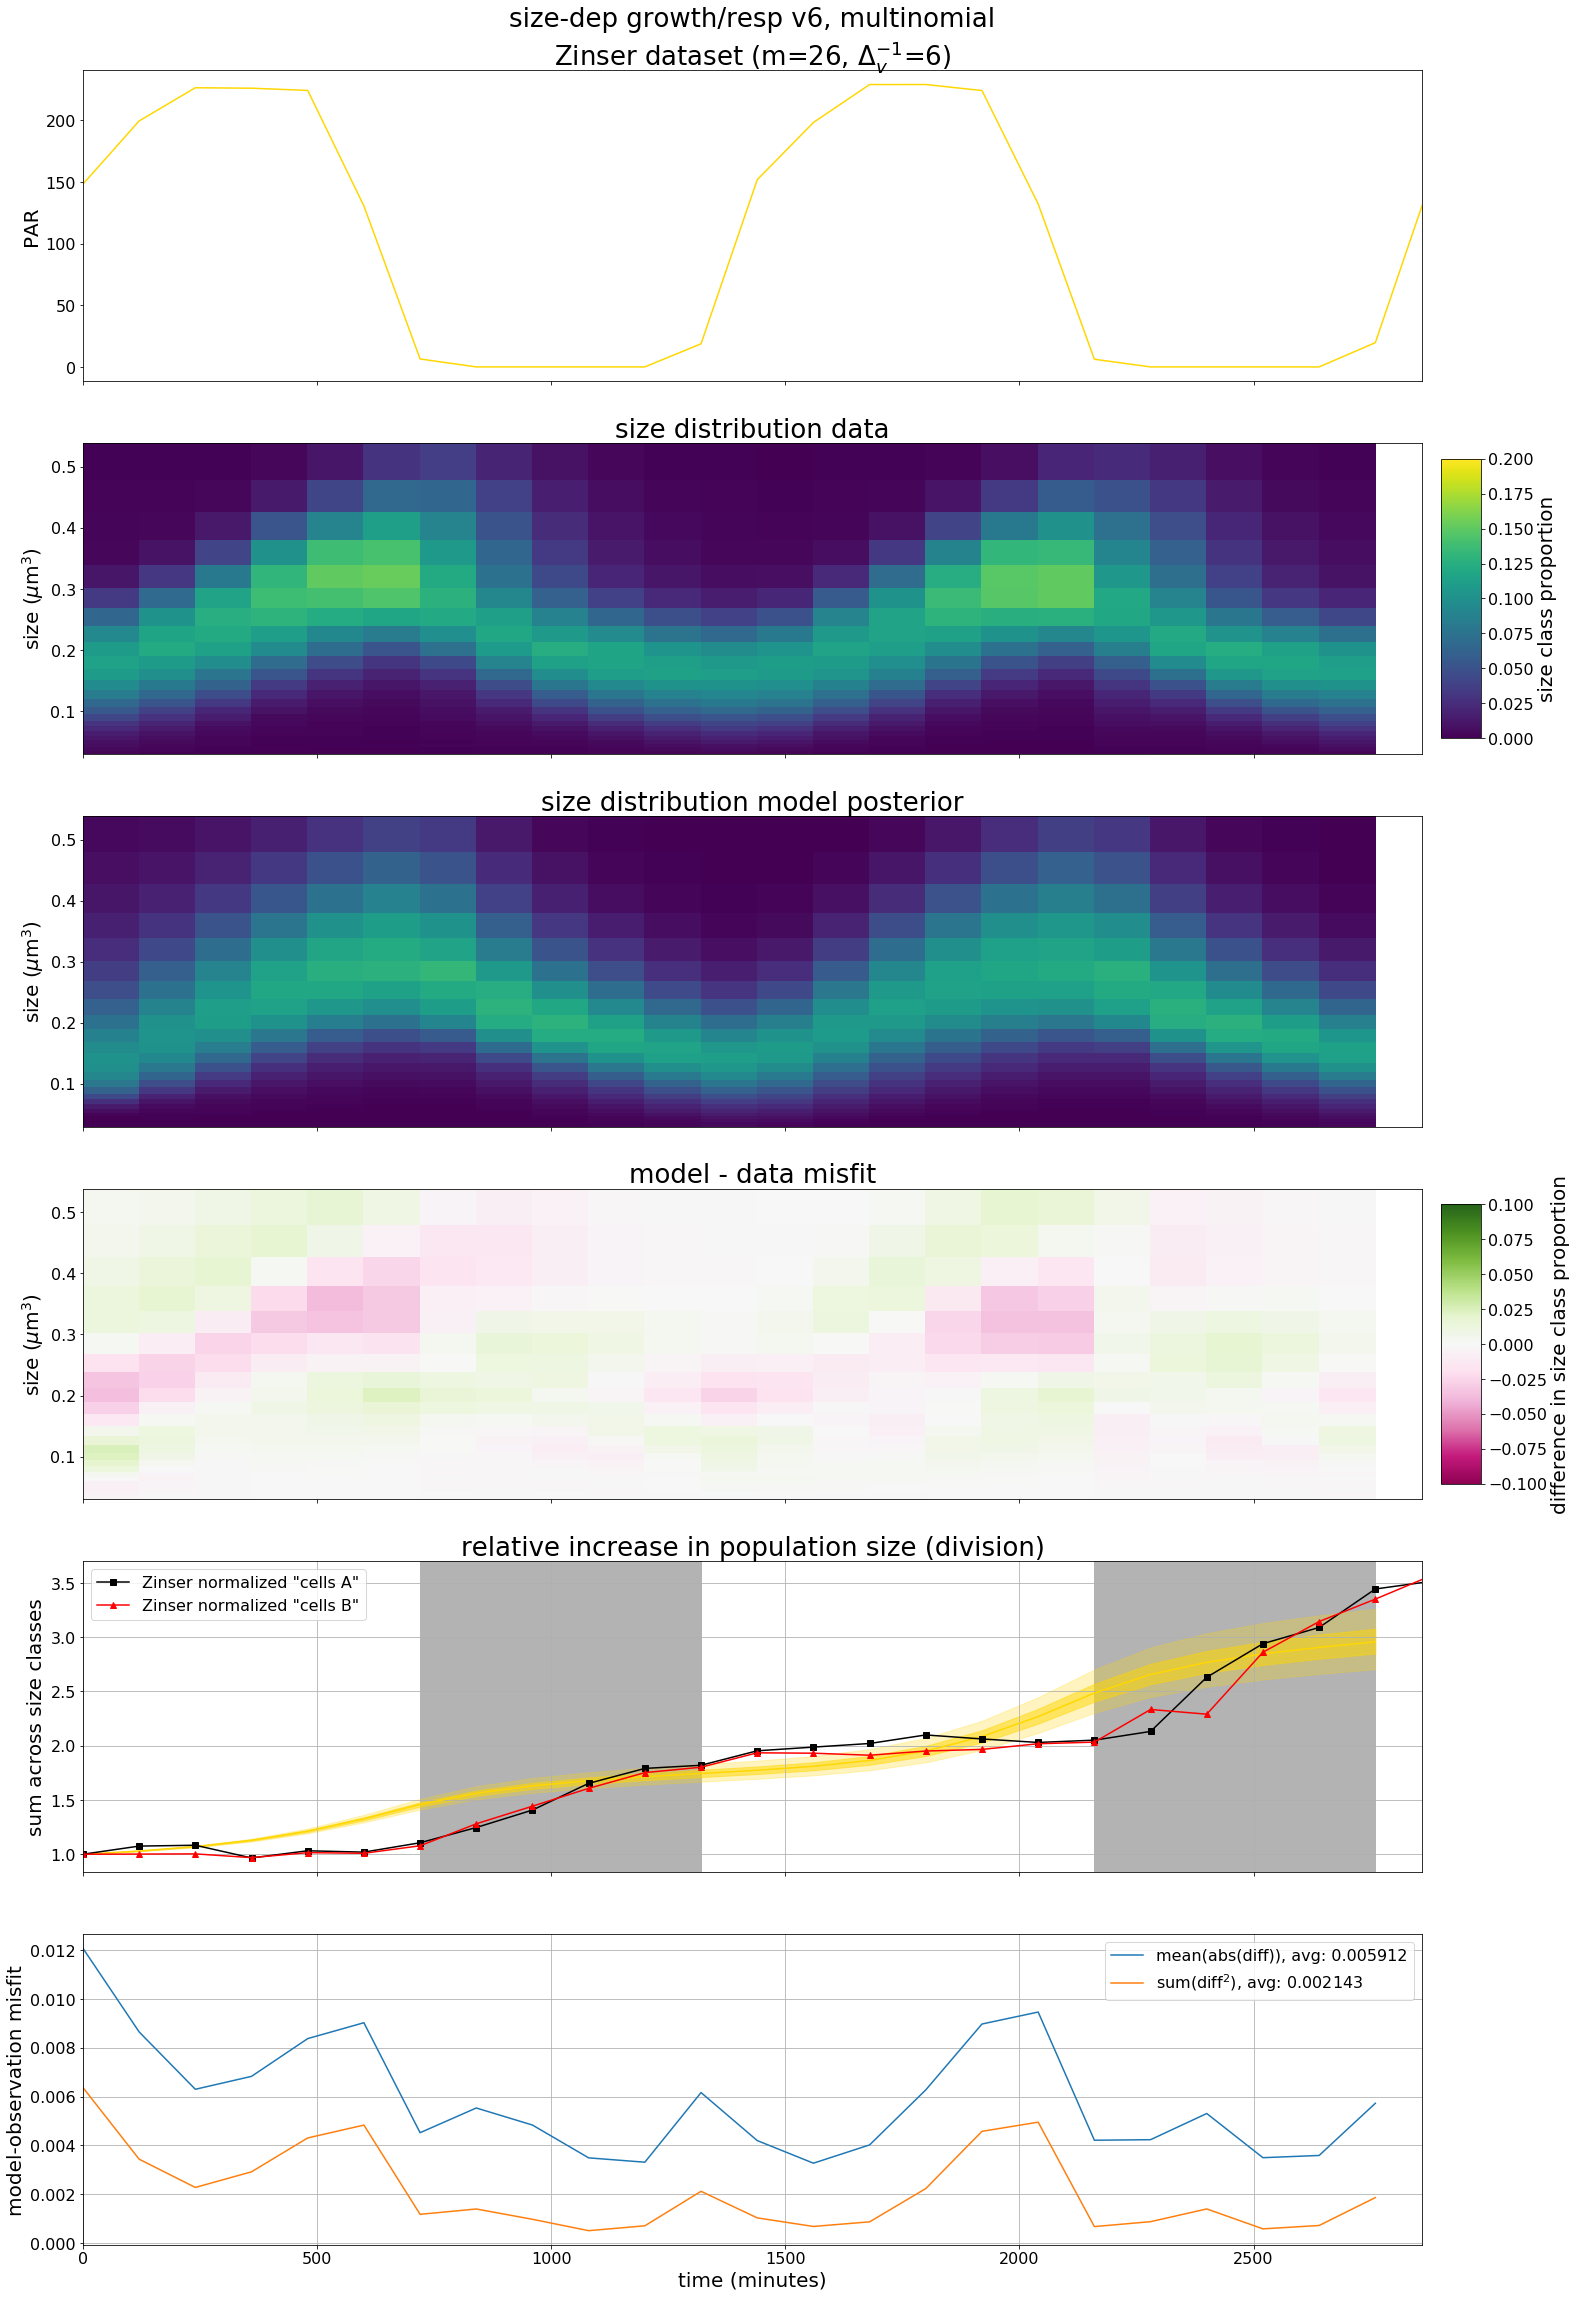

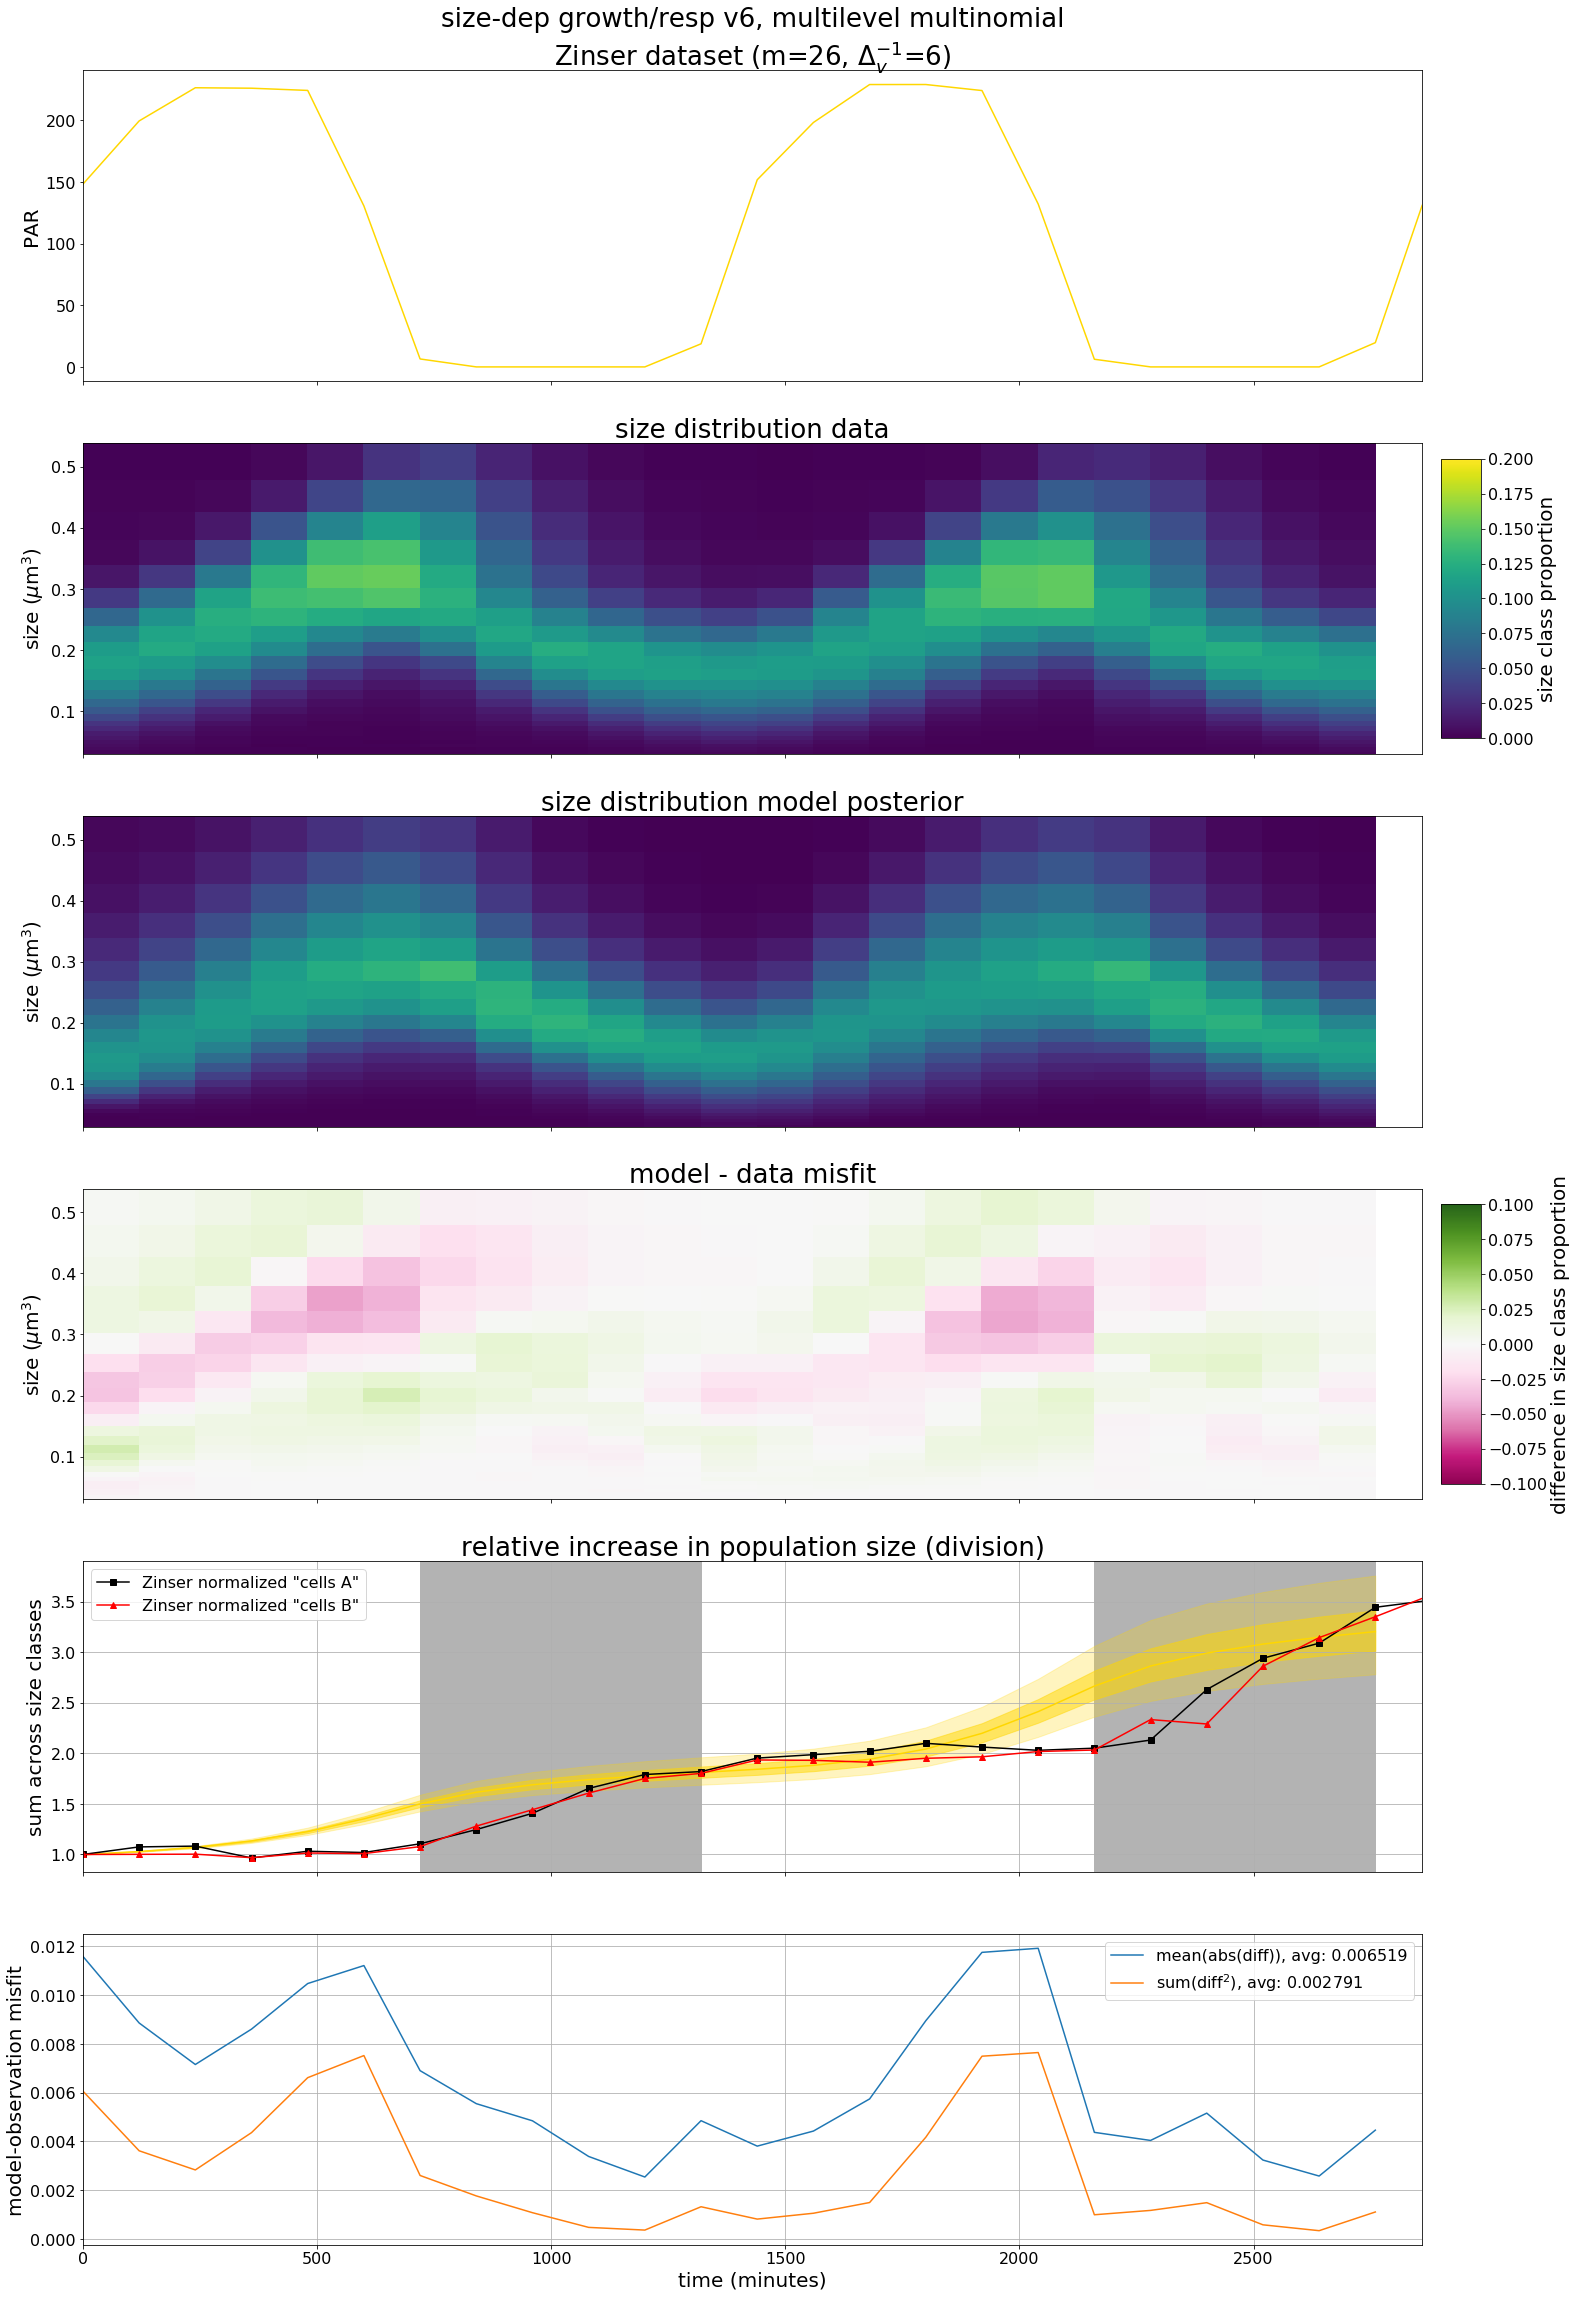

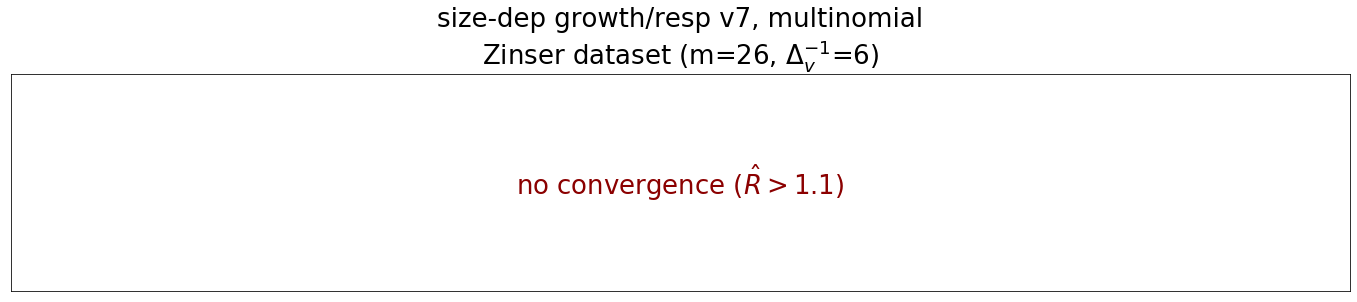

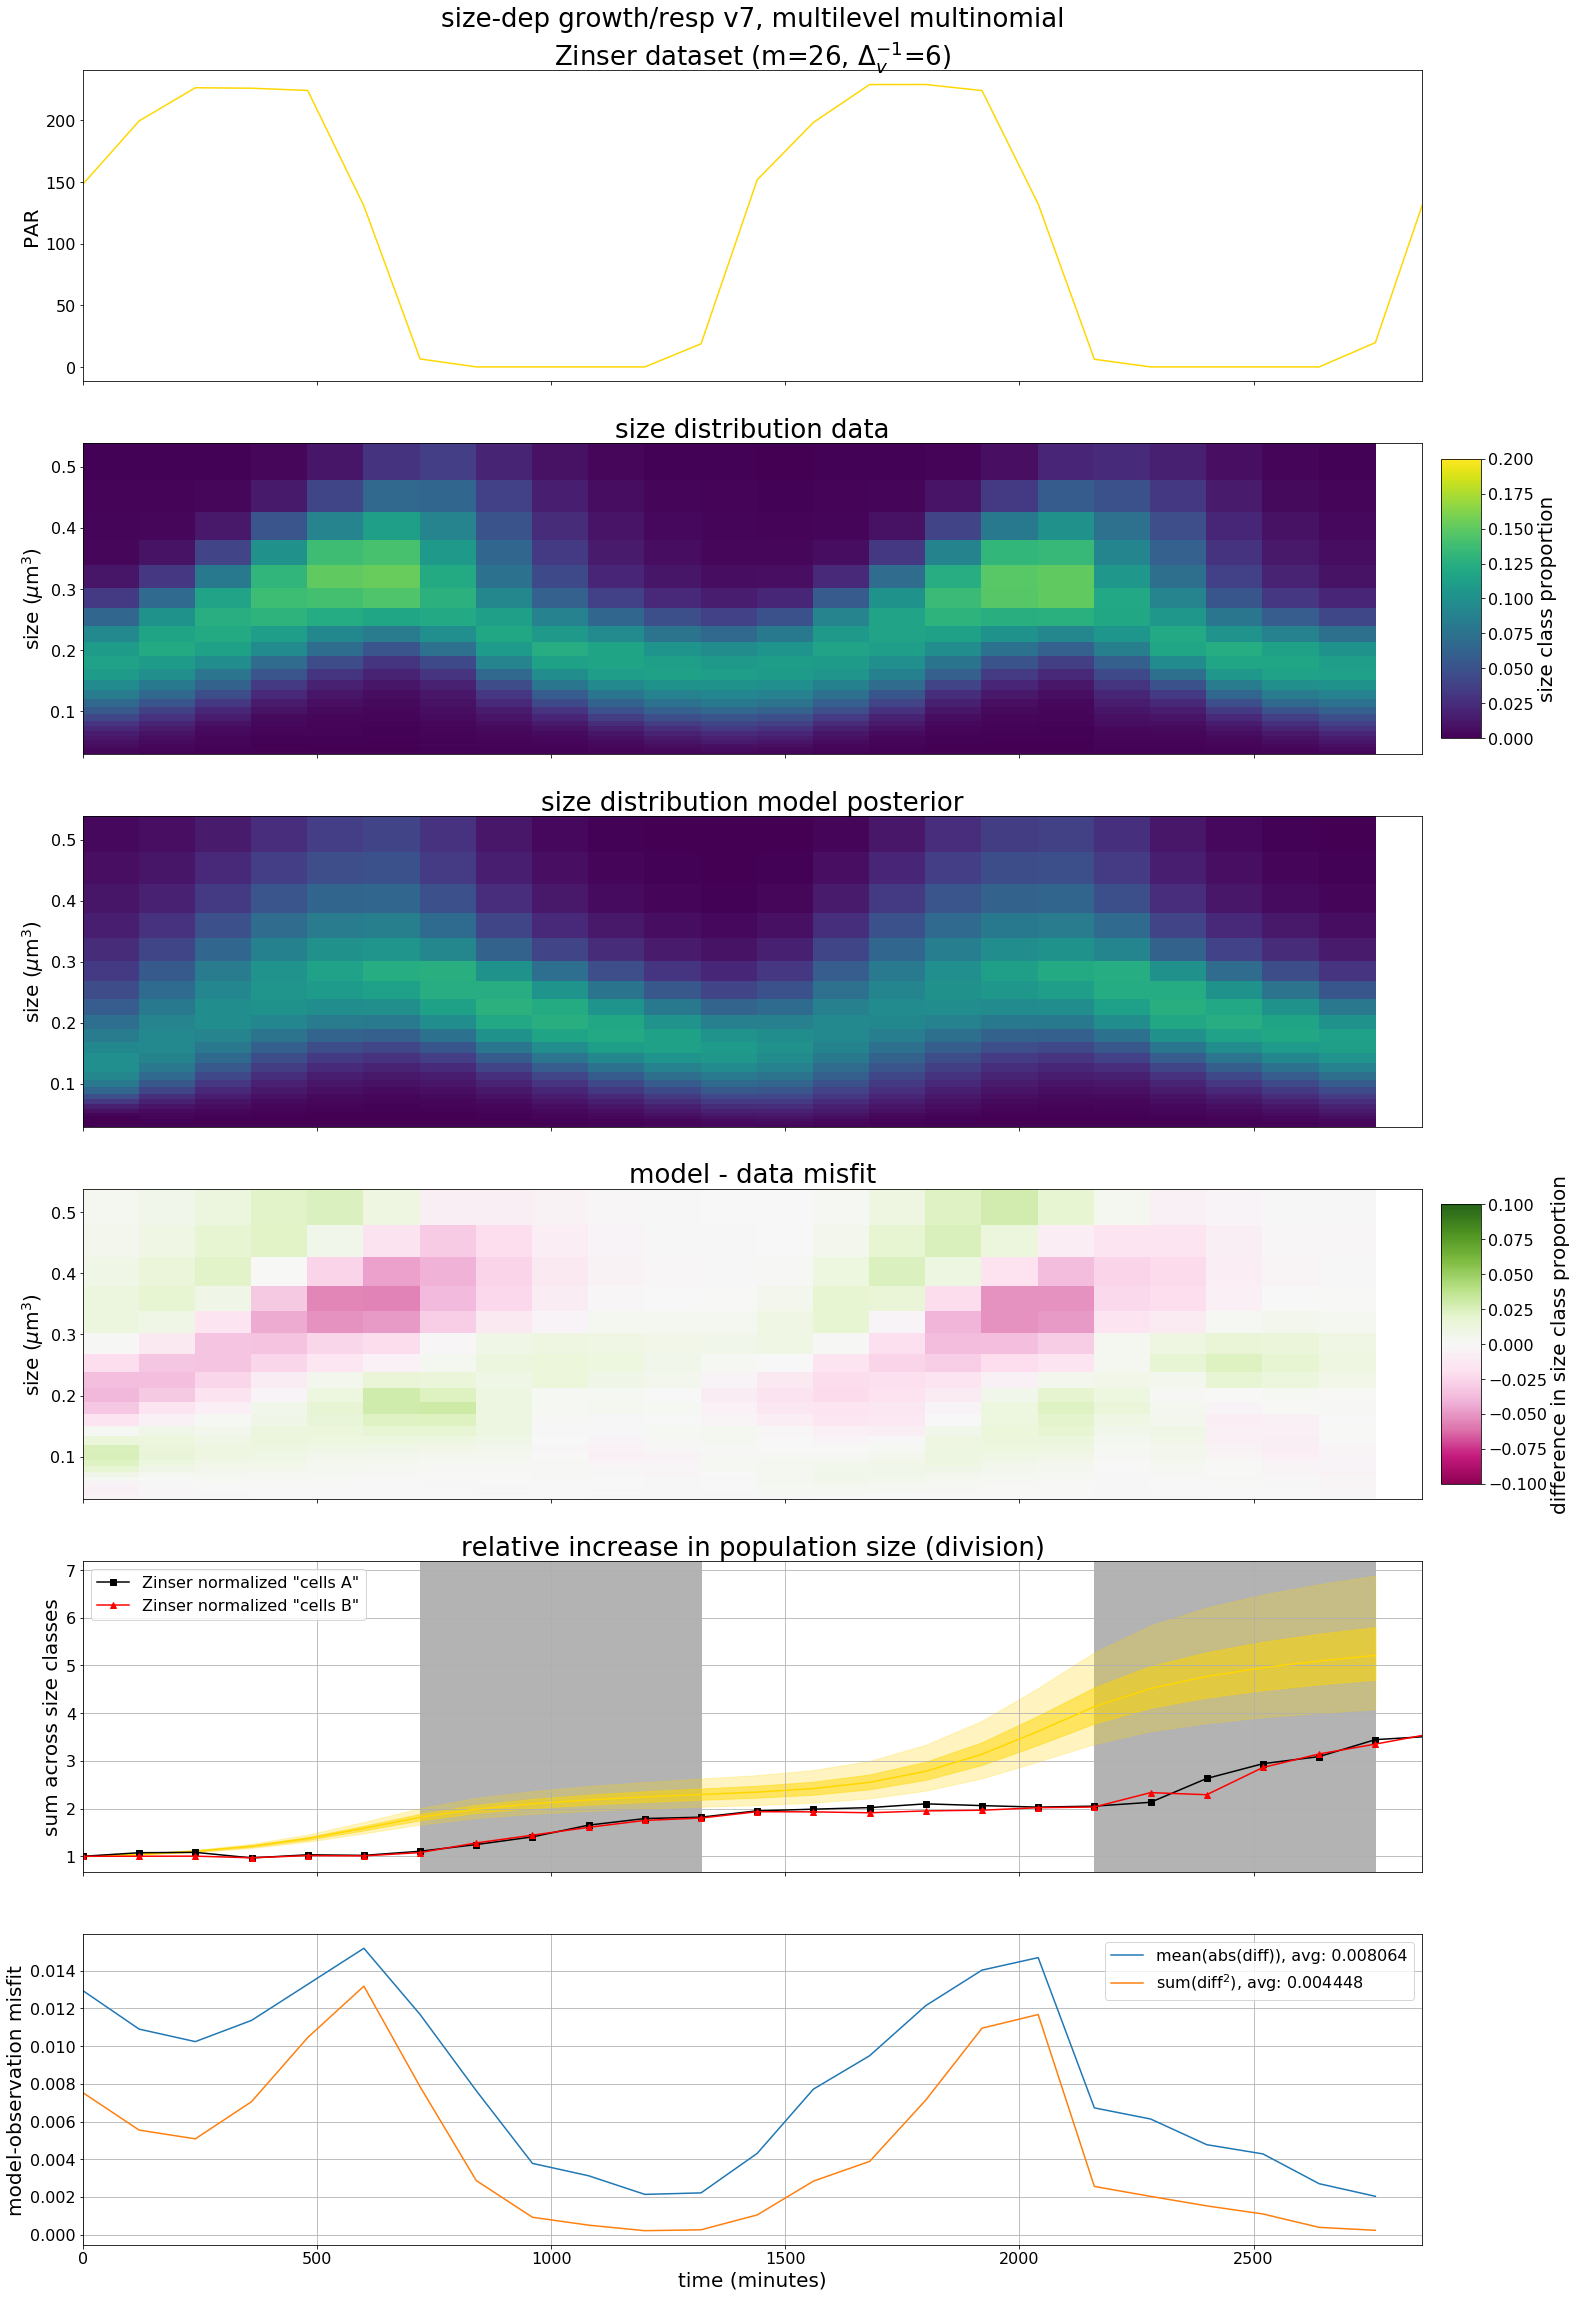

In [15]:
import pandas

data_fig2a = pandas.read_csv('data/Zinser_Figure2A.csv')

t_zinser = data_fig2a['exper time'] * 60
a_norm = data_fig2a['cells A'].copy()
a_norm /= a_norm[0]
b_norm = data_fig2a['cells B'].copy()
b_norm /= b_norm[0]

colors = {'model':'darkred', 'obs':'0.1'}

norm = mpl.colors.Normalize(0.0,0.2)
norm_diff = mpl.colors.Normalize(-0.1,0.1)

for dataname in data:
    for name,mcmc in mcmcs.items():
        t = data[dataname]['dt']*np.arange(data[dataname]['nt'])
        v_ext = data[dataname]['v_min'] * 2**(np.arange(data[dataname]['m']+1)*delta_v) 
        v = v_ext[:-1]
        v_width = v_ext[1:] - v_ext[:-1]
        
        res = {'model':np.mean(mcmc[dataname]['mod_obspos'], axis=0), 'obs':data[dataname]['obs']}
        res_sum1 = res['model']/np.sum(res['model'], axis=0)[None,:]
        diff = res_sum1-res['obs']

        if maxrhats_final[name][dataname] > 1.1:
            fig, ax = plt.subplots(figsize=(24,4))
            ax.set_title(desc_model[name] + '\n' + desc[dataname])
            ax.set(xticks=[], yticks=[])
            ax.text(0.5, 0.5, 'no convergence ($\\hat{R}>1.1$)', color='darkred', size=26, transform=ax.transAxes, ha='center', va='center')
            continue
        
        fig,axs = plt.subplots(6,1,sharex=True,figsize=(24,40))
        axs[0].set_title(desc_model[name] + '\n' + desc[dataname])

        ax = axs[0]
        ax.plot(t, data[dataname]['E'], color='gold')
        ax.set(xlim=(data[dataname]['t_obs'][0],t[-1]), ylabel='PAR')

        ax = axs[1]
        pc = ax.pcolormesh(data[dataname]['t_obs'],v,res['obs'],norm=norm)
        ax.set(ylabel='size ($\mu$m$^3$)', title='size distribution data')
        add_colorbar(ax, norm=pc.norm, cmap=pc.cmap, label='size class proportion')

        ax = axs[2]
        ax.set(ylabel='size ($\mu$m$^3$)', title='size distribution model posterior')
        pc = ax.pcolormesh(data[dataname]['t_obs'],v,res_sum1,norm=norm)

        ax = axs[3]
        pc = ax.pcolormesh(data[dataname]['t_obs'],v,diff,norm=norm_diff, cmap='PiYG')
        ax.set(ylabel='size ($\mu$m$^3$)', title='model - data misfit')
        add_colorbar(ax, norm=pc.norm, cmap=pc.cmap, label='difference in size class proportion')
        
        qq = np.percentile(np.sum(mcmc[dataname]['mod_obspos'], axis=1), axis=0, q=(5,25,50,75,95))
    
        ax = axs[4]
        ax.fill_between(data[dataname]['t_obs'], qq[0,:], qq[-1,:], alpha=0.25, color='gold')
        ax.fill_between(data[dataname]['t_obs'], qq[1,:], qq[-2,:], alpha=0.5, color='gold')
        ax.plot(data[dataname]['t_obs'], qq[2,:], color='gold')
        if 'zinser' in dataname:
            ax.plot(t_zinser, a_norm, color='black', marker='s', label='Zinser normalized "cells A"')
            ax.plot(t_zinser, b_norm, color='red', marker='^', label='Zinser normalized "cells B"')
            for iday in range(2):
                ax.axvspan(iday*24*60+12*60, iday*24*60+22*60, color='0.7', zorder=0)
            ax.legend()
        ax.grid(True)
        ax.set(ylabel='sum across size classes', title='relative increase in population size (division)')

        ax = axs[5]
        prop = np.mean(np.abs(diff),axis=0)
        ax.plot(data[dataname]['t_obs'], prop, label='mean(abs(diff)), avg: {:.6f}'.format(np.mean(prop)))
        prop = np.sum(diff**2,axis=0)
        ax.plot(data[dataname]['t_obs'], prop, label='sum(diff$^2$), avg: {:.6f}'.format(np.mean(prop)))
        ax.set(xlabel='time (minutes)', ylabel='model-observation misfit')
        ax.grid(True)
        ax.legend()